In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Dataframes
command: disjoint speaker split

In [3]:
dataframe_dir = '/home/muncok/DL/dataset/SV_sets/dataframes/'
data_dir = '/home/muncok/DL/dataset/SV_sets/voxceleb/'
data_df = pd.read_pickle('/home/muncok/DL/dataset/SV_sets/dataframes/Voxc_Dataframe.pkl')

In [4]:
import honk_sv.train as hk
import honk_sv.model as mod

### Dataset split

In [5]:
#TODO: correct splits
all_spks = data_df.spk.unique()
uttrs_counts = data_df.spk.value_counts()
sv_spks = list(uttrs_counts.index[-40:])
si_spks = list(uttrs_counts.index[:-40])

# SI Train

In [6]:
import random 

si_df = data_df[data_df.spk.isin(si_spks)]

# random sampling
si_random_train = si_df.sample(frac=0.8)
si_random_test = si_df.drop(index=si_random_train.index)
si_random_val = si_random_test.sample(frac=0.5)
si_random_test = si_random_test.drop(index=si_random_val.index) 
print("[random] train:{}, val:{}, test:{}".format(len(si_random_train), len(si_random_val), len(si_random_test)))

[random] train:120605, val:15076, test:15075


In [7]:
import csv
import random

tags = ['train', 'val', 'test']
# choose a si split
sets = {'train':si_random_train, 'val':si_random_val, 'test':si_random_test}
manifest_dir = "manifests/voxc/"

for tag in tags:
    samples = []
    save_path = os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("voxc", tag))
    with open(save_path, 'w') as f:
        for index, row in sets[tag].iterrows():
            file_path = os.path.join(data_dir, row.spk, row.file)
            label = si_spks.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

manifests/voxc/si_voxc_train_manifest.csv was written
manifests/voxc/si_voxc_val_manifest.csv was written
manifests/voxc/si_voxc_test_manifest.csv was written


In [74]:
model = "res15"
dataset = "voxc"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0,
                     n_epochs=30, batch_size=128,
                     lr=[0.01], schedule=[np.inf], dev_every=1, seed=0, use_nesterov=True,
                     cache_size=32768, momentum=0.90, weight_decay=0.00001,
                     num_workers=32, print_step=1,
                     )

builder = hk.ConfigBuilder(
                mod.find_config(model),
                mod.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
si_config = builder.config_from_argparse(parser)
si_config['model_class'] = mod.find_model(model)
hk.set_seed(si_config)

si_config['n_labels'] = len(si_spks)
manifest_dir = "manifests/voxc/"
for tag in ['train', 'val', 'test']:
    si_config['{}_manifest'.format(tag)]=os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("voxc", tag))

# si_model = si_config['model_class'](si_config)

si_config['input_length'] = int(16000*1)
si_config['splice_length'] = 20
seq_len         = 20
embd_size       = si_config['n_mels']
n_layers        = 10
kernel          = (5, embd_size)
out_chs         = 128
res_block_count = 5
ans_size = si_config['n_labels']
si_model = mod.GatedCNN(seq_len, embd_size, n_layers, kernel, out_chs, res_block_count, ans_size)
si_config['input_file'] = ""
si_config['output_file'] = "models/voxc/si_voxc_gatedcnn_100.pt"
print(si_model)


GatedCNN (
  (conv_0): Conv2d(1, 128, kernel_size=(5, 40), stride=(1, 1), padding=(2, 0))
  (conv_gate_0): Conv2d(1, 128, kernel_size=(5, 40), stride=(1, 1), padding=(2, 0))
  (conv): ModuleList (
    (0): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (1): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (2): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (3): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (4): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (5): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (6): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (7): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (8): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (9): Conv2d(128, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  )
  (conv_gate): ModuleList (
 

In [75]:
# si_model.load("models/voxc/si_voxc_frames_.pt")
# si_config['n_epochs'] = 0
hk.train(si_config, model=si_model, _collate_fn=hk._random_frames_collate_fn)

train step #1 accuracy: 0.0, loss: 7.157472610473633
train step #2 accuracy: 0.0, loss: 7.141103267669678
train step #3 accuracy: 0.0, loss: 7.21714973449707
train step #4 accuracy: 0.0, loss: 7.228932857513428
train step #5 accuracy: 0.0, loss: 7.210745811462402
train step #6 accuracy: 0.0, loss: 7.18197774887085
train step #7 accuracy: 0.0, loss: 7.19083309173584
train step #8 accuracy: 0.0, loss: 7.115045070648193
train step #9 accuracy: 0.0, loss: 7.153808116912842
train step #10 accuracy: 0.015625, loss: 7.206038951873779
train step #11 accuracy: 0.0, loss: 7.117090702056885
train step #12 accuracy: 0.0, loss: 7.086361408233643
train step #13 accuracy: 0.0, loss: 7.114558219909668
train step #14 accuracy: 0.0078125, loss: 7.126650333404541
train step #15 accuracy: 0.0, loss: 7.0477166175842285
train step #16 accuracy: 0.0, loss: 7.093862533569336
train step #17 accuracy: 0.0, loss: 6.996532440185547
train step #18 accuracy: 0.0, loss: 7.097580432891846
train step #19 accuracy: 0.0

train step #144 accuracy: 0.0234375, loss: 6.799269199371338
train step #145 accuracy: 0.0234375, loss: 6.840825080871582
train step #146 accuracy: 0.0234375, loss: 6.800034523010254
train step #147 accuracy: 0.0, loss: 7.002634525299072
train step #148 accuracy: 0.015625, loss: 6.885293006896973
train step #149 accuracy: 0.015625, loss: 6.806549072265625
train step #150 accuracy: 0.0234375, loss: 6.8112897872924805
train step #151 accuracy: 0.0, loss: 6.864726543426514
train step #152 accuracy: 0.015625, loss: 6.8972859382629395
train step #153 accuracy: 0.0, loss: 6.9088311195373535
train step #154 accuracy: 0.0, loss: 6.921206951141357
train step #155 accuracy: 0.0234375, loss: 6.753589630126953
train step #156 accuracy: 0.0078125, loss: 6.833611488342285
train step #157 accuracy: 0.0078125, loss: 6.845364570617676
train step #158 accuracy: 0.0, loss: 6.850078582763672
train step #159 accuracy: 0.0234375, loss: 6.80086088180542
train step #160 accuracy: 0.015625, loss: 6.69856166839

train step #284 accuracy: 0.0, loss: 6.650781631469727
train step #285 accuracy: 0.0078125, loss: 6.776368618011475
train step #286 accuracy: 0.0, loss: 6.701738357543945
train step #287 accuracy: 0.015625, loss: 6.743712902069092
train step #288 accuracy: 0.0078125, loss: 6.838746070861816
train step #289 accuracy: 0.015625, loss: 6.707681655883789
train step #290 accuracy: 0.015625, loss: 6.668858528137207
train step #291 accuracy: 0.0078125, loss: 6.678647518157959
train step #292 accuracy: 0.0078125, loss: 6.8165178298950195
train step #293 accuracy: 0.0, loss: 6.626415729522705
train step #294 accuracy: 0.0234375, loss: 6.722513198852539
train step #295 accuracy: 0.0234375, loss: 6.631851673126221
train step #296 accuracy: 0.0078125, loss: 6.65570068359375
train step #297 accuracy: 0.0, loss: 6.868753433227539
train step #298 accuracy: 0.0078125, loss: 6.6644206047058105
train step #299 accuracy: 0.015625, loss: 6.6652302742004395
train step #300 accuracy: 0.0078125, loss: 6.54183

train step #424 accuracy: 0.0, loss: 6.581272602081299
train step #425 accuracy: 0.0078125, loss: 6.724453449249268
train step #426 accuracy: 0.0234375, loss: 6.56718111038208
train step #427 accuracy: 0.0234375, loss: 6.558220863342285
train step #428 accuracy: 0.0078125, loss: 6.429962635040283
train step #429 accuracy: 0.03125, loss: 6.45734977722168
train step #430 accuracy: 0.0234375, loss: 6.551421165466309
train step #431 accuracy: 0.0234375, loss: 6.46500301361084
train step #432 accuracy: 0.0078125, loss: 6.681319236755371
train step #433 accuracy: 0.03125, loss: 6.442260265350342
train step #434 accuracy: 0.015625, loss: 6.548503875732422
train step #435 accuracy: 0.0, loss: 6.67564582824707
train step #436 accuracy: 0.0, loss: 6.574670791625977
train step #437 accuracy: 0.0078125, loss: 6.513652801513672
train step #438 accuracy: 0.03125, loss: 6.604467868804932
train step #439 accuracy: 0.0234375, loss: 6.578522682189941
train step #440 accuracy: 0.0, loss: 6.64153099060058

train step #562 accuracy: 0.0078125, loss: 6.419508457183838
train step #563 accuracy: 0.0234375, loss: 6.4729533195495605
train step #564 accuracy: 0.015625, loss: 6.601054668426514
train step #565 accuracy: 0.015625, loss: 7.214967727661133
train step #566 accuracy: 0.0078125, loss: 6.653312683105469
train step #567 accuracy: 0.0078125, loss: 6.707936763763428
train step #568 accuracy: 0.0078125, loss: 6.665100574493408
train step #569 accuracy: 0.0078125, loss: 6.620425224304199
train step #570 accuracy: 0.0078125, loss: 6.660654544830322
train step #571 accuracy: 0.015625, loss: 6.6177144050598145
train step #572 accuracy: 0.0078125, loss: 6.709590435028076
train step #573 accuracy: 0.0, loss: 6.653247833251953
train step #574 accuracy: 0.015625, loss: 6.744632244110107
train step #575 accuracy: 0.0, loss: 6.567816257476807
train step #576 accuracy: 0.0078125, loss: 6.477778434753418
train step #577 accuracy: 0.015625, loss: 6.583472728729248
train step #578 accuracy: 0.0078125, lo

train step #701 accuracy: 0.0078125, loss: 6.423662185668945
train step #702 accuracy: 0.015625, loss: 6.404974460601807
train step #703 accuracy: 0.0, loss: 6.417603492736816
train step #704 accuracy: 0.0078125, loss: 6.365509033203125
train step #705 accuracy: 0.0078125, loss: 6.4011383056640625
train step #706 accuracy: 0.0234375, loss: 6.410166263580322
train step #707 accuracy: 0.0234375, loss: 6.226524353027344
train step #708 accuracy: 0.03125, loss: 6.2671403884887695
train step #709 accuracy: 0.0, loss: 6.400184154510498
train step #710 accuracy: 0.0078125, loss: 6.435941219329834
train step #711 accuracy: 0.0390625, loss: 6.303521633148193
train step #712 accuracy: 0.015625, loss: 6.468145370483398
train step #713 accuracy: 0.0078125, loss: 6.464992046356201
train step #714 accuracy: 0.0234375, loss: 6.318301677703857
train step #715 accuracy: 0.015625, loss: 6.239645957946777
train step #716 accuracy: 0.0, loss: 6.391539096832275
train step #717 accuracy: 0.0078125, loss: 6.

train step #838 accuracy: 0.0390625, loss: 6.0170111656188965
train step #839 accuracy: 0.0, loss: 6.237048625946045
train step #840 accuracy: 0.0234375, loss: 6.124083518981934
train step #841 accuracy: 0.046875, loss: 6.153710842132568
train step #842 accuracy: 0.0078125, loss: 6.336009979248047
train step #843 accuracy: 0.015625, loss: 5.984279632568359
train step #844 accuracy: 0.0234375, loss: 6.31821346282959
train step #845 accuracy: 0.03125, loss: 6.140417098999023
train step #846 accuracy: 0.0234375, loss: 6.230897426605225
train step #847 accuracy: 0.046875, loss: 6.021671772003174
train step #848 accuracy: 0.03125, loss: 6.393321990966797
train step #849 accuracy: 0.0234375, loss: 6.253517150878906
train step #850 accuracy: 0.0, loss: 6.14939022064209
train step #851 accuracy: 0.015625, loss: 6.373868465423584
train step #852 accuracy: 0.015625, loss: 6.202112674713135
train step #853 accuracy: 0.0390625, loss: 6.111594200134277
train step #854 accuracy: 0.0390625, loss: 5.9

train step #974 accuracy: 0.03125, loss: 6.012200355529785
train step #975 accuracy: 0.0234375, loss: 6.00823974609375
train step #976 accuracy: 0.0078125, loss: 6.179296016693115
train step #977 accuracy: 0.03125, loss: 5.88101863861084
train step #978 accuracy: 0.0078125, loss: 6.077883243560791
train step #979 accuracy: 0.03125, loss: 6.1938676834106445
train step #980 accuracy: 0.0703125, loss: 5.814365863800049
train step #981 accuracy: 0.03125, loss: 6.092339515686035
train step #982 accuracy: 0.046875, loss: 5.8918938636779785
train step #983 accuracy: 0.0078125, loss: 5.985565662384033
train step #984 accuracy: 0.015625, loss: 5.96443510055542
train step #985 accuracy: 0.0390625, loss: 6.108639717102051
train step #986 accuracy: 0.0234375, loss: 6.179991245269775
train step #987 accuracy: 0.015625, loss: 6.055908679962158
train step #988 accuracy: 0.0390625, loss: 6.000335216522217
train step #989 accuracy: 0.03125, loss: 6.285296440124512
train step #990 accuracy: 0.0546875, l

train step #1109 accuracy: 0.0078125, loss: 6.047417163848877
train step #1110 accuracy: 0.03125, loss: 5.740381240844727
train step #1111 accuracy: 0.015625, loss: 5.773015975952148
train step #1112 accuracy: 0.0625, loss: 5.766307353973389
train step #1113 accuracy: 0.0546875, loss: 5.870275497436523
train step #1114 accuracy: 0.0234375, loss: 6.099847793579102
train step #1115 accuracy: 0.03125, loss: 6.068282127380371
train step #1116 accuracy: 0.0390625, loss: 6.232061386108398
train step #1117 accuracy: 0.03125, loss: 6.0621232986450195
train step #1118 accuracy: 0.0546875, loss: 5.95396089553833
train step #1119 accuracy: 0.015625, loss: 6.241565704345703
train step #1120 accuracy: 0.03125, loss: 6.08961296081543
train step #1121 accuracy: 0.03125, loss: 5.757359504699707
train step #1122 accuracy: 0.0078125, loss: 6.02845573425293
train step #1123 accuracy: 0.015625, loss: 6.211030960083008
train step #1124 accuracy: 0.0390625, loss: 6.260277271270752
train step #1125 accuracy:

train step #1243 accuracy: 0.046875, loss: 5.784660339355469
train step #1244 accuracy: 0.015625, loss: 6.146026611328125
train step #1245 accuracy: 0.03125, loss: 5.894731044769287
train step #1246 accuracy: 0.0546875, loss: 5.681191444396973
train step #1247 accuracy: 0.03125, loss: 5.900405406951904
train step #1248 accuracy: 0.0546875, loss: 5.583764553070068
train step #1249 accuracy: 0.046875, loss: 5.8338847160339355
train step #1250 accuracy: 0.078125, loss: 5.9573493003845215
train step #1251 accuracy: 0.03125, loss: 5.985755920410156
train step #1252 accuracy: 0.046875, loss: 5.8154120445251465
train step #1253 accuracy: 0.0546875, loss: 5.629849910736084
train step #1254 accuracy: 0.09375, loss: 5.7336649894714355
train step #1255 accuracy: 0.0, loss: 5.7304768562316895
train step #1256 accuracy: 0.03125, loss: 6.024632930755615
train step #1257 accuracy: 0.03125, loss: 6.106571197509766
train step #1258 accuracy: 0.0859375, loss: 5.8923420906066895
train step #1259 accuracy

train step #1378 accuracy: 0.0390625, loss: 5.887244701385498
train step #1379 accuracy: 0.03125, loss: 5.9796366691589355
train step #1380 accuracy: 0.0390625, loss: 5.575220584869385
train step #1381 accuracy: 0.0625, loss: 5.649727821350098
train step #1382 accuracy: 0.046875, loss: 5.581839561462402
train step #1383 accuracy: 0.046875, loss: 5.797245979309082
train step #1384 accuracy: 0.078125, loss: 5.606576919555664
train step #1385 accuracy: 0.0859375, loss: 5.361518859863281
train step #1386 accuracy: 0.03125, loss: 5.802288055419922
train step #1387 accuracy: 0.0703125, loss: 5.577895641326904
train step #1388 accuracy: 0.03125, loss: 6.042870998382568
train step #1389 accuracy: 0.046875, loss: 6.345278263092041
train step #1390 accuracy: 0.0546875, loss: 5.747317314147949
train step #1391 accuracy: 0.046875, loss: 5.722357749938965
train step #1392 accuracy: 0.0546875, loss: 5.829023361206055
train step #1393 accuracy: 0.0546875, loss: 5.516125202178955
train step #1394 accu

train step #1513 accuracy: 0.03125, loss: 5.64932107925415
train step #1514 accuracy: 0.0625, loss: 5.606564044952393
train step #1515 accuracy: 0.0703125, loss: 5.63618803024292
train step #1516 accuracy: 0.0703125, loss: 5.596195697784424
train step #1517 accuracy: 0.0703125, loss: 5.532917499542236
train step #1518 accuracy: 0.0546875, loss: 5.65321159362793
train step #1519 accuracy: 0.0078125, loss: 6.00396203994751
train step #1520 accuracy: 0.0859375, loss: 5.494081974029541
train step #1521 accuracy: 0.046875, loss: 5.628873825073242
train step #1522 accuracy: 0.015625, loss: 5.933652877807617
train step #1523 accuracy: 0.0546875, loss: 5.498444557189941
train step #1524 accuracy: 0.046875, loss: 5.805239677429199
train step #1525 accuracy: 0.0625, loss: 5.5606303215026855
train step #1526 accuracy: 0.0234375, loss: 5.961965084075928
train step #1527 accuracy: 0.0390625, loss: 5.701512336730957
train step #1528 accuracy: 0.0703125, loss: 5.4012908935546875
train step #1529 accu

train step #1648 accuracy: 0.046875, loss: 5.719946384429932
train step #1649 accuracy: 0.03125, loss: 5.9652180671691895
train step #1650 accuracy: 0.03125, loss: 5.613181114196777
train step #1651 accuracy: 0.0390625, loss: 5.667957305908203
train step #1652 accuracy: 0.0234375, loss: 6.183197021484375
train step #1653 accuracy: 0.0390625, loss: 5.82106876373291
train step #1654 accuracy: 0.0390625, loss: 5.848606586456299
train step #1655 accuracy: 0.015625, loss: 5.934497833251953
train step #1656 accuracy: 0.0703125, loss: 5.449831485748291
train step #1657 accuracy: 0.046875, loss: 5.640391826629639
train step #1658 accuracy: 0.046875, loss: 5.745296001434326
train step #1659 accuracy: 0.046875, loss: 5.442618370056152
train step #1660 accuracy: 0.0703125, loss: 5.643653392791748
train step #1661 accuracy: 0.0546875, loss: 5.601539611816406
train step #1662 accuracy: 0.0859375, loss: 5.43565034866333
train step #1663 accuracy: 0.046875, loss: 5.518536567687988
train step #1664 ac

train step #1782 accuracy: 0.0546875, loss: 5.542294979095459
train step #1783 accuracy: 0.09375, loss: 5.296683311462402
train step #1784 accuracy: 0.0703125, loss: 5.459834098815918
train step #1785 accuracy: 0.0625, loss: 5.359171390533447
train step #1786 accuracy: 0.078125, loss: 5.323509693145752
train step #1787 accuracy: 0.09375, loss: 5.293755054473877
train step #1788 accuracy: 0.0625, loss: 5.6390886306762695
train step #1789 accuracy: 0.0625, loss: 5.56689453125
train step #1790 accuracy: 0.0859375, loss: 5.4916534423828125
train step #1791 accuracy: 0.0390625, loss: 5.710640907287598
train step #1792 accuracy: 0.046875, loss: 5.60567045211792
train step #1793 accuracy: 0.0546875, loss: 5.4118332862854
train step #1794 accuracy: 0.0703125, loss: 5.513683319091797
train step #1795 accuracy: 0.0625, loss: 5.494673728942871
train step #1796 accuracy: 0.0703125, loss: 5.456282615661621
train step #1797 accuracy: 0.09375, loss: 5.551612377166748
train step #1798 accuracy: 0.0937

train step #1916 accuracy: 0.03125, loss: 5.5081305503845215
train step #1917 accuracy: 0.09375, loss: 5.413001537322998
train step #1918 accuracy: 0.046875, loss: 5.319232940673828
train step #1919 accuracy: 0.078125, loss: 5.159294128417969
train step #1920 accuracy: 0.0546875, loss: 5.497332572937012
train step #1921 accuracy: 0.0859375, loss: 5.202178001403809
train step #1922 accuracy: 0.0546875, loss: 5.409954071044922
train step #1923 accuracy: 0.078125, loss: 5.2746076583862305
train step #1924 accuracy: 0.078125, loss: 5.312001705169678
train step #1925 accuracy: 0.0546875, loss: 5.387656211853027
train step #1926 accuracy: 0.1171875, loss: 5.257194995880127
train step #1927 accuracy: 0.09375, loss: 5.134003639221191
train step #1928 accuracy: 0.0703125, loss: 5.293949127197266
train step #1929 accuracy: 0.0703125, loss: 5.353376388549805
train step #1930 accuracy: 0.0703125, loss: 5.1963701248168945
train step #1931 accuracy: 0.1015625, loss: 5.167553424835205
train step #193

train step #2051 accuracy: 0.125, loss: 5.053821563720703
train step #2052 accuracy: 0.0625, loss: 5.548635959625244
train step #2053 accuracy: 0.0546875, loss: 5.370305061340332
train step #2054 accuracy: 0.0703125, loss: 5.215615272521973
train step #2055 accuracy: 0.0625, loss: 5.246617794036865
train step #2056 accuracy: 0.078125, loss: 5.321199893951416
train step #2057 accuracy: 0.0625, loss: 5.111440181732178
train step #2058 accuracy: 0.046875, loss: 5.344471454620361
train step #2059 accuracy: 0.09375, loss: 5.3897624015808105
train step #2060 accuracy: 0.0546875, loss: 5.626295566558838
train step #2061 accuracy: 0.03125, loss: 5.580504417419434
train step #2062 accuracy: 0.0234375, loss: 5.699583053588867
train step #2063 accuracy: 0.109375, loss: 5.368773937225342
train step #2064 accuracy: 0.046875, loss: 5.41464900970459
train step #2065 accuracy: 0.0859375, loss: 5.378872394561768
train step #2066 accuracy: 0.078125, loss: 5.118012428283691
train step #2067 accuracy: 0.0

train step #2185 accuracy: 0.078125, loss: 5.093375205993652
train step #2186 accuracy: 0.1015625, loss: 5.07017183303833
train step #2187 accuracy: 0.109375, loss: 4.984914779663086
train step #2188 accuracy: 0.1171875, loss: 5.117834568023682
train step #2189 accuracy: 0.1171875, loss: 5.084020137786865
train step #2190 accuracy: 0.046875, loss: 5.225029468536377
train step #2191 accuracy: 0.1484375, loss: 5.020968437194824
train step #2192 accuracy: 0.140625, loss: 4.8074445724487305
train step #2193 accuracy: 0.125, loss: 4.954677581787109
train step #2194 accuracy: 0.109375, loss: 5.080787181854248
train step #2195 accuracy: 0.0625, loss: 5.560960292816162
train step #2196 accuracy: 0.0703125, loss: 5.625804424285889
train step #2197 accuracy: 0.0859375, loss: 5.189604759216309
train step #2198 accuracy: 0.09375, loss: 5.205690860748291
train step #2199 accuracy: 0.0625, loss: 5.203339099884033
train step #2200 accuracy: 0.078125, loss: 5.48559045791626
train step #2201 accuracy: 

train step #2320 accuracy: 0.0625, loss: 5.471168041229248
train step #2321 accuracy: 0.09375, loss: 5.0124430656433105
train step #2322 accuracy: 0.0625, loss: 5.088345050811768
train step #2323 accuracy: 0.15625, loss: 4.96230936050415
train step #2324 accuracy: 0.1171875, loss: 5.006688594818115
train step #2325 accuracy: 0.078125, loss: 5.005702495574951
train step #2326 accuracy: 0.109375, loss: 5.162509918212891
train step #2327 accuracy: 0.1171875, loss: 5.034834861755371
train step #2328 accuracy: 0.09375, loss: 4.94930362701416
train step #2329 accuracy: 0.125, loss: 4.936519145965576
train step #2330 accuracy: 0.1484375, loss: 4.950389862060547
train step #2331 accuracy: 0.0546875, loss: 5.682052135467529
train step #2332 accuracy: 0.078125, loss: 5.425501823425293
train step #2333 accuracy: 0.0859375, loss: 5.058922290802002
train step #2334 accuracy: 0.0625, loss: 5.1895575523376465
train step #2335 accuracy: 0.046875, loss: 5.256369113922119
train step #2336 accuracy: 0.10

train step #2455 accuracy: 0.0703125, loss: 5.199213027954102
train step #2456 accuracy: 0.1015625, loss: 5.154155731201172
train step #2457 accuracy: 0.1015625, loss: 5.080610752105713
train step #2458 accuracy: 0.1015625, loss: 4.920361518859863
train step #2459 accuracy: 0.0859375, loss: 5.01339054107666
train step #2460 accuracy: 0.09375, loss: 5.184332847595215
train step #2461 accuracy: 0.1015625, loss: 5.050246238708496
train step #2462 accuracy: 0.09375, loss: 5.009710311889648
train step #2463 accuracy: 0.078125, loss: 5.264462471008301
train step #2464 accuracy: 0.09375, loss: 5.141778945922852
train step #2465 accuracy: 0.109375, loss: 5.108229637145996
train step #2466 accuracy: 0.1484375, loss: 4.749638080596924
train step #2467 accuracy: 0.0546875, loss: 5.09675931930542
train step #2468 accuracy: 0.21875, loss: 4.409021854400635
train step #2469 accuracy: 0.09375, loss: 5.083745956420898
train step #2470 accuracy: 0.1171875, loss: 4.920393943786621
train step #2471 accur

train step #2589 accuracy: 0.15625, loss: 4.62152624130249
train step #2590 accuracy: 0.125, loss: 4.939315319061279
train step #2591 accuracy: 0.1328125, loss: 4.892860412597656
train step #2592 accuracy: 0.109375, loss: 5.109098434448242
train step #2593 accuracy: 0.078125, loss: 5.449091911315918
train step #2594 accuracy: 0.125, loss: 4.830875873565674
train step #2595 accuracy: 0.0703125, loss: 5.154693126678467
train step #2596 accuracy: 0.1015625, loss: 5.053364276885986
train step #2597 accuracy: 0.0703125, loss: 5.175857067108154
train step #2598 accuracy: 0.0703125, loss: 5.03718900680542
train step #2599 accuracy: 0.109375, loss: 4.811450004577637
train step #2600 accuracy: 0.140625, loss: 4.823791027069092
train step #2601 accuracy: 0.125, loss: 4.905843734741211
train step #2602 accuracy: 0.109375, loss: 4.966099739074707
train step #2603 accuracy: 0.1328125, loss: 5.070600509643555
train step #2604 accuracy: 0.0703125, loss: 5.240574359893799
train step #2605 accuracy: 0.

train step #2724 accuracy: 0.15625, loss: 4.7135515213012695
train step #2725 accuracy: 0.0859375, loss: 5.235328197479248
train step #2726 accuracy: 0.09375, loss: 4.946238994598389
train step #2727 accuracy: 0.109375, loss: 4.75516939163208
train step #2728 accuracy: 0.15625, loss: 4.82028341293335
train step #2729 accuracy: 0.0625, loss: 5.354158878326416
train step #2730 accuracy: 0.0625, loss: 4.904539108276367
train step #2731 accuracy: 0.125, loss: 4.520811557769775
train step #2732 accuracy: 0.078125, loss: 5.074372291564941
train step #2733 accuracy: 0.109375, loss: 5.060557842254639
train step #2734 accuracy: 0.1015625, loss: 5.2677106857299805
train step #2735 accuracy: 0.109375, loss: 4.964910984039307
train step #2736 accuracy: 0.140625, loss: 4.868309020996094
train step #2737 accuracy: 0.0859375, loss: 5.1938652992248535
train step #2738 accuracy: 0.109375, loss: 4.892086505889893
train step #2739 accuracy: 0.125, loss: 4.846975803375244
train step #2740 accuracy: 0.1171

train step #2858 accuracy: 0.1015625, loss: 5.231229782104492
train step #2859 accuracy: 0.140625, loss: 4.818481922149658
train step #2860 accuracy: 0.125, loss: 4.788191318511963
train step #2861 accuracy: 0.15625, loss: 4.791048049926758
train step #2862 accuracy: 0.1015625, loss: 5.09520149230957
train step #2863 accuracy: 0.1328125, loss: 4.762728214263916
train step #2864 accuracy: 0.1875, loss: 4.658480167388916
train step #2865 accuracy: 0.1171875, loss: 4.943748950958252
train step #2866 accuracy: 0.078125, loss: 4.937273025512695
train step #2867 accuracy: 0.15625, loss: 4.978229999542236
train step #2868 accuracy: 0.140625, loss: 5.055535316467285
train step #2869 accuracy: 0.1171875, loss: 5.04262638092041
train step #2870 accuracy: 0.1328125, loss: 5.01120662689209
train step #2871 accuracy: 0.140625, loss: 4.889083385467529
train step #2872 accuracy: 0.0859375, loss: 4.891788482666016
train step #2873 accuracy: 0.140625, loss: 4.70476770401001
train step #2874 accuracy: 0

train step #2993 accuracy: 0.109375, loss: 5.120558261871338
train step #2994 accuracy: 0.1484375, loss: 4.71028470993042
train step #2995 accuracy: 0.109375, loss: 4.782679080963135
train step #2996 accuracy: 0.1015625, loss: 4.804627895355225
train step #2997 accuracy: 0.140625, loss: 4.741466522216797
train step #2998 accuracy: 0.1484375, loss: 4.7748613357543945
train step #2999 accuracy: 0.1015625, loss: 4.755787372589111
train step #3000 accuracy: 0.140625, loss: 4.8009257316589355
train step #3001 accuracy: 0.1328125, loss: 4.707436561584473
train step #3002 accuracy: 0.1640625, loss: 4.9729509353637695
train step #3003 accuracy: 0.171875, loss: 4.751132011413574
train step #3004 accuracy: 0.140625, loss: 4.650848865509033
train step #3005 accuracy: 0.125, loss: 4.938292503356934
train step #3006 accuracy: 0.125, loss: 4.6956400871276855
train step #3007 accuracy: 0.0859375, loss: 5.23294734954834
train step #3008 accuracy: 0.1640625, loss: 4.706936359405518
train step #3009 acc

train step #3127 accuracy: 0.1015625, loss: 5.103340148925781
train step #3128 accuracy: 0.109375, loss: 4.856776714324951
train step #3129 accuracy: 0.1328125, loss: 4.755697727203369
train step #3130 accuracy: 0.109375, loss: 4.982951641082764
train step #3131 accuracy: 0.1015625, loss: 5.17270040512085
train step #3132 accuracy: 0.1015625, loss: 5.283436298370361
train step #3133 accuracy: 0.125, loss: 4.977136135101318
train step #3134 accuracy: 0.1015625, loss: 4.802718162536621
train step #3135 accuracy: 0.109375, loss: 4.664217948913574
train step #3136 accuracy: 0.140625, loss: 4.672005653381348
train step #3137 accuracy: 0.125, loss: 5.032817363739014
train step #3138 accuracy: 0.09375, loss: 4.984525203704834
train step #3139 accuracy: 0.171875, loss: 4.888355255126953
train step #3140 accuracy: 0.140625, loss: 4.8205060958862305
train step #3141 accuracy: 0.15625, loss: 4.6052374839782715
train step #3142 accuracy: 0.1171875, loss: 4.665791034698486
train step #3143 accuracy

train step #3261 accuracy: 0.1015625, loss: 4.7291340827941895
train step #3262 accuracy: 0.140625, loss: 4.614853858947754
train step #3263 accuracy: 0.1171875, loss: 4.6799211502075195
train step #3264 accuracy: 0.1328125, loss: 4.698288917541504
train step #3265 accuracy: 0.1171875, loss: 4.874554634094238
train step #3266 accuracy: 0.1875, loss: 4.617818832397461
train step #3267 accuracy: 0.1484375, loss: 5.048635005950928
train step #3268 accuracy: 0.09375, loss: 4.950596332550049
train step #3269 accuracy: 0.1796875, loss: 4.659891605377197
train step #3270 accuracy: 0.1484375, loss: 4.793685436248779
train step #3271 accuracy: 0.15625, loss: 4.930978298187256
train step #3272 accuracy: 0.1484375, loss: 4.662783145904541
train step #3273 accuracy: 0.203125, loss: 4.556612968444824
train step #3274 accuracy: 0.1484375, loss: 4.637331485748291
train step #3275 accuracy: 0.1640625, loss: 4.451437473297119
train step #3276 accuracy: 0.1015625, loss: 4.915097713470459
train step #327

train step #3396 accuracy: 0.1953125, loss: 4.344918251037598
train step #3397 accuracy: 0.09375, loss: 4.810238838195801
train step #3398 accuracy: 0.1484375, loss: 4.531442642211914
train step #3399 accuracy: 0.125, loss: 4.770379543304443
train step #3400 accuracy: 0.1171875, loss: 4.745328903198242
train step #3401 accuracy: 0.1171875, loss: 4.583169460296631
train step #3402 accuracy: 0.171875, loss: 4.367805004119873
train step #3403 accuracy: 0.1484375, loss: 4.680178642272949
train step #3404 accuracy: 0.0859375, loss: 5.022360324859619
train step #3405 accuracy: 0.109375, loss: 4.984639644622803
train step #3406 accuracy: 0.1484375, loss: 4.556675910949707
train step #3407 accuracy: 0.140625, loss: 4.64694881439209
train step #3408 accuracy: 0.1484375, loss: 4.55197811126709
train step #3409 accuracy: 0.109375, loss: 4.709986209869385
train step #3410 accuracy: 0.125, loss: 4.865057468414307
train step #3411 accuracy: 0.125, loss: 4.870871543884277
train step #3412 accuracy: 0

train step #3531 accuracy: 0.140625, loss: 4.450599670410156
train step #3532 accuracy: 0.109375, loss: 4.734917640686035
train step #3533 accuracy: 0.1484375, loss: 4.520360469818115
train step #3534 accuracy: 0.0625, loss: 5.266699314117432
train step #3535 accuracy: 0.0859375, loss: 4.953840255737305
train step #3536 accuracy: 0.1328125, loss: 4.778792858123779
train step #3537 accuracy: 0.125, loss: 4.942663192749023
train step #3538 accuracy: 0.1484375, loss: 4.537877082824707
train step #3539 accuracy: 0.1171875, loss: 4.603969573974609
train step #3540 accuracy: 0.09375, loss: 4.946527481079102
train step #3541 accuracy: 0.1484375, loss: 4.501857280731201
train step #3542 accuracy: 0.125, loss: 4.707265853881836
train step #3543 accuracy: 0.140625, loss: 4.778210639953613
train step #3544 accuracy: 0.15625, loss: 4.473898410797119
train step #3545 accuracy: 0.125, loss: 4.729918003082275
train step #3546 accuracy: 0.1484375, loss: 4.733004570007324
train step #3547 accuracy: 0.1

train step #3666 accuracy: 0.1796875, loss: 4.403939247131348
train step #3667 accuracy: 0.15625, loss: 4.588872909545898
train step #3668 accuracy: 0.1953125, loss: 4.472244739532471
train step #3669 accuracy: 0.1171875, loss: 4.632565975189209
train step #3670 accuracy: 0.21875, loss: 4.331275463104248
train step #3671 accuracy: 0.1015625, loss: 4.686943531036377
train step #3672 accuracy: 0.1640625, loss: 4.297247886657715
train step #3673 accuracy: 0.140625, loss: 4.608166217803955
train step #3674 accuracy: 0.171875, loss: 4.504317283630371
train step #3675 accuracy: 0.1640625, loss: 4.650991439819336
train step #3676 accuracy: 0.1328125, loss: 5.218677997589111
train step #3677 accuracy: 0.1640625, loss: 4.482162952423096
train step #3678 accuracy: 0.1953125, loss: 4.356042861938477
train step #3679 accuracy: 0.1328125, loss: 4.797942161560059
train step #3680 accuracy: 0.171875, loss: 4.575984477996826
train step #3681 accuracy: 0.21875, loss: 4.535155296325684
train step #3682 

train step #3800 accuracy: 0.1015625, loss: 4.7616190910339355
train step #3801 accuracy: 0.15625, loss: 4.320395469665527
train step #3802 accuracy: 0.203125, loss: 4.504699230194092
train step #3803 accuracy: 0.21875, loss: 4.452709197998047
train step #3804 accuracy: 0.203125, loss: 4.42982816696167
train step #3805 accuracy: 0.15625, loss: 4.448355674743652
train step #3806 accuracy: 0.1328125, loss: 4.72178840637207
train step #3807 accuracy: 0.1484375, loss: 4.588722229003906
train step #3808 accuracy: 0.1484375, loss: 4.422170162200928
train step #3809 accuracy: 0.171875, loss: 4.559260368347168
train step #3810 accuracy: 0.1875, loss: 4.409976005554199
train step #3811 accuracy: 0.1640625, loss: 4.481164455413818
train step #3812 accuracy: 0.0859375, loss: 4.819333553314209
train step #3813 accuracy: 0.15625, loss: 4.345713138580322
train step #3814 accuracy: 0.203125, loss: 4.372435569763184
train step #3815 accuracy: 0.25, loss: 4.261722087860107
train step #3816 accuracy: 0.

train step #3935 accuracy: 0.1796875, loss: 4.591182231903076
train step #3936 accuracy: 0.140625, loss: 4.502633094787598
train step #3937 accuracy: 0.1484375, loss: 4.27453088760376
train step #3938 accuracy: 0.140625, loss: 4.695553779602051
train step #3939 accuracy: 0.1640625, loss: 4.605178356170654
train step #3940 accuracy: 0.140625, loss: 4.706606388092041
train step #3941 accuracy: 0.1171875, loss: 4.748557090759277
train step #3942 accuracy: 0.1796875, loss: 4.463383674621582
train step #3943 accuracy: 0.1953125, loss: 4.299487590789795
train step #3944 accuracy: 0.15625, loss: 4.409877300262451
train step #3945 accuracy: 0.15625, loss: 4.5584588050842285
train step #3946 accuracy: 0.1171875, loss: 5.10801887512207
train step #3947 accuracy: 0.1328125, loss: 4.697225570678711
train step #3948 accuracy: 0.140625, loss: 4.524959087371826
train step #3949 accuracy: 0.21875, loss: 4.25697135925293
train step #3950 accuracy: 0.21875, loss: 4.367006301879883
train step #3951 accur

train step #4070 accuracy: 0.265625, loss: 4.025972366333008
train step #4071 accuracy: 0.1640625, loss: 4.3918375968933105
train step #4072 accuracy: 0.2109375, loss: 4.108502388000488
train step #4073 accuracy: 0.1484375, loss: 4.625894069671631
train step #4074 accuracy: 0.15625, loss: 4.315115928649902
train step #4075 accuracy: 0.15625, loss: 4.5018815994262695
train step #4076 accuracy: 0.171875, loss: 4.457115173339844
train step #4077 accuracy: 0.15625, loss: 4.552323341369629
train step #4078 accuracy: 0.1484375, loss: 4.456057071685791
train step #4079 accuracy: 0.1875, loss: 4.438595771789551
train step #4080 accuracy: 0.1484375, loss: 4.658526420593262
train step #4081 accuracy: 0.1640625, loss: 4.289941310882568
train step #4082 accuracy: 0.1328125, loss: 4.744993686676025
train step #4083 accuracy: 0.078125, loss: 4.660572052001953
train step #4084 accuracy: 0.1640625, loss: 4.641105651855469
train step #4085 accuracy: 0.171875, loss: 4.634875297546387
train step #4086 ac

train step #4205 accuracy: 0.1328125, loss: 4.393364429473877
train step #4206 accuracy: 0.171875, loss: 4.377167701721191
train step #4207 accuracy: 0.1171875, loss: 4.667964458465576
train step #4208 accuracy: 0.1875, loss: 4.34152889251709
train step #4209 accuracy: 0.21875, loss: 4.325636386871338
train step #4210 accuracy: 0.1171875, loss: 4.554450988769531
train step #4211 accuracy: 0.2109375, loss: 4.28607177734375
train step #4212 accuracy: 0.2109375, loss: 4.209383487701416
train step #4213 accuracy: 0.1640625, loss: 4.4307355880737305
train step #4214 accuracy: 0.21875, loss: 4.231363773345947
train step #4215 accuracy: 0.203125, loss: 4.257596015930176
train step #4216 accuracy: 0.1953125, loss: 4.256202697753906
train step #4217 accuracy: 0.1875, loss: 4.116146087646484
train step #4218 accuracy: 0.1875, loss: 4.423392295837402
train step #4219 accuracy: 0.203125, loss: 4.16519832611084
train step #4220 accuracy: 0.1171875, loss: 4.719583988189697
train step #4221 accuracy:

train step #4340 accuracy: 0.1328125, loss: 4.452378749847412
train step #4341 accuracy: 0.078125, loss: 4.676591396331787
train step #4342 accuracy: 0.1484375, loss: 4.295069694519043
train step #4343 accuracy: 0.1328125, loss: 4.829710006713867
train step #4344 accuracy: 0.1953125, loss: 4.586320877075195
train step #4345 accuracy: 0.1484375, loss: 4.369637489318848
train step #4346 accuracy: 0.2109375, loss: 4.282386779785156
train step #4347 accuracy: 0.1484375, loss: 4.430899620056152
train step #4348 accuracy: 0.15625, loss: 4.610768795013428
train step #4349 accuracy: 0.140625, loss: 4.5428972244262695
train step #4350 accuracy: 0.171875, loss: 4.6240081787109375
train step #4351 accuracy: 0.1875, loss: 4.5337300300598145
train step #4352 accuracy: 0.1875, loss: 4.267246246337891
train step #4353 accuracy: 0.1484375, loss: 4.778900146484375
train step #4354 accuracy: 0.125, loss: 4.629223346710205
train step #4355 accuracy: 0.15625, loss: 4.667686939239502
train step #4356 accur

train step #4475 accuracy: 0.2421875, loss: 4.084603786468506
train step #4476 accuracy: 0.25, loss: 4.202059268951416
train step #4477 accuracy: 0.1796875, loss: 4.503015995025635
train step #4478 accuracy: 0.1875, loss: 4.27349853515625
train step #4479 accuracy: 0.125, loss: 4.650557041168213
train step #4480 accuracy: 0.21875, loss: 4.2702250480651855
train step #4481 accuracy: 0.1640625, loss: 4.431229114532471
train step #4482 accuracy: 0.1796875, loss: 4.287420272827148
train step #4483 accuracy: 0.1640625, loss: 4.516727924346924
train step #4484 accuracy: 0.125, loss: 4.842003345489502
train step #4485 accuracy: 0.1875, loss: 4.552750110626221
train step #4486 accuracy: 0.1796875, loss: 4.528838157653809
train step #4487 accuracy: 0.171875, loss: 4.374910354614258
train step #4488 accuracy: 0.1484375, loss: 4.6408586502075195
train step #4489 accuracy: 0.1640625, loss: 4.204919815063477
train step #4490 accuracy: 0.1875, loss: 4.608393669128418
train step #4491 accuracy: 0.148

train step #4610 accuracy: 0.1953125, loss: 4.1823272705078125
train step #4611 accuracy: 0.203125, loss: 4.397254467010498
train step #4612 accuracy: 0.1484375, loss: 4.5253119468688965
train step #4613 accuracy: 0.1953125, loss: 4.326668739318848
train step #4614 accuracy: 0.1953125, loss: 4.399630546569824
train step #4615 accuracy: 0.1953125, loss: 4.198758125305176
train step #4616 accuracy: 0.125, loss: 4.602567672729492
train step #4617 accuracy: 0.1328125, loss: 4.604494571685791
train step #4618 accuracy: 0.171875, loss: 4.341856956481934
train step #4619 accuracy: 0.203125, loss: 4.0339741706848145
train step #4620 accuracy: 0.25, loss: 4.312069416046143
train step #4621 accuracy: 0.21875, loss: 4.365736484527588
train step #4622 accuracy: 0.21875, loss: 4.177553653717041
train step #4623 accuracy: 0.1640625, loss: 4.2531609535217285
train step #4624 accuracy: 0.2890625, loss: 4.01516056060791
train step #4625 accuracy: 0.2265625, loss: 4.0843987464904785
train step #4626 acc

train step #4744 accuracy: 0.15625, loss: 4.539811611175537
train step #4745 accuracy: 0.1875, loss: 4.232748985290527
train step #4746 accuracy: 0.1328125, loss: 4.355731964111328
train step #4747 accuracy: 0.1484375, loss: 4.514657497406006
train step #4748 accuracy: 0.171875, loss: 4.336648464202881
train step #4749 accuracy: 0.1796875, loss: 4.437057971954346
train step #4750 accuracy: 0.2265625, loss: 3.9441425800323486
train step #4751 accuracy: 0.1875, loss: 4.0541558265686035
train step #4752 accuracy: 0.1640625, loss: 4.659189224243164
train step #4753 accuracy: 0.2109375, loss: 4.028921604156494
train step #4754 accuracy: 0.234375, loss: 4.045584678649902
train step #4755 accuracy: 0.2421875, loss: 4.072420597076416
train step #4756 accuracy: 0.265625, loss: 4.125698566436768
train step #4757 accuracy: 0.1953125, loss: 4.326767921447754
train step #4758 accuracy: 0.25, loss: 4.007992744445801
train step #4759 accuracy: 0.1953125, loss: 4.13072395324707
train step #4760 accura

train step #4878 accuracy: 0.171875, loss: 4.298048496246338
train step #4879 accuracy: 0.296875, loss: 3.697772979736328
train step #4880 accuracy: 0.203125, loss: 4.165798187255859
train step #4881 accuracy: 0.1875, loss: 4.340326309204102
train step #4882 accuracy: 0.1796875, loss: 4.238853454589844
train step #4883 accuracy: 0.21875, loss: 4.020894527435303
train step #4884 accuracy: 0.15625, loss: 4.132359504699707
train step #4885 accuracy: 0.1171875, loss: 4.926319599151611
train step #4886 accuracy: 0.1171875, loss: 4.931220531463623
train step #4887 accuracy: 0.21875, loss: 4.084055423736572
train step #4888 accuracy: 0.2109375, loss: 4.364029884338379
train step #4889 accuracy: 0.203125, loss: 4.382817268371582
train step #4890 accuracy: 0.203125, loss: 4.283223628997803
train step #4891 accuracy: 0.234375, loss: 4.204428672790527
train step #4892 accuracy: 0.203125, loss: 4.1815409660339355
train step #4893 accuracy: 0.203125, loss: 4.123599052429199
train step #4894 accurac

train step #5012 accuracy: 0.2265625, loss: 4.011753082275391
train step #5013 accuracy: 0.15625, loss: 4.341114521026611
train step #5014 accuracy: 0.1484375, loss: 4.406332969665527
train step #5015 accuracy: 0.171875, loss: 4.339044570922852
train step #5016 accuracy: 0.21875, loss: 4.365993499755859
train step #5017 accuracy: 0.203125, loss: 4.140261173248291
train step #5018 accuracy: 0.140625, loss: 4.463003158569336
train step #5019 accuracy: 0.109375, loss: 4.963703632354736
train step #5020 accuracy: 0.203125, loss: 4.234544277191162
train step #5021 accuracy: 0.1953125, loss: 4.346850872039795
train step #5022 accuracy: 0.2109375, loss: 4.164234161376953
train step #5023 accuracy: 0.171875, loss: 4.271961212158203
train step #5024 accuracy: 0.234375, loss: 4.210793495178223
train step #5025 accuracy: 0.21875, loss: 4.266302585601807
train step #5026 accuracy: 0.2109375, loss: 4.366481304168701
train step #5027 accuracy: 0.234375, loss: 3.8947227001190186
train step #5028 accu

train step #5147 accuracy: 0.1953125, loss: 4.364379405975342
train step #5148 accuracy: 0.25, loss: 3.832200050354004
train step #5149 accuracy: 0.234375, loss: 4.035431385040283
train step #5150 accuracy: 0.1875, loss: 4.199253559112549
train step #5151 accuracy: 0.2265625, loss: 4.074163913726807
train step #5152 accuracy: 0.2109375, loss: 3.924123764038086
train step #5153 accuracy: 0.171875, loss: 4.444507122039795
train step #5154 accuracy: 0.140625, loss: 4.3487372398376465
train step #5155 accuracy: 0.171875, loss: 4.612091541290283
train step #5156 accuracy: 0.21875, loss: 4.057425022125244
train step #5157 accuracy: 0.1953125, loss: 4.121321678161621
train step #5158 accuracy: 0.2265625, loss: 4.150339603424072
train step #5159 accuracy: 0.1875, loss: 4.224471569061279
train step #5160 accuracy: 0.203125, loss: 4.265324592590332
train step #5161 accuracy: 0.234375, loss: 4.120403289794922
train step #5162 accuracy: 0.1953125, loss: 4.301966190338135
train step #5163 accuracy:

train step #5282 accuracy: 0.203125, loss: 4.271491050720215
train step #5283 accuracy: 0.203125, loss: 4.258079528808594
train step #5284 accuracy: 0.1953125, loss: 4.458295822143555
train step #5285 accuracy: 0.1875, loss: 3.9412426948547363
train step #5286 accuracy: 0.25, loss: 4.197789669036865
train step #5287 accuracy: 0.1484375, loss: 4.28476619720459
train step #5288 accuracy: 0.25, loss: 3.9289960861206055
train step #5289 accuracy: 0.15625, loss: 4.43560266494751
train step #5290 accuracy: 0.2578125, loss: 3.773690700531006
train step #5291 accuracy: 0.2421875, loss: 4.151688575744629
train step #5292 accuracy: 0.2421875, loss: 3.9510879516601562
train step #5293 accuracy: 0.25, loss: 3.9123611450195312
train step #5294 accuracy: 0.1875, loss: 4.464356899261475
train step #5295 accuracy: 0.203125, loss: 4.028899669647217
train step #5296 accuracy: 0.21875, loss: 4.117050647735596
train step #5297 accuracy: 0.2265625, loss: 3.865668296813965
train step #5298 accuracy: 0.21875

train step #5417 accuracy: 0.2421875, loss: 4.287342548370361
train step #5418 accuracy: 0.1796875, loss: 4.271325588226318
train step #5419 accuracy: 0.21875, loss: 3.9588818550109863
train step #5420 accuracy: 0.234375, loss: 4.056436061859131
train step #5421 accuracy: 0.1640625, loss: 4.213565826416016
train step #5422 accuracy: 0.21875, loss: 3.996169090270996
train step #5423 accuracy: 0.203125, loss: 4.117199897766113
train step #5424 accuracy: 0.15625, loss: 4.642988204956055
train step #5425 accuracy: 0.171875, loss: 4.679229259490967
train step #5426 accuracy: 0.2578125, loss: 3.7144055366516113
train step #5427 accuracy: 0.171875, loss: 4.323733329772949
train step #5428 accuracy: 0.21875, loss: 4.050130367279053
train step #5429 accuracy: 0.171875, loss: 4.352732181549072
train step #5430 accuracy: 0.1953125, loss: 4.005669593811035
train step #5431 accuracy: 0.234375, loss: 4.278810501098633
train step #5432 accuracy: 0.21875, loss: 4.358027458190918
train step #5433 accur

train step #5551 accuracy: 0.2109375, loss: 4.084249019622803
train step #5552 accuracy: 0.1796875, loss: 4.513874053955078
train step #5553 accuracy: 0.171875, loss: 4.572926998138428
train step #5554 accuracy: 0.25, loss: 4.00592041015625
train step #5555 accuracy: 0.21875, loss: 4.066854476928711
train step #5556 accuracy: 0.234375, loss: 3.922959566116333
train step #5557 accuracy: 0.203125, loss: 4.129858493804932
train step #5558 accuracy: 0.15625, loss: 4.395989418029785
train step #5559 accuracy: 0.203125, loss: 4.496424198150635
train step #5560 accuracy: 0.2109375, loss: 4.131689548492432
train step #5561 accuracy: 0.1484375, loss: 4.3149285316467285
train step #5562 accuracy: 0.2109375, loss: 4.315451145172119
train step #5563 accuracy: 0.2578125, loss: 4.03915548324585
train step #5564 accuracy: 0.265625, loss: 3.9637811183929443
train step #5565 accuracy: 0.234375, loss: 4.194601535797119
train step #5566 accuracy: 0.234375, loss: 3.846884250640869
train step #5567 accurac

train step #5684 accuracy: 0.1875, loss: 4.303955078125
train step #5685 accuracy: 0.234375, loss: 4.241645812988281
train step #5686 accuracy: 0.28125, loss: 4.169145107269287
train step #5687 accuracy: 0.3125, loss: 3.9083898067474365
train step #5688 accuracy: 0.15625, loss: 4.524425506591797
train step #5689 accuracy: 0.203125, loss: 4.044051170349121
train step #5690 accuracy: 0.125, loss: 4.561962604522705
train step #5691 accuracy: 0.234375, loss: 4.414165019989014
train step #5692 accuracy: 0.2109375, loss: 3.9702134132385254
train step #5693 accuracy: 0.1796875, loss: 4.31936502456665
train step #5694 accuracy: 0.203125, loss: 4.314909934997559
train step #5695 accuracy: 0.234375, loss: 3.9887382984161377
train step #5696 accuracy: 0.2109375, loss: 4.211630821228027
train step #5697 accuracy: 0.1953125, loss: 4.225685119628906
train step #5698 accuracy: 0.2265625, loss: 4.1384053230285645
train step #5699 accuracy: 0.2109375, loss: 3.8891854286193848
train step #5700 accuracy:

train step #5818 accuracy: 0.2421875, loss: 3.9904913902282715
train step #5819 accuracy: 0.171875, loss: 4.2740912437438965
train step #5820 accuracy: 0.1953125, loss: 4.303171157836914
train step #5821 accuracy: 0.2109375, loss: 4.1426310539245605
train step #5822 accuracy: 0.296875, loss: 3.6072537899017334
train step #5823 accuracy: 0.2109375, loss: 4.183177947998047
train step #5824 accuracy: 0.234375, loss: 4.103046894073486
train step #5825 accuracy: 0.2578125, loss: 4.031408309936523
train step #5826 accuracy: 0.1953125, loss: 4.15196418762207
train step #5827 accuracy: 0.2421875, loss: 4.194652080535889
train step #5828 accuracy: 0.171875, loss: 4.173941612243652
train step #5829 accuracy: 0.234375, loss: 3.9498074054718018
train step #5830 accuracy: 0.21875, loss: 4.013272285461426
train step #5831 accuracy: 0.171875, loss: 4.367362976074219
train step #5832 accuracy: 0.21875, loss: 4.163319110870361
train step #5833 accuracy: 0.21875, loss: 4.376343250274658
train step #5834

train step #5952 accuracy: 0.2734375, loss: 3.8805177211761475
train step #5953 accuracy: 0.21875, loss: 3.904587745666504
train step #5954 accuracy: 0.2578125, loss: 3.897005558013916
train step #5955 accuracy: 0.1640625, loss: 4.111055850982666
train step #5956 accuracy: 0.171875, loss: 4.2202677726745605
train step #5957 accuracy: 0.234375, loss: 3.9422953128814697
train step #5958 accuracy: 0.171875, loss: 4.487235069274902
train step #5959 accuracy: 0.15625, loss: 4.607651710510254
train step #5960 accuracy: 0.234375, loss: 3.8030669689178467
train step #5961 accuracy: 0.2265625, loss: 4.041007995605469
train step #5962 accuracy: 0.1953125, loss: 4.109152793884277
train step #5963 accuracy: 0.1953125, loss: 3.900216579437256
train step #5964 accuracy: 0.21875, loss: 4.251016616821289
train step #5965 accuracy: 0.1875, loss: 4.1800336837768555
train step #5966 accuracy: 0.2421875, loss: 3.9478843212127686
train step #5967 accuracy: 0.34375, loss: 3.6285152435302734
train step #5968

train step #6086 accuracy: 0.2734375, loss: 3.880340337753296
train step #6087 accuracy: 0.21875, loss: 4.119046688079834
train step #6088 accuracy: 0.21875, loss: 4.030778408050537
train step #6089 accuracy: 0.2109375, loss: 4.240388870239258
train step #6090 accuracy: 0.3046875, loss: 3.58212947845459
train step #6091 accuracy: 0.28125, loss: 3.827528953552246
train step #6092 accuracy: 0.234375, loss: 4.268136501312256
train step #6093 accuracy: 0.15625, loss: 4.408172607421875
train step #6094 accuracy: 0.1484375, loss: 4.244359493255615
train step #6095 accuracy: 0.2265625, loss: 4.298051357269287
train step #6096 accuracy: 0.25, loss: 3.861478090286255
train step #6097 accuracy: 0.1796875, loss: 4.304488182067871
train step #6098 accuracy: 0.1953125, loss: 4.146501541137695
train step #6099 accuracy: 0.203125, loss: 4.345371723175049
train step #6100 accuracy: 0.1953125, loss: 3.9810843467712402
train step #6101 accuracy: 0.21875, loss: 4.181692600250244
train step #6102 accuracy

train step #6221 accuracy: 0.234375, loss: 3.918583631515503
train step #6222 accuracy: 0.2578125, loss: 3.68962025642395
train step #6223 accuracy: 0.1875, loss: 4.153443336486816
train step #6224 accuracy: 0.1328125, loss: 4.408748149871826
train step #6225 accuracy: 0.1796875, loss: 4.538681983947754
train step #6226 accuracy: 0.1796875, loss: 4.307875156402588
train step #6227 accuracy: 0.171875, loss: 4.163691520690918
train step #6228 accuracy: 0.21875, loss: 4.049931049346924
train step #6229 accuracy: 0.2578125, loss: 3.7690136432647705
train step #6230 accuracy: 0.25, loss: 4.172454833984375
train step #6231 accuracy: 0.1953125, loss: 4.006895065307617
train step #6232 accuracy: 0.2265625, loss: 4.087942600250244
train step #6233 accuracy: 0.2421875, loss: 3.8601770401000977
train step #6234 accuracy: 0.1875, loss: 4.017789363861084
train step #6235 accuracy: 0.1328125, loss: 4.391212463378906
train step #6236 accuracy: 0.2890625, loss: 3.696995496749878
train step #6237 accur

train step #6355 accuracy: 0.25, loss: 3.7332608699798584
train step #6356 accuracy: 0.203125, loss: 4.282867908477783
train step #6357 accuracy: 0.2578125, loss: 3.663918972015381
train step #6358 accuracy: 0.1875, loss: 4.129204273223877
train step #6359 accuracy: 0.2421875, loss: 3.9792354106903076
train step #6360 accuracy: 0.1875, loss: 4.100869655609131
train step #6361 accuracy: 0.1953125, loss: 4.25035285949707
train step #6362 accuracy: 0.21875, loss: 4.037359237670898
train step #6363 accuracy: 0.1484375, loss: 4.29332971572876
train step #6364 accuracy: 0.1953125, loss: 4.132823467254639
train step #6365 accuracy: 0.21875, loss: 3.991107940673828
train step #6366 accuracy: 0.21875, loss: 4.060608863830566
train step #6367 accuracy: 0.28125, loss: 3.9657583236694336
train step #6368 accuracy: 0.140625, loss: 4.026511192321777
train step #6369 accuracy: 0.1875, loss: 4.148047924041748
train step #6370 accuracy: 0.265625, loss: 3.709109306335449
train step #6371 accuracy: 0.234

train step #6489 accuracy: 0.1875, loss: 3.9673895835876465
train step #6490 accuracy: 0.125, loss: 4.333407402038574
train step #6491 accuracy: 0.25, loss: 4.126010417938232
train step #6492 accuracy: 0.2734375, loss: 3.7223079204559326
train step #6493 accuracy: 0.1953125, loss: 3.9752166271209717
train step #6494 accuracy: 0.2265625, loss: 3.9497251510620117
train step #6495 accuracy: 0.265625, loss: 3.7665419578552246
train step #6496 accuracy: 0.203125, loss: 3.973701238632202
train step #6497 accuracy: 0.3125, loss: 3.7780327796936035
train step #6498 accuracy: 0.1796875, loss: 3.9417238235473633
train step #6499 accuracy: 0.15625, loss: 4.442198276519775
train step #6500 accuracy: 0.1875, loss: 4.08272123336792
train step #6501 accuracy: 0.1953125, loss: 4.326557636260986
train step #6502 accuracy: 0.2578125, loss: 3.996208429336548
train step #6503 accuracy: 0.21875, loss: 3.7807507514953613
train step #6504 accuracy: 0.3046875, loss: 3.6861572265625
train step #6505 accuracy: 

train step #6622 accuracy: 0.296875, loss: 3.3227643966674805
train step #6623 accuracy: 0.2578125, loss: 3.805586099624634
train step #6624 accuracy: 0.21875, loss: 3.9518532752990723
train step #6625 accuracy: 0.21875, loss: 4.118045806884766
train step #6626 accuracy: 0.25, loss: 3.977564811706543
train step #6627 accuracy: 0.21875, loss: 3.933392286300659
train step #6628 accuracy: 0.21875, loss: 4.130725860595703
train step #6629 accuracy: 0.2265625, loss: 4.24455451965332
train step #6630 accuracy: 0.140625, loss: 4.551642894744873
train step #6631 accuracy: 0.2421875, loss: 3.6303131580352783
train step #6632 accuracy: 0.2265625, loss: 3.972808599472046
train step #6633 accuracy: 0.3125, loss: 3.7282824516296387
train step #6634 accuracy: 0.1796875, loss: 4.166736125946045
train step #6635 accuracy: 0.1875, loss: 4.258030414581299
train step #6636 accuracy: 0.265625, loss: 3.8899190425872803
train step #6637 accuracy: 0.2890625, loss: 3.6095104217529297
train step #6638 accuracy

train step #6756 accuracy: 0.2109375, loss: 4.0497212409973145
train step #6757 accuracy: 0.2734375, loss: 3.834765911102295
train step #6758 accuracy: 0.28125, loss: 3.8784842491149902
train step #6759 accuracy: 0.2890625, loss: 3.8844082355499268
train step #6760 accuracy: 0.21875, loss: 4.134741306304932
train step #6761 accuracy: 0.2109375, loss: 4.0042948722839355
train step #6762 accuracy: 0.25, loss: 3.7594339847564697
train step #6763 accuracy: 0.234375, loss: 3.704807996749878
train step #6764 accuracy: 0.28125, loss: 3.733391523361206
train step #6765 accuracy: 0.265625, loss: 3.600740432739258
train step #6766 accuracy: 0.203125, loss: 4.064023494720459
train step #6767 accuracy: 0.21875, loss: 4.001175403594971
train step #6768 accuracy: 0.25, loss: 3.857013463973999
train step #6769 accuracy: 0.203125, loss: 4.121250152587891
train step #6770 accuracy: 0.3046875, loss: 3.7290258407592773
train step #6771 accuracy: 0.2109375, loss: 4.068835258483887
train step #6772 accurac

train step #6890 accuracy: 0.2265625, loss: 4.062966346740723
train step #6891 accuracy: 0.2578125, loss: 4.007796764373779
train step #6892 accuracy: 0.203125, loss: 3.7739341259002686
train step #6893 accuracy: 0.2734375, loss: 3.758322238922119
train step #6894 accuracy: 0.28125, loss: 3.601318359375
train step #6895 accuracy: 0.265625, loss: 3.9202260971069336
train step #6896 accuracy: 0.2265625, loss: 4.227354049682617
train step #6897 accuracy: 0.28125, loss: 3.743886709213257
train step #6898 accuracy: 0.296875, loss: 3.704624891281128
train step #6899 accuracy: 0.2265625, loss: 3.935588836669922
train step #6900 accuracy: 0.2421875, loss: 3.85001277923584
train step #6901 accuracy: 0.234375, loss: 3.7503299713134766
train step #6902 accuracy: 0.296875, loss: 3.7410006523132324
train step #6903 accuracy: 0.2421875, loss: 3.8418514728546143
train step #6904 accuracy: 0.2578125, loss: 3.6397008895874023
train step #6905 accuracy: 0.203125, loss: 4.024487018585205
train step #6906

train step #7024 accuracy: 0.2265625, loss: 3.9493751525878906
train step #7025 accuracy: 0.1953125, loss: 4.118384838104248
train step #7026 accuracy: 0.140625, loss: 4.344910621643066
train step #7027 accuracy: 0.25, loss: 3.6304616928100586
train step #7028 accuracy: 0.2421875, loss: 3.9598400592803955
train step #7029 accuracy: 0.21875, loss: 3.8332080841064453
train step #7030 accuracy: 0.2421875, loss: 4.043604373931885
train step #7031 accuracy: 0.234375, loss: 3.82662034034729
train step #7032 accuracy: 0.234375, loss: 4.068371295928955
train step #7033 accuracy: 0.328125, loss: 3.3072941303253174
train step #7034 accuracy: 0.1953125, loss: 4.357367038726807
train step #7035 accuracy: 0.3359375, loss: 3.641171932220459
train step #7036 accuracy: 0.3046875, loss: 3.5313169956207275
train step #7037 accuracy: 0.1875, loss: 4.19930362701416
train step #7038 accuracy: 0.2421875, loss: 3.7050485610961914
train step #7039 accuracy: 0.2109375, loss: 4.061542987823486
train step #7040 

train step #7158 accuracy: 0.265625, loss: 3.728684663772583
train step #7159 accuracy: 0.2578125, loss: 3.925907850265503
train step #7160 accuracy: 0.2421875, loss: 4.039083003997803
train step #7161 accuracy: 0.2734375, loss: 4.002202987670898
train step #7162 accuracy: 0.2265625, loss: 4.160896301269531
train step #7163 accuracy: 0.21875, loss: 3.7751221656799316
train step #7164 accuracy: 0.1875, loss: 4.298121452331543
train step #7165 accuracy: 0.25, loss: 4.012607097625732
train step #7166 accuracy: 0.1796875, loss: 4.197478294372559
train step #7167 accuracy: 0.25, loss: 3.850990056991577
train step #7168 accuracy: 0.234375, loss: 3.858713150024414
train step #7169 accuracy: 0.140625, loss: 4.138858795166016
train step #7170 accuracy: 0.3125, loss: 3.5011963844299316
train step #7171 accuracy: 0.2734375, loss: 3.7026288509368896
train step #7172 accuracy: 0.3046875, loss: 3.718506097793579
train step #7173 accuracy: 0.2421875, loss: 3.8156068325042725
train step #7174 accuracy

train step #7292 accuracy: 0.265625, loss: 3.7102890014648438
train step #7293 accuracy: 0.2109375, loss: 3.977604627609253
train step #7294 accuracy: 0.265625, loss: 3.8326592445373535
train step #7295 accuracy: 0.1875, loss: 3.9278666973114014
train step #7296 accuracy: 0.171875, loss: 4.453771114349365
train step #7297 accuracy: 0.2109375, loss: 4.018040657043457
train step #7298 accuracy: 0.203125, loss: 4.1308770179748535
train step #7299 accuracy: 0.1953125, loss: 4.150050163269043
train step #7300 accuracy: 0.3046875, loss: 3.6793110370635986
train step #7301 accuracy: 0.203125, loss: 4.1598219871521
train step #7302 accuracy: 0.1796875, loss: 3.9068121910095215
train step #7303 accuracy: 0.25, loss: 4.105834484100342
train step #7304 accuracy: 0.203125, loss: 4.153318881988525
train step #7305 accuracy: 0.2265625, loss: 3.881601572036743
train step #7306 accuracy: 0.3125, loss: 3.6517486572265625
train step #7307 accuracy: 0.2734375, loss: 3.644843339920044
train step #7308 acc

train step #7426 accuracy: 0.2890625, loss: 3.6816585063934326
train step #7427 accuracy: 0.2109375, loss: 4.058827877044678
train step #7428 accuracy: 0.2109375, loss: 4.197397232055664
train step #7429 accuracy: 0.21875, loss: 4.099061965942383
train step #7430 accuracy: 0.2578125, loss: 3.833399534225464
train step #7431 accuracy: 0.28125, loss: 3.9149434566497803
train step #7432 accuracy: 0.3203125, loss: 3.663823127746582
train step #7433 accuracy: 0.21875, loss: 4.040327548980713
train step #7434 accuracy: 0.296875, loss: 3.6381030082702637
train step #7435 accuracy: 0.25, loss: 3.8164446353912354
train step #7436 accuracy: 0.21875, loss: 4.0589189529418945
train step #7437 accuracy: 0.1875, loss: 4.086771011352539
train step #7438 accuracy: 0.1875, loss: 4.252894401550293
train step #7439 accuracy: 0.265625, loss: 3.9097132682800293
train step #7440 accuracy: 0.234375, loss: 3.891287088394165
train step #7441 accuracy: 0.21875, loss: 4.211513519287109
train step #7442 accuracy:

train step #7559 accuracy: 0.2734375, loss: 3.6266565322875977
train step #7560 accuracy: 0.2734375, loss: 3.6403591632843018
train step #7561 accuracy: 0.3515625, loss: 3.2413716316223145
train step #7562 accuracy: 0.2578125, loss: 3.7002429962158203
train step #7563 accuracy: 0.296875, loss: 3.632643222808838
train step #7564 accuracy: 0.265625, loss: 3.877948045730591
train step #7565 accuracy: 0.234375, loss: 3.6910505294799805
train step #7566 accuracy: 0.28125, loss: 3.645311117172241
train step #7567 accuracy: 0.2421875, loss: 3.6099090576171875
train step #7568 accuracy: 0.3125, loss: 3.7315902709960938
train step #7569 accuracy: 0.296875, loss: 3.500922441482544
train step #7570 accuracy: 0.234375, loss: 3.7454030513763428
train step #7571 accuracy: 0.25, loss: 3.5404694080352783
train step #7572 accuracy: 0.2734375, loss: 3.8101887702941895
train step #7573 accuracy: 0.1953125, loss: 4.093676567077637
train step #7574 accuracy: 0.25, loss: 3.850327253341675
train step #7575 a

train step #7725 accuracy: 0.0, loss: nan    
train step #7726 accuracy: 0.0, loss: nan    
train step #7727 accuracy: 0.0, loss: nan    
train step #7728 accuracy: 0.0, loss: nan    
train step #7729 accuracy: 0.0078125, loss: nan    
train step #7730 accuracy: 0.0, loss: nan    
train step #7731 accuracy: 0.0, loss: nan    
train step #7732 accuracy: 0.0, loss: nan    
train step #7733 accuracy: 0.0, loss: nan    
train step #7734 accuracy: 0.0, loss: nan    
train step #7735 accuracy: 0.0078125, loss: nan    
train step #7736 accuracy: 0.0, loss: nan    
train step #7737 accuracy: 0.0, loss: nan    
train step #7738 accuracy: 0.0, loss: nan    
train step #7739 accuracy: 0.0, loss: nan    
train step #7740 accuracy: 0.0, loss: nan    
train step #7741 accuracy: 0.0, loss: nan    
train step #7742 accuracy: 0.0, loss: nan    
train step #7743 accuracy: 0.0, loss: nan    
train step #7744 accuracy: 0.0, loss: nan    
train step #7745 accuracy: 0.0, loss: nan    
train step #7746 accur

train step #7903 accuracy: 0.0, loss: nan    
train step #7904 accuracy: 0.0, loss: nan    
train step #7905 accuracy: 0.0078125, loss: nan    
train step #7906 accuracy: 0.0, loss: nan    
train step #7907 accuracy: 0.0, loss: nan    
train step #7908 accuracy: 0.0, loss: nan    
train step #7909 accuracy: 0.0, loss: nan    
train step #7910 accuracy: 0.0, loss: nan    
train step #7911 accuracy: 0.0, loss: nan    
train step #7912 accuracy: 0.0, loss: nan    
train step #7913 accuracy: 0.0, loss: nan    
train step #7914 accuracy: 0.0, loss: nan    
train step #7915 accuracy: 0.0, loss: nan    
train step #7916 accuracy: 0.0, loss: nan    
train step #7917 accuracy: 0.0, loss: nan    
train step #7918 accuracy: 0.0, loss: nan    
train step #7919 accuracy: 0.0, loss: nan    
train step #7920 accuracy: 0.0, loss: nan    
train step #7921 accuracy: 0.0, loss: nan    
train step #7922 accuracy: 0.0078125, loss: nan    
train step #7923 accuracy: 0.0, loss: nan    
train step #7924 accur

train step #8081 accuracy: 0.0, loss: nan    
train step #8082 accuracy: 0.0, loss: nan    
train step #8083 accuracy: 0.0, loss: nan    
train step #8084 accuracy: 0.0, loss: nan    
train step #8085 accuracy: 0.0, loss: nan    
train step #8086 accuracy: 0.0, loss: nan    
train step #8087 accuracy: 0.0, loss: nan    
train step #8088 accuracy: 0.0, loss: nan    
train step #8089 accuracy: 0.0078125, loss: nan    
train step #8090 accuracy: 0.0, loss: nan    
train step #8091 accuracy: 0.0, loss: nan    
train step #8092 accuracy: 0.0, loss: nan    
train step #8093 accuracy: 0.0, loss: nan    
train step #8094 accuracy: 0.0, loss: nan    
train step #8095 accuracy: 0.0, loss: nan    
train step #8096 accuracy: 0.0, loss: nan    
train step #8097 accuracy: 0.0, loss: nan    
train step #8098 accuracy: 0.0, loss: nan    
train step #8099 accuracy: 0.0, loss: nan    
train step #8100 accuracy: 0.0, loss: nan    
train step #8101 accuracy: 0.0, loss: nan    
train step #8102 accuracy: 0

train step #8259 accuracy: 0.0, loss: nan    
train step #8260 accuracy: 0.0, loss: nan    
train step #8261 accuracy: 0.0, loss: nan    
train step #8262 accuracy: 0.0, loss: nan    
train step #8263 accuracy: 0.0, loss: nan    
train step #8264 accuracy: 0.0, loss: nan    
train step #8265 accuracy: 0.0, loss: nan    
train step #8266 accuracy: 0.0, loss: nan    
train step #8267 accuracy: 0.0, loss: nan    
train step #8268 accuracy: 0.0, loss: nan    
train step #8269 accuracy: 0.0, loss: nan    
train step #8270 accuracy: 0.0078125, loss: nan    
train step #8271 accuracy: 0.0, loss: nan    
train step #8272 accuracy: 0.0, loss: nan    
train step #8273 accuracy: 0.0, loss: nan    
train step #8274 accuracy: 0.0078125, loss: nan    
train step #8275 accuracy: 0.0, loss: nan    
train step #8276 accuracy: 0.0, loss: nan    
train step #8277 accuracy: 0.0, loss: nan    
train step #8278 accuracy: 0.0, loss: nan    
train step #8279 accuracy: 0.0, loss: nan    
train step #8280 accur

train step #8437 accuracy: 0.0, loss: nan    
train step #8438 accuracy: 0.0, loss: nan    
train step #8439 accuracy: 0.0, loss: nan    
train step #8440 accuracy: 0.0, loss: nan    
train step #8441 accuracy: 0.0, loss: nan    
train step #8442 accuracy: 0.0, loss: nan    
train step #8443 accuracy: 0.0, loss: nan    
train step #8444 accuracy: 0.0, loss: nan    
train step #8445 accuracy: 0.0, loss: nan    
train step #8446 accuracy: 0.0, loss: nan    
train step #8447 accuracy: 0.0078125, loss: nan    
train step #8448 accuracy: 0.0, loss: nan    
train step #8449 accuracy: 0.0, loss: nan    
train step #8450 accuracy: 0.0, loss: nan    
train step #8451 accuracy: 0.0, loss: nan    
train step #8452 accuracy: 0.0, loss: nan    
train step #8453 accuracy: 0.0, loss: nan    
train step #8454 accuracy: 0.0, loss: nan    
train step #8455 accuracy: 0.0, loss: nan    
train step #8456 accuracy: 0.0, loss: nan    
train step #8457 accuracy: 0.0, loss: nan    
train step #8458 accuracy: 0

train step #8613 accuracy: 0.0, loss: nan    
train step #8614 accuracy: 0.0, loss: nan    
train step #8615 accuracy: 0.0, loss: nan    
train step #8616 accuracy: 0.0, loss: nan    
train step #8617 accuracy: 0.0, loss: nan    
train step #8618 accuracy: 0.0, loss: nan    
train step #8619 accuracy: 0.0, loss: nan    
train step #8620 accuracy: 0.0, loss: nan    
train step #8621 accuracy: 0.0, loss: nan    
train step #8622 accuracy: 0.0, loss: nan    
train step #8623 accuracy: 0.0, loss: nan    
train step #8624 accuracy: 0.0, loss: nan    
train step #8625 accuracy: 0.0, loss: nan    
train step #8626 accuracy: 0.0, loss: nan    
train step #8627 accuracy: 0.0, loss: nan    
train step #8628 accuracy: 0.0, loss: nan    
train step #8629 accuracy: 0.0078125, loss: nan    
train step #8630 accuracy: 0.0, loss: nan    
train step #8631 accuracy: 0.0, loss: nan    
train step #8632 accuracy: 0.0, loss: nan    
train step #8633 accuracy: 0.0, loss: nan    
train step #8634 accuracy: 0

train step #8791 accuracy: 0.0, loss: nan    
train step #8792 accuracy: 0.0, loss: nan    
train step #8793 accuracy: 0.0, loss: nan    
train step #8794 accuracy: 0.0, loss: nan    
train step #8795 accuracy: 0.0, loss: nan    
train step #8796 accuracy: 0.0, loss: nan    
train step #8797 accuracy: 0.0, loss: nan    
train step #8798 accuracy: 0.0, loss: nan    
train step #8799 accuracy: 0.0, loss: nan    
train step #8800 accuracy: 0.0, loss: nan    
train step #8801 accuracy: 0.0, loss: nan    
train step #8802 accuracy: 0.0, loss: nan    
train step #8803 accuracy: 0.0, loss: nan    
train step #8804 accuracy: 0.0, loss: nan    
train step #8805 accuracy: 0.0, loss: nan    
train step #8806 accuracy: 0.0, loss: nan    
train step #8807 accuracy: 0.0, loss: nan    
train step #8808 accuracy: 0.0078125, loss: nan    
train step #8809 accuracy: 0.0, loss: nan    
train step #8810 accuracy: 0.0, loss: nan    
train step #8811 accuracy: 0.0, loss: nan    
train step #8812 accuracy: 0

train step #8968 accuracy: 0.0, loss: nan    
train step #8969 accuracy: 0.0, loss: nan    
train step #8970 accuracy: 0.0, loss: nan    
train step #8971 accuracy: 0.0, loss: nan    
train step #8972 accuracy: 0.0, loss: nan    
train step #8973 accuracy: 0.0, loss: nan    
train step #8974 accuracy: 0.0, loss: nan    
train step #8975 accuracy: 0.0, loss: nan    
train step #8976 accuracy: 0.0, loss: nan    
train step #8977 accuracy: 0.0, loss: nan    
train step #8978 accuracy: 0.0, loss: nan    
train step #8979 accuracy: 0.0, loss: nan    
train step #8980 accuracy: 0.0, loss: nan    
train step #8981 accuracy: 0.0, loss: nan    
train step #8982 accuracy: 0.0, loss: nan    
train step #8983 accuracy: 0.0, loss: nan    
train step #8984 accuracy: 0.0, loss: nan    
train step #8985 accuracy: 0.0, loss: nan    
train step #8986 accuracy: 0.0, loss: nan    
train step #8987 accuracy: 0.0, loss: nan    
train step #8988 accuracy: 0.0, loss: nan    
train step #8989 accuracy: 0.0, lo

train step #9145 accuracy: 0.0, loss: nan    
train step #9146 accuracy: 0.0, loss: nan    
train step #9147 accuracy: 0.0, loss: nan    
train step #9148 accuracy: 0.0, loss: nan    
train step #9149 accuracy: 0.0, loss: nan    
train step #9150 accuracy: 0.0, loss: nan    
train step #9151 accuracy: 0.0, loss: nan    
train step #9152 accuracy: 0.0, loss: nan    
train step #9153 accuracy: 0.0, loss: nan    
train step #9154 accuracy: 0.0, loss: nan    
train step #9155 accuracy: 0.0, loss: nan    
train step #9156 accuracy: 0.0078125, loss: nan    
train step #9157 accuracy: 0.0, loss: nan    
train step #9158 accuracy: 0.0, loss: nan    
train step #9159 accuracy: 0.0, loss: nan    
train step #9160 accuracy: 0.0, loss: nan    
train step #9161 accuracy: 0.0, loss: nan    
train step #9162 accuracy: 0.0, loss: nan    
train step #9163 accuracy: 0.0, loss: nan    
train step #9164 accuracy: 0.0, loss: nan    
train step #9165 accuracy: 0.0, loss: nan    
train step #9166 accuracy: 0

train step #9323 accuracy: 0.0, loss: nan    
train step #9324 accuracy: 0.0, loss: nan    
train step #9325 accuracy: 0.0, loss: nan    
train step #9326 accuracy: 0.0, loss: nan    
train step #9327 accuracy: 0.0, loss: nan    
train step #9328 accuracy: 0.0, loss: nan    
train step #9329 accuracy: 0.0, loss: nan    
train step #9330 accuracy: 0.0, loss: nan    
train step #9331 accuracy: 0.0, loss: nan    
train step #9332 accuracy: 0.0, loss: nan    
train step #9333 accuracy: 0.0, loss: nan    
train step #9334 accuracy: 0.0078125, loss: nan    
train step #9335 accuracy: 0.0, loss: nan    
train step #9336 accuracy: 0.0, loss: nan    
train step #9337 accuracy: 0.0, loss: nan    
train step #9338 accuracy: 0.0, loss: nan    
train step #9339 accuracy: 0.0, loss: nan    
train step #9340 accuracy: 0.0, loss: nan    
train step #9341 accuracy: 0.0, loss: nan    
train step #9342 accuracy: 0.0, loss: nan    
train step #9343 accuracy: 0.0, loss: nan    
train step #9344 accuracy: 0

train step #9500 accuracy: 0.0, loss: nan    
train step #9501 accuracy: 0.0, loss: nan    
train step #9502 accuracy: 0.0, loss: nan    
train step #9503 accuracy: 0.0, loss: nan    
train step #9504 accuracy: 0.0, loss: nan    
train step #9505 accuracy: 0.0, loss: nan    
train step #9506 accuracy: 0.0078125, loss: nan    
train step #9507 accuracy: 0.0, loss: nan    
train step #9508 accuracy: 0.0, loss: nan    
train step #9509 accuracy: 0.0, loss: nan    
train step #9510 accuracy: 0.0078125, loss: nan    
train step #9511 accuracy: 0.0, loss: nan    
train step #9512 accuracy: 0.0, loss: nan    
train step #9513 accuracy: 0.0078125, loss: nan    
train step #9514 accuracy: 0.0, loss: nan    
train step #9515 accuracy: 0.0, loss: nan    
train step #9516 accuracy: 0.0, loss: nan    
train step #9517 accuracy: 0.0, loss: nan    
train step #9518 accuracy: 0.0, loss: nan    
train step #9519 accuracy: 0.0, loss: nan    
train step #9520 accuracy: 0.0078125, loss: nan    
train step

train step #9677 accuracy: 0.0, loss: nan    
train step #9678 accuracy: 0.0, loss: nan    
train step #9679 accuracy: 0.0, loss: nan    
train step #9680 accuracy: 0.0, loss: nan    
train step #9681 accuracy: 0.0, loss: nan    
train step #9682 accuracy: 0.0, loss: nan    
train step #9683 accuracy: 0.0, loss: nan    
train step #9684 accuracy: 0.0, loss: nan    
train step #9685 accuracy: 0.0, loss: nan    
train step #9686 accuracy: 0.0, loss: nan    
train step #9687 accuracy: 0.0, loss: nan    
train step #9688 accuracy: 0.0, loss: nan    
train step #9689 accuracy: 0.0, loss: nan    
train step #9690 accuracy: 0.0, loss: nan    
train step #9691 accuracy: 0.0, loss: nan    
train step #9692 accuracy: 0.0, loss: nan    
train step #9693 accuracy: 0.0, loss: nan    
train step #9694 accuracy: 0.0, loss: nan    
train step #9695 accuracy: 0.0, loss: nan    
train step #9696 accuracy: 0.0, loss: nan    
train step #9697 accuracy: 0.0, loss: nan    
train step #9698 accuracy: 0.0, lo

train step #9855 accuracy: 0.0, loss: nan    
train step #9856 accuracy: 0.0, loss: nan    
train step #9857 accuracy: 0.0, loss: nan    
train step #9858 accuracy: 0.0, loss: nan    
train step #9859 accuracy: 0.0078125, loss: nan    
train step #9860 accuracy: 0.0, loss: nan    
train step #9861 accuracy: 0.0078125, loss: nan    
train step #9862 accuracy: 0.0, loss: nan    
train step #9863 accuracy: 0.0, loss: nan    
train step #9864 accuracy: 0.0, loss: nan    
train step #9865 accuracy: 0.0, loss: nan    
train step #9866 accuracy: 0.0, loss: nan    
train step #9867 accuracy: 0.0, loss: nan    
train step #9868 accuracy: 0.0, loss: nan    
train step #9869 accuracy: 0.0, loss: nan    
train step #9870 accuracy: 0.0, loss: nan    
train step #9871 accuracy: 0.0, loss: nan    
train step #9872 accuracy: 0.0, loss: nan    
train step #9873 accuracy: 0.0, loss: nan    
train step #9874 accuracy: 0.0, loss: nan    
train step #9875 accuracy: 0.0, loss: nan    
train step #9876 accur

train step #10032 accuracy: 0.0, loss: nan    
train step #10033 accuracy: 0.0, loss: nan    
train step #10034 accuracy: 0.0, loss: nan    
train step #10035 accuracy: 0.0, loss: nan    
train step #10036 accuracy: 0.0, loss: nan    
train step #10037 accuracy: 0.0, loss: nan    
train step #10038 accuracy: 0.0, loss: nan    
train step #10039 accuracy: 0.0, loss: nan    
train step #10040 accuracy: 0.0, loss: nan    
train step #10041 accuracy: 0.0, loss: nan    
train step #10042 accuracy: 0.0, loss: nan    
train step #10043 accuracy: 0.0, loss: nan    
train step #10044 accuracy: 0.0, loss: nan    
train step #10045 accuracy: 0.0, loss: nan    
train step #10046 accuracy: 0.0, loss: nan    
train step #10047 accuracy: 0.0, loss: nan    
train step #10048 accuracy: 0.0, loss: nan    
train step #10049 accuracy: 0.0, loss: nan    
train step #10050 accuracy: 0.0, loss: nan    
train step #10051 accuracy: 0.0, loss: nan    
train step #10052 accuracy: 0.0, loss: nan    
train step #1

train step #10206 accuracy: 0.0, loss: nan    
train step #10207 accuracy: 0.0, loss: nan    
train step #10208 accuracy: 0.0, loss: nan    
train step #10209 accuracy: 0.0, loss: nan    
train step #10210 accuracy: 0.0, loss: nan    
train step #10211 accuracy: 0.0, loss: nan    
train step #10212 accuracy: 0.0, loss: nan    
train step #10213 accuracy: 0.0, loss: nan    
train step #10214 accuracy: 0.0, loss: nan    
train step #10215 accuracy: 0.0, loss: nan    
train step #10216 accuracy: 0.0, loss: nan    
train step #10217 accuracy: 0.0, loss: nan    
train step #10218 accuracy: 0.0, loss: nan    
train step #10219 accuracy: 0.0, loss: nan    
train step #10220 accuracy: 0.0, loss: nan    
train step #10221 accuracy: 0.0, loss: nan    
train step #10222 accuracy: 0.0, loss: nan    
train step #10223 accuracy: 0.0, loss: nan    
train step #10224 accuracy: 0.0, loss: nan    
train step #10225 accuracy: 0.0, loss: nan    
train step #10226 accuracy: 0.0, loss: nan    
train step #1

train step #10379 accuracy: 0.0, loss: nan    
train step #10380 accuracy: 0.0, loss: nan    
train step #10381 accuracy: 0.0, loss: nan    
train step #10382 accuracy: 0.0, loss: nan    
train step #10383 accuracy: 0.0, loss: nan    
train step #10384 accuracy: 0.0, loss: nan    
train step #10385 accuracy: 0.0, loss: nan    
train step #10386 accuracy: 0.0, loss: nan    
train step #10387 accuracy: 0.0, loss: nan    
train step #10388 accuracy: 0.0, loss: nan    
train step #10389 accuracy: 0.0, loss: nan    
train step #10390 accuracy: 0.0, loss: nan    
train step #10391 accuracy: 0.0, loss: nan    
train step #10392 accuracy: 0.0, loss: nan    
train step #10393 accuracy: 0.0, loss: nan    
train step #10394 accuracy: 0.0, loss: nan    
train step #10395 accuracy: 0.0, loss: nan    
train step #10396 accuracy: 0.0, loss: nan    
train step #10397 accuracy: 0.0, loss: nan    
train step #10398 accuracy: 0.0, loss: nan    
train step #10399 accuracy: 0.0, loss: nan    
train step #1

train step #10553 accuracy: 0.0, loss: nan    
train step #10554 accuracy: 0.0, loss: nan    
train step #10555 accuracy: 0.0, loss: nan    
train step #10556 accuracy: 0.0, loss: nan    
train step #10557 accuracy: 0.0, loss: nan    
train step #10558 accuracy: 0.0, loss: nan    
train step #10559 accuracy: 0.0, loss: nan    
train step #10560 accuracy: 0.0, loss: nan    
train step #10561 accuracy: 0.0, loss: nan    
train step #10562 accuracy: 0.0, loss: nan    
train step #10563 accuracy: 0.0, loss: nan    
train step #10564 accuracy: 0.0, loss: nan    
train step #10565 accuracy: 0.0, loss: nan    
train step #10566 accuracy: 0.0, loss: nan    
train step #10567 accuracy: 0.0, loss: nan    
train step #10568 accuracy: 0.0, loss: nan    
train step #10569 accuracy: 0.0, loss: nan    
train step #10570 accuracy: 0.0, loss: nan    
train step #10571 accuracy: 0.0, loss: nan    
train step #10572 accuracy: 0.0, loss: nan    
train step #10573 accuracy: 0.0, loss: nan    
train step #1

train step #10727 accuracy: 0.0078125, loss: nan    
train step #10728 accuracy: 0.0, loss: nan    
train step #10729 accuracy: 0.0, loss: nan    
train step #10730 accuracy: 0.0, loss: nan    
train step #10731 accuracy: 0.0, loss: nan    
train step #10732 accuracy: 0.0, loss: nan    
train step #10733 accuracy: 0.0, loss: nan    
train step #10734 accuracy: 0.0, loss: nan    
train step #10735 accuracy: 0.0, loss: nan    
train step #10736 accuracy: 0.0, loss: nan    
train step #10737 accuracy: 0.0, loss: nan    
train step #10738 accuracy: 0.0, loss: nan    
train step #10739 accuracy: 0.0, loss: nan    
train step #10740 accuracy: 0.0, loss: nan    
train step #10741 accuracy: 0.0, loss: nan    
train step #10742 accuracy: 0.0, loss: nan    
train step #10743 accuracy: 0.0078125, loss: nan    
train step #10744 accuracy: 0.0, loss: nan    
train step #10745 accuracy: 0.0, loss: nan    
train step #10746 accuracy: 0.0, loss: nan    
train step #10747 accuracy: 0.0, loss: nan    
t

train step #10900 accuracy: 0.0, loss: nan    
train step #10901 accuracy: 0.0, loss: nan    
train step #10902 accuracy: 0.0, loss: nan    
train step #10903 accuracy: 0.0, loss: nan    
train step #10904 accuracy: 0.0, loss: nan    
train step #10905 accuracy: 0.0, loss: nan    
train step #10906 accuracy: 0.0, loss: nan    
train step #10907 accuracy: 0.0, loss: nan    
train step #10908 accuracy: 0.0, loss: nan    
train step #10909 accuracy: 0.0, loss: nan    
train step #10910 accuracy: 0.0, loss: nan    
train step #10911 accuracy: 0.0, loss: nan    
train step #10912 accuracy: 0.0, loss: nan    
train step #10913 accuracy: 0.0, loss: nan    
train step #10914 accuracy: 0.0, loss: nan    
train step #10915 accuracy: 0.0, loss: nan    
train step #10916 accuracy: 0.0, loss: nan    
train step #10917 accuracy: 0.0, loss: nan    
train step #10918 accuracy: 0.0, loss: nan    
train step #10919 accuracy: 0.0078125, loss: nan    
train step #10920 accuracy: 0.0, loss: nan    
train s

train step #11074 accuracy: 0.0, loss: nan    
train step #11075 accuracy: 0.0, loss: nan    
train step #11076 accuracy: 0.0, loss: nan    
train step #11077 accuracy: 0.0, loss: nan    
train step #11078 accuracy: 0.0, loss: nan    
train step #11079 accuracy: 0.0, loss: nan    
train step #11080 accuracy: 0.0, loss: nan    
train step #11081 accuracy: 0.0078125, loss: nan    
train step #11082 accuracy: 0.0, loss: nan    
train step #11083 accuracy: 0.0, loss: nan    
train step #11084 accuracy: 0.0, loss: nan    
train step #11085 accuracy: 0.0, loss: nan    
train step #11086 accuracy: 0.0, loss: nan    
train step #11087 accuracy: 0.0, loss: nan    
train step #11088 accuracy: 0.0, loss: nan    
train step #11089 accuracy: 0.0078125, loss: nan    
train step #11090 accuracy: 0.0, loss: nan    
train step #11091 accuracy: 0.0, loss: nan    
train step #11092 accuracy: 0.0, loss: nan    
train step #11093 accuracy: 0.0078125, loss: nan    
train step #11094 accuracy: 0.0, loss: nan

train step #11247 accuracy: 0.0, loss: nan    
train step #11248 accuracy: 0.0, loss: nan    
train step #11249 accuracy: 0.0, loss: nan    
train step #11250 accuracy: 0.0, loss: nan    
train step #11251 accuracy: 0.0, loss: nan    
train step #11252 accuracy: 0.0, loss: nan    
train step #11253 accuracy: 0.0, loss: nan    
train step #11254 accuracy: 0.0, loss: nan    
train step #11255 accuracy: 0.0, loss: nan    
train step #11256 accuracy: 0.0, loss: nan    
train step #11257 accuracy: 0.0, loss: nan    
train step #11258 accuracy: 0.0, loss: nan    
train step #11259 accuracy: 0.0, loss: nan    
train step #11260 accuracy: 0.0, loss: nan    
train step #11261 accuracy: 0.0, loss: nan    
train step #11262 accuracy: 0.0, loss: nan    
train step #11263 accuracy: 0.0, loss: nan    
train step #11264 accuracy: 0.0, loss: nan    
train step #11265 accuracy: 0.0, loss: nan    
train step #11266 accuracy: 0.0, loss: nan    
train step #11267 accuracy: 0.0, loss: nan    
train step #1

train step #11420 accuracy: 0.0, loss: nan    
train step #11421 accuracy: 0.0, loss: nan    
train step #11422 accuracy: 0.0, loss: nan    
train step #11423 accuracy: 0.0, loss: nan    
train step #11424 accuracy: 0.0, loss: nan    
train step #11425 accuracy: 0.0, loss: nan    
train step #11426 accuracy: 0.0, loss: nan    
train step #11427 accuracy: 0.0078125, loss: nan    
train step #11428 accuracy: 0.0, loss: nan    
train step #11429 accuracy: 0.0, loss: nan    
train step #11430 accuracy: 0.0, loss: nan    
train step #11431 accuracy: 0.0, loss: nan    
train step #11432 accuracy: 0.0, loss: nan    
train step #11433 accuracy: 0.0, loss: nan    
train step #11434 accuracy: 0.0, loss: nan    
train step #11435 accuracy: 0.0, loss: nan    
train step #11436 accuracy: 0.0, loss: nan    
train step #11437 accuracy: 0.0, loss: nan    
train step #11438 accuracy: 0.0, loss: nan    
train step #11439 accuracy: 0.0, loss: nan    
train step #11440 accuracy: 0.0, loss: nan    
train s

train step #11594 accuracy: 0.0, loss: nan    
train step #11595 accuracy: 0.0, loss: nan    
train step #11596 accuracy: 0.0, loss: nan    
train step #11597 accuracy: 0.0, loss: nan    
train step #11598 accuracy: 0.0, loss: nan    
train step #11599 accuracy: 0.0, loss: nan    
train step #11600 accuracy: 0.0, loss: nan    
train step #11601 accuracy: 0.0, loss: nan    
train step #11602 accuracy: 0.0, loss: nan    
train step #11603 accuracy: 0.0, loss: nan    
train step #11604 accuracy: 0.0, loss: nan    
train step #11605 accuracy: 0.0, loss: nan    
train step #11606 accuracy: 0.0, loss: nan    
train step #11607 accuracy: 0.0, loss: nan    
train step #11608 accuracy: 0.0078125, loss: nan    
train step #11609 accuracy: 0.0, loss: nan    
train step #11610 accuracy: 0.0, loss: nan    
train step #11611 accuracy: 0.0, loss: nan    
train step #11612 accuracy: 0.0, loss: nan    
train step #11613 accuracy: 0.0, loss: nan    
train step #11614 accuracy: 0.0, loss: nan    
train s

train step #11768 accuracy: 0.0, loss: nan    
train step #11769 accuracy: 0.0, loss: nan    
train step #11770 accuracy: 0.0, loss: nan    
train step #11771 accuracy: 0.0, loss: nan    
train step #11772 accuracy: 0.0, loss: nan    
train step #11773 accuracy: 0.0, loss: nan    
train step #11774 accuracy: 0.0, loss: nan    
train step #11775 accuracy: 0.0078125, loss: nan    
train step #11776 accuracy: 0.0, loss: nan    
train step #11777 accuracy: 0.0, loss: nan    
train step #11778 accuracy: 0.0078125, loss: nan    
train step #11779 accuracy: 0.0, loss: nan    
train step #11780 accuracy: 0.0, loss: nan    
train step #11781 accuracy: 0.0, loss: nan    
train step #11782 accuracy: 0.0, loss: nan    
train step #11783 accuracy: 0.0, loss: nan    
train step #11784 accuracy: 0.0, loss: nan    
train step #11785 accuracy: 0.0, loss: nan    
train step #11786 accuracy: 0.0, loss: nan    
train step #11787 accuracy: 0.0, loss: nan    
train step #11788 accuracy: 0.0, loss: nan    
t

train step #11941 accuracy: 0.0, loss: nan    
train step #11942 accuracy: 0.0, loss: nan    
train step #11943 accuracy: 0.0, loss: nan    
train step #11944 accuracy: 0.0078125, loss: nan    
train step #11945 accuracy: 0.0, loss: nan    
train step #11946 accuracy: 0.0, loss: nan    
train step #11947 accuracy: 0.0, loss: nan    
train step #11948 accuracy: 0.0, loss: nan    
train step #11949 accuracy: 0.0, loss: nan    
train step #11950 accuracy: 0.0, loss: nan    
train step #11951 accuracy: 0.0, loss: nan    
train step #11952 accuracy: 0.0, loss: nan    
train step #11953 accuracy: 0.0, loss: nan    
train step #11954 accuracy: 0.0, loss: nan    
train step #11955 accuracy: 0.0, loss: nan    
train step #11956 accuracy: 0.0, loss: nan    
train step #11957 accuracy: 0.0, loss: nan    
train step #11958 accuracy: 0.0, loss: nan    
train step #11959 accuracy: 0.0, loss: nan    
train step #11960 accuracy: 0.0, loss: nan    
train step #11961 accuracy: 0.0, loss: nan    
train s

train step #12115 accuracy: 0.0, loss: nan    
train step #12116 accuracy: 0.0, loss: nan    
train step #12117 accuracy: 0.0, loss: nan    
train step #12118 accuracy: 0.0, loss: nan    
train step #12119 accuracy: 0.0, loss: nan    
train step #12120 accuracy: 0.0, loss: nan    
train step #12121 accuracy: 0.0, loss: nan    
train step #12122 accuracy: 0.0, loss: nan    
train step #12123 accuracy: 0.0, loss: nan    
train step #12124 accuracy: 0.0, loss: nan    
train step #12125 accuracy: 0.0, loss: nan    
train step #12126 accuracy: 0.0, loss: nan    
train step #12127 accuracy: 0.0, loss: nan    
train step #12128 accuracy: 0.0, loss: nan    
train step #12129 accuracy: 0.0, loss: nan    
train step #12130 accuracy: 0.0, loss: nan    
train step #12131 accuracy: 0.0, loss: nan    
train step #12132 accuracy: 0.0, loss: nan    
train step #12133 accuracy: 0.0, loss: nan    
train step #12134 accuracy: 0.0, loss: nan    
train step #12135 accuracy: 0.0, loss: nan    
train step #1

train step #12288 accuracy: 0.0, loss: nan    
train step #12289 accuracy: 0.0, loss: nan    
train step #12290 accuracy: 0.0, loss: nan    
train step #12291 accuracy: 0.0, loss: nan    
train step #12292 accuracy: 0.0, loss: nan    
train step #12293 accuracy: 0.0, loss: nan    
train step #12294 accuracy: 0.0, loss: nan    
train step #12295 accuracy: 0.0, loss: nan    
train step #12296 accuracy: 0.0, loss: nan    
train step #12297 accuracy: 0.0, loss: nan    
train step #12298 accuracy: 0.0, loss: nan    
train step #12299 accuracy: 0.0, loss: nan    
train step #12300 accuracy: 0.0, loss: nan    
train step #12301 accuracy: 0.0, loss: nan    
train step #12302 accuracy: 0.0, loss: nan    
train step #12303 accuracy: 0.0, loss: nan    
train step #12304 accuracy: 0.0, loss: nan    
train step #12305 accuracy: 0.0, loss: nan    
train step #12306 accuracy: 0.0, loss: nan    
train step #12307 accuracy: 0.0, loss: nan    
train step #12308 accuracy: 0.0, loss: nan    
train step #1

train step #12462 accuracy: 0.0, loss: nan    
train step #12463 accuracy: 0.0, loss: nan    
train step #12464 accuracy: 0.0078125, loss: nan    
train step #12465 accuracy: 0.0, loss: nan    
train step #12466 accuracy: 0.0, loss: nan    
train step #12467 accuracy: 0.0, loss: nan    
train step #12468 accuracy: 0.0, loss: nan    
train step #12469 accuracy: 0.0, loss: nan    
train step #12470 accuracy: 0.0, loss: nan    
train step #12471 accuracy: 0.0, loss: nan    
train step #12472 accuracy: 0.0, loss: nan    
train step #12473 accuracy: 0.0, loss: nan    
train step #12474 accuracy: 0.0, loss: nan    
train step #12475 accuracy: 0.0, loss: nan    
train step #12476 accuracy: 0.0, loss: nan    
train step #12477 accuracy: 0.0, loss: nan    
train step #12478 accuracy: 0.0, loss: nan    
train step #12479 accuracy: 0.0, loss: nan    
train step #12480 accuracy: 0.0, loss: nan    
train step #12481 accuracy: 0.0, loss: nan    
train step #12482 accuracy: 0.0, loss: nan    
train s

train step #12636 accuracy: 0.0, loss: nan    
train step #12637 accuracy: 0.0, loss: nan    
train step #12638 accuracy: 0.0, loss: nan    
train step #12639 accuracy: 0.0, loss: nan    
train step #12640 accuracy: 0.0, loss: nan    
train step #12641 accuracy: 0.0, loss: nan    
train step #12642 accuracy: 0.0, loss: nan    
train step #12643 accuracy: 0.0, loss: nan    
train step #12644 accuracy: 0.0, loss: nan    
train step #12645 accuracy: 0.0, loss: nan    
train step #12646 accuracy: 0.0, loss: nan    
train step #12647 accuracy: 0.0, loss: nan    
train step #12648 accuracy: 0.0, loss: nan    
train step #12649 accuracy: 0.0078125, loss: nan    
train step #12650 accuracy: 0.0078125, loss: nan    
train step #12651 accuracy: 0.0, loss: nan    
train step #12652 accuracy: 0.0, loss: nan    
train step #12653 accuracy: 0.0078125, loss: nan    
train step #12654 accuracy: 0.0, loss: nan    
train step #12655 accuracy: 0.0, loss: nan    
train step #12656 accuracy: 0.0, loss: nan

train step #12809 accuracy: 0.0, loss: nan    
train step #12810 accuracy: 0.0, loss: nan    
train step #12811 accuracy: 0.0, loss: nan    
train step #12812 accuracy: 0.0, loss: nan    
train step #12813 accuracy: 0.0, loss: nan    
train step #12814 accuracy: 0.0, loss: nan    
train step #12815 accuracy: 0.0, loss: nan    
train step #12816 accuracy: 0.0, loss: nan    
train step #12817 accuracy: 0.0, loss: nan    
train step #12818 accuracy: 0.0, loss: nan    
train step #12819 accuracy: 0.0, loss: nan    
train step #12820 accuracy: 0.0, loss: nan    
train step #12821 accuracy: 0.0, loss: nan    
train step #12822 accuracy: 0.0, loss: nan    
train step #12823 accuracy: 0.0, loss: nan    
train step #12824 accuracy: 0.0, loss: nan    
train step #12825 accuracy: 0.0, loss: nan    
train step #12826 accuracy: 0.0, loss: nan    
train step #12827 accuracy: 0.0, loss: nan    
train step #12828 accuracy: 0.0, loss: nan    
train step #12829 accuracy: 0.0, loss: nan    
train step #1

train step #12984 accuracy: 0.0, loss: nan    
train step #12985 accuracy: 0.0, loss: nan    
train step #12986 accuracy: 0.0, loss: nan    
train step #12987 accuracy: 0.0, loss: nan    
train step #12988 accuracy: 0.0, loss: nan    
train step #12989 accuracy: 0.0, loss: nan    
train step #12990 accuracy: 0.0, loss: nan    
train step #12991 accuracy: 0.0, loss: nan    
train step #12992 accuracy: 0.0, loss: nan    
train step #12993 accuracy: 0.0, loss: nan    
train step #12994 accuracy: 0.0078125, loss: nan    
train step #12995 accuracy: 0.0, loss: nan    
train step #12996 accuracy: 0.0, loss: nan    
train step #12997 accuracy: 0.0, loss: nan    
train step #12998 accuracy: 0.0, loss: nan    
train step #12999 accuracy: 0.0, loss: nan    
train step #13000 accuracy: 0.0, loss: nan    
train step #13001 accuracy: 0.0, loss: nan    
train step #13002 accuracy: 0.0, loss: nan    
train step #13003 accuracy: 0.0, loss: nan    
train step #13004 accuracy: 0.0, loss: nan    
train s

train step #13157 accuracy: 0.0, loss: nan    
train step #13158 accuracy: 0.0, loss: nan    
train step #13159 accuracy: 0.0, loss: nan    
train step #13160 accuracy: 0.0, loss: nan    
train step #13161 accuracy: 0.0, loss: nan    
train step #13162 accuracy: 0.0, loss: nan    
train step #13163 accuracy: 0.0, loss: nan    
train step #13164 accuracy: 0.0, loss: nan    
train step #13165 accuracy: 0.0, loss: nan    
train step #13166 accuracy: 0.0, loss: nan    
train step #13167 accuracy: 0.0, loss: nan    
train step #13168 accuracy: 0.0, loss: nan    
train step #13169 accuracy: 0.0, loss: nan    
train step #13170 accuracy: 0.0, loss: nan    
train step #13171 accuracy: 0.0, loss: nan    
train step #13172 accuracy: 0.0, loss: nan    
train step #13173 accuracy: 0.0, loss: nan    
train step #13174 accuracy: 0.0, loss: nan    
train step #13175 accuracy: 0.0, loss: nan    
train step #13176 accuracy: 0.0078125, loss: nan    
train step #13177 accuracy: 0.0, loss: nan    
train s

train step #13329 accuracy: 0.0, loss: nan    
train step #13330 accuracy: 0.0, loss: nan    
train step #13331 accuracy: 0.0, loss: nan    
train step #13332 accuracy: 0.0078125, loss: nan    
train step #13333 accuracy: 0.0, loss: nan    
train step #13334 accuracy: 0.0, loss: nan    
train step #13335 accuracy: 0.0, loss: nan    
train step #13336 accuracy: 0.0, loss: nan    
train step #13337 accuracy: 0.0, loss: nan    
train step #13338 accuracy: 0.0, loss: nan    
train step #13339 accuracy: 0.0, loss: nan    
train step #13340 accuracy: 0.0, loss: nan    
train step #13341 accuracy: 0.0078125, loss: nan    
train step #13342 accuracy: 0.0, loss: nan    
train step #13343 accuracy: 0.0, loss: nan    
train step #13344 accuracy: 0.0, loss: nan    
train step #13345 accuracy: 0.0, loss: nan    
train step #13346 accuracy: 0.0, loss: nan    
train step #13347 accuracy: 0.0, loss: nan    
train step #13348 accuracy: 0.0, loss: nan    
train step #13349 accuracy: 0.0, loss: nan    
t

train step #13503 accuracy: 0.0, loss: nan    
train step #13504 accuracy: 0.0, loss: nan    
train step #13505 accuracy: 0.0, loss: nan    
train step #13506 accuracy: 0.0, loss: nan    
train step #13507 accuracy: 0.0, loss: nan    
train step #13508 accuracy: 0.0, loss: nan    
train step #13509 accuracy: 0.0, loss: nan    
train step #13510 accuracy: 0.0, loss: nan    
train step #13511 accuracy: 0.0, loss: nan    
train step #13512 accuracy: 0.0, loss: nan    
train step #13513 accuracy: 0.0, loss: nan    
train step #13514 accuracy: 0.0078125, loss: nan    
train step #13515 accuracy: 0.0, loss: nan    
train step #13516 accuracy: 0.0, loss: nan    
train step #13517 accuracy: 0.0, loss: nan    
train step #13518 accuracy: 0.0, loss: nan    
train step #13519 accuracy: 0.0, loss: nan    
train step #13520 accuracy: 0.0, loss: nan    
train step #13521 accuracy: 0.0, loss: nan    
train step #13522 accuracy: 0.0, loss: nan    
train step #13523 accuracy: 0.0, loss: nan    
train s

train step #13677 accuracy: 0.0, loss: nan    
train step #13678 accuracy: 0.0, loss: nan    
train step #13679 accuracy: 0.0, loss: nan    
train step #13680 accuracy: 0.0, loss: nan    
train step #13681 accuracy: 0.0, loss: nan    
train step #13682 accuracy: 0.0, loss: nan    
train step #13683 accuracy: 0.0, loss: nan    
train step #13684 accuracy: 0.0, loss: nan    
train step #13685 accuracy: 0.0, loss: nan    
train step #13686 accuracy: 0.0, loss: nan    
train step #13687 accuracy: 0.0078125, loss: nan    
train step #13688 accuracy: 0.0, loss: nan    
train step #13689 accuracy: 0.0, loss: nan    
train step #13690 accuracy: 0.0, loss: nan    
train step #13691 accuracy: 0.0, loss: nan    
train step #13692 accuracy: 0.0, loss: nan    
train step #13693 accuracy: 0.0, loss: nan    
train step #13694 accuracy: 0.0, loss: nan    
train step #13695 accuracy: 0.0, loss: nan    
train step #13696 accuracy: 0.0, loss: nan    
train step #13697 accuracy: 0.0, loss: nan    
train s

train step #13851 accuracy: 0.0, loss: nan    
train step #13852 accuracy: 0.0, loss: nan    
train step #13853 accuracy: 0.0, loss: nan    
train step #13854 accuracy: 0.0, loss: nan    
train step #13855 accuracy: 0.0, loss: nan    
train step #13856 accuracy: 0.0, loss: nan    
train step #13857 accuracy: 0.0, loss: nan    
train step #13858 accuracy: 0.0, loss: nan    
train step #13859 accuracy: 0.0, loss: nan    
train step #13860 accuracy: 0.0, loss: nan    
train step #13861 accuracy: 0.0, loss: nan    
train step #13862 accuracy: 0.0, loss: nan    
train step #13863 accuracy: 0.0, loss: nan    
train step #13864 accuracy: 0.0, loss: nan    
train step #13865 accuracy: 0.0, loss: nan    
train step #13866 accuracy: 0.0, loss: nan    
train step #13867 accuracy: 0.0, loss: nan    
train step #13868 accuracy: 0.0, loss: nan    
train step #13869 accuracy: 0.0, loss: nan    
train step #13870 accuracy: 0.0, loss: nan    
train step #13871 accuracy: 0.0, loss: nan    
train step #1

train step #14025 accuracy: 0.0, loss: nan    
train step #14026 accuracy: 0.0, loss: nan    
train step #14027 accuracy: 0.0, loss: nan    
train step #14028 accuracy: 0.0, loss: nan    
train step #14029 accuracy: 0.0, loss: nan    
train step #14030 accuracy: 0.0, loss: nan    
train step #14031 accuracy: 0.0078125, loss: nan    
train step #14032 accuracy: 0.0, loss: nan    
train step #14033 accuracy: 0.0, loss: nan    
train step #14034 accuracy: 0.0, loss: nan    
train step #14035 accuracy: 0.0, loss: nan    
train step #14036 accuracy: 0.0, loss: nan    
train step #14037 accuracy: 0.0, loss: nan    
train step #14038 accuracy: 0.0, loss: nan    
train step #14039 accuracy: 0.0, loss: nan    
train step #14040 accuracy: 0.0, loss: nan    
train step #14041 accuracy: 0.0, loss: nan    
train step #14042 accuracy: 0.0, loss: nan    
train step #14043 accuracy: 0.0, loss: nan    
train step #14044 accuracy: 0.0, loss: nan    
train step #14045 accuracy: 0.0, loss: nan    
train s

train step #14198 accuracy: 0.0, loss: nan    
train step #14199 accuracy: 0.0, loss: nan    
train step #14200 accuracy: 0.0, loss: nan    
train step #14201 accuracy: 0.0, loss: nan    
train step #14202 accuracy: 0.0, loss: nan    
train step #14203 accuracy: 0.0, loss: nan    
train step #14204 accuracy: 0.0, loss: nan    
train step #14205 accuracy: 0.0, loss: nan    
train step #14206 accuracy: 0.0, loss: nan    
train step #14207 accuracy: 0.0, loss: nan    
train step #14208 accuracy: 0.0, loss: nan    
train step #14209 accuracy: 0.0, loss: nan    
train step #14210 accuracy: 0.0, loss: nan    
train step #14211 accuracy: 0.0, loss: nan    
train step #14212 accuracy: 0.0, loss: nan    
train step #14213 accuracy: 0.0, loss: nan    
train step #14214 accuracy: 0.0078125, loss: nan    
train step #14215 accuracy: 0.0, loss: nan    
train step #14216 accuracy: 0.0, loss: nan    
train step #14217 accuracy: 0.0, loss: nan    
train step #14218 accuracy: 0.0, loss: nan    
train s

train step #14372 accuracy: 0.0, loss: nan    
train step #14373 accuracy: 0.0, loss: nan    
train step #14374 accuracy: 0.0, loss: nan    
train step #14375 accuracy: 0.0, loss: nan    
train step #14376 accuracy: 0.0, loss: nan    
train step #14377 accuracy: 0.0, loss: nan    
train step #14378 accuracy: 0.0, loss: nan    
train step #14379 accuracy: 0.0, loss: nan    
train step #14380 accuracy: 0.0, loss: nan    
train step #14381 accuracy: 0.0, loss: nan    
train step #14382 accuracy: 0.0, loss: nan    
train step #14383 accuracy: 0.0, loss: nan    
train step #14384 accuracy: 0.0, loss: nan    
train step #14385 accuracy: 0.0, loss: nan    
train step #14386 accuracy: 0.0, loss: nan    
train step #14387 accuracy: 0.0, loss: nan    
train step #14388 accuracy: 0.0, loss: nan    
train step #14389 accuracy: 0.0, loss: nan    
train step #14390 accuracy: 0.0, loss: nan    
train step #14391 accuracy: 0.0, loss: nan    
train step #14392 accuracy: 0.0, loss: nan    
train step #1

train step #14545 accuracy: 0.0, loss: nan    
train step #14546 accuracy: 0.0, loss: nan    
train step #14547 accuracy: 0.0, loss: nan    
train step #14548 accuracy: 0.0, loss: nan    
train step #14549 accuracy: 0.0, loss: nan    
train step #14550 accuracy: 0.0, loss: nan    
train step #14551 accuracy: 0.0, loss: nan    
train step #14552 accuracy: 0.0, loss: nan    
train step #14553 accuracy: 0.0, loss: nan    
train step #14554 accuracy: 0.0, loss: nan    
train step #14555 accuracy: 0.0, loss: nan    
train step #14556 accuracy: 0.0, loss: nan    
train step #14557 accuracy: 0.0, loss: nan    
train step #14558 accuracy: 0.0, loss: nan    
train step #14559 accuracy: 0.0, loss: nan    
train step #14560 accuracy: 0.0, loss: nan    
train step #14561 accuracy: 0.0, loss: nan    
train step #14562 accuracy: 0.0, loss: nan    
train step #14563 accuracy: 0.0, loss: nan    
train step #14564 accuracy: 0.0, loss: nan    
train step #14565 accuracy: 0.0, loss: nan    
train step #1

train step #14719 accuracy: 0.0, loss: nan    
train step #14720 accuracy: 0.0, loss: nan    
train step #14721 accuracy: 0.0, loss: nan    
train step #14722 accuracy: 0.0, loss: nan    
train step #14723 accuracy: 0.0, loss: nan    
train step #14724 accuracy: 0.0, loss: nan    
train step #14725 accuracy: 0.0, loss: nan    
train step #14726 accuracy: 0.0, loss: nan    
train step #14727 accuracy: 0.0, loss: nan    
train step #14728 accuracy: 0.0, loss: nan    
train step #14729 accuracy: 0.0, loss: nan    
train step #14730 accuracy: 0.0, loss: nan    
train step #14731 accuracy: 0.0, loss: nan    
train step #14732 accuracy: 0.0, loss: nan    
train step #14733 accuracy: 0.0, loss: nan    
train step #14734 accuracy: 0.0, loss: nan    
train step #14735 accuracy: 0.0, loss: nan    
train step #14736 accuracy: 0.0, loss: nan    
train step #14737 accuracy: 0.0, loss: nan    
train step #14738 accuracy: 0.0, loss: nan    
train step #14739 accuracy: 0.0, loss: nan    
train step #1

train step #14893 accuracy: 0.0, loss: nan    
train step #14894 accuracy: 0.0, loss: nan    
train step #14895 accuracy: 0.0, loss: nan    
train step #14896 accuracy: 0.0, loss: nan    
train step #14897 accuracy: 0.0, loss: nan    
train step #14898 accuracy: 0.0, loss: nan    
train step #14899 accuracy: 0.0, loss: nan    
train step #14900 accuracy: 0.0078125, loss: nan    
train step #14901 accuracy: 0.0, loss: nan    
train step #14902 accuracy: 0.0, loss: nan    
train step #14903 accuracy: 0.0, loss: nan    
train step #14904 accuracy: 0.0, loss: nan    
train step #14905 accuracy: 0.0, loss: nan    
train step #14906 accuracy: 0.0, loss: nan    
train step #14907 accuracy: 0.0, loss: nan    
train step #14908 accuracy: 0.0, loss: nan    
train step #14909 accuracy: 0.0, loss: nan    
train step #14910 accuracy: 0.0, loss: nan    
train step #14911 accuracy: 0.0, loss: nan    
train step #14912 accuracy: 0.0, loss: nan    
train step #14913 accuracy: 0.0, loss: nan    
train s

train step #15067 accuracy: 0.0, loss: nan    
train step #15068 accuracy: 0.0, loss: nan    
train step #15069 accuracy: 0.0, loss: nan    
train step #15070 accuracy: 0.0, loss: nan    
train step #15071 accuracy: 0.0078125, loss: nan    
train step #15072 accuracy: 0.0, loss: nan    
epoch #15, final dev accuracy: 6.620762711864407e-05
train step #15073 accuracy: 0.0, loss: nan    
train step #15074 accuracy: 0.0, loss: nan    
train step #15075 accuracy: 0.0, loss: nan    
train step #15076 accuracy: 0.0, loss: nan    
train step #15077 accuracy: 0.0, loss: nan    
train step #15078 accuracy: 0.0, loss: nan    
train step #15079 accuracy: 0.0078125, loss: nan    
train step #15080 accuracy: 0.0, loss: nan    
train step #15081 accuracy: 0.0, loss: nan    
train step #15082 accuracy: 0.0, loss: nan    
train step #15083 accuracy: 0.0, loss: nan    
train step #15084 accuracy: 0.0, loss: nan    
train step #15085 accuracy: 0.0078125, loss: nan    
train step #15086 accuracy: 0.0, los

train step #15240 accuracy: 0.0, loss: nan    
train step #15241 accuracy: 0.0, loss: nan    
train step #15242 accuracy: 0.0, loss: nan    
train step #15243 accuracy: 0.0, loss: nan    
train step #15244 accuracy: 0.0, loss: nan    
train step #15245 accuracy: 0.0, loss: nan    
train step #15246 accuracy: 0.0078125, loss: nan    
train step #15247 accuracy: 0.0, loss: nan    
train step #15248 accuracy: 0.0, loss: nan    
train step #15249 accuracy: 0.0, loss: nan    
train step #15250 accuracy: 0.0, loss: nan    
train step #15251 accuracy: 0.0, loss: nan    
train step #15252 accuracy: 0.0, loss: nan    
train step #15253 accuracy: 0.0, loss: nan    
train step #15254 accuracy: 0.0, loss: nan    
train step #15255 accuracy: 0.0, loss: nan    
train step #15256 accuracy: 0.0, loss: nan    
train step #15257 accuracy: 0.0, loss: nan    
train step #15258 accuracy: 0.0, loss: nan    
train step #15259 accuracy: 0.0, loss: nan    
train step #15260 accuracy: 0.0, loss: nan    
train s

train step #15414 accuracy: 0.0, loss: nan    
train step #15415 accuracy: 0.0, loss: nan    
train step #15416 accuracy: 0.0, loss: nan    
train step #15417 accuracy: 0.0, loss: nan    
train step #15418 accuracy: 0.0, loss: nan    
train step #15419 accuracy: 0.0, loss: nan    
train step #15420 accuracy: 0.0, loss: nan    
train step #15421 accuracy: 0.0, loss: nan    
train step #15422 accuracy: 0.0, loss: nan    
train step #15423 accuracy: 0.0, loss: nan    
train step #15424 accuracy: 0.0, loss: nan    
train step #15425 accuracy: 0.0, loss: nan    
train step #15426 accuracy: 0.0, loss: nan    
train step #15427 accuracy: 0.0, loss: nan    
train step #15428 accuracy: 0.0, loss: nan    
train step #15429 accuracy: 0.0, loss: nan    
train step #15430 accuracy: 0.0, loss: nan    
train step #15431 accuracy: 0.0, loss: nan    
train step #15432 accuracy: 0.0, loss: nan    
train step #15433 accuracy: 0.0, loss: nan    
train step #15434 accuracy: 0.0, loss: nan    
train step #1

train step #15588 accuracy: 0.0, loss: nan    
train step #15589 accuracy: 0.0, loss: nan    
train step #15590 accuracy: 0.0, loss: nan    
train step #15591 accuracy: 0.0, loss: nan    
train step #15592 accuracy: 0.0, loss: nan    
train step #15593 accuracy: 0.0, loss: nan    
train step #15594 accuracy: 0.0, loss: nan    
train step #15595 accuracy: 0.0, loss: nan    
train step #15596 accuracy: 0.0, loss: nan    
train step #15597 accuracy: 0.0, loss: nan    
train step #15598 accuracy: 0.0, loss: nan    
train step #15599 accuracy: 0.0, loss: nan    
train step #15600 accuracy: 0.0, loss: nan    
train step #15601 accuracy: 0.0, loss: nan    
train step #15602 accuracy: 0.0, loss: nan    
train step #15603 accuracy: 0.0, loss: nan    
train step #15604 accuracy: 0.0, loss: nan    
train step #15605 accuracy: 0.0, loss: nan    
train step #15606 accuracy: 0.0, loss: nan    
train step #15607 accuracy: 0.0, loss: nan    
train step #15608 accuracy: 0.0, loss: nan    
train step #1

train step #15762 accuracy: 0.0, loss: nan    
train step #15763 accuracy: 0.0, loss: nan    
train step #15764 accuracy: 0.0, loss: nan    
train step #15765 accuracy: 0.0, loss: nan    
train step #15766 accuracy: 0.0, loss: nan    
train step #15767 accuracy: 0.0, loss: nan    
train step #15768 accuracy: 0.0, loss: nan    
train step #15769 accuracy: 0.0, loss: nan    
train step #15770 accuracy: 0.0078125, loss: nan    
train step #15771 accuracy: 0.0, loss: nan    
train step #15772 accuracy: 0.0, loss: nan    
train step #15773 accuracy: 0.0, loss: nan    
train step #15774 accuracy: 0.0, loss: nan    
train step #15775 accuracy: 0.0, loss: nan    
train step #15776 accuracy: 0.0, loss: nan    
train step #15777 accuracy: 0.0, loss: nan    
train step #15778 accuracy: 0.0, loss: nan    
train step #15779 accuracy: 0.0, loss: nan    
train step #15780 accuracy: 0.0, loss: nan    
train step #15781 accuracy: 0.0, loss: nan    
train step #15782 accuracy: 0.0, loss: nan    
train s

train step #15936 accuracy: 0.0, loss: nan    
train step #15937 accuracy: 0.0, loss: nan    
train step #15938 accuracy: 0.0, loss: nan    
train step #15939 accuracy: 0.0, loss: nan    
train step #15940 accuracy: 0.0, loss: nan    
train step #15941 accuracy: 0.0, loss: nan    
train step #15942 accuracy: 0.0, loss: nan    
train step #15943 accuracy: 0.0, loss: nan    
train step #15944 accuracy: 0.0, loss: nan    
train step #15945 accuracy: 0.0, loss: nan    
train step #15946 accuracy: 0.0078125, loss: nan    
train step #15947 accuracy: 0.0, loss: nan    
train step #15948 accuracy: 0.0, loss: nan    
train step #15949 accuracy: 0.0, loss: nan    
train step #15950 accuracy: 0.0, loss: nan    
train step #15951 accuracy: 0.0, loss: nan    
train step #15952 accuracy: 0.0, loss: nan    
train step #15953 accuracy: 0.0, loss: nan    
train step #15954 accuracy: 0.0, loss: nan    
train step #15955 accuracy: 0.0, loss: nan    
train step #15956 accuracy: 0.0, loss: nan    
train s

train step #16109 accuracy: 0.0, loss: nan    
train step #16110 accuracy: 0.0, loss: nan    
train step #16111 accuracy: 0.0, loss: nan    
train step #16112 accuracy: 0.0, loss: nan    
train step #16113 accuracy: 0.0, loss: nan    
train step #16114 accuracy: 0.0, loss: nan    
train step #16115 accuracy: 0.0, loss: nan    
train step #16116 accuracy: 0.0, loss: nan    
train step #16117 accuracy: 0.0, loss: nan    
train step #16118 accuracy: 0.0, loss: nan    
train step #16119 accuracy: 0.0, loss: nan    
train step #16120 accuracy: 0.0078125, loss: nan    
train step #16121 accuracy: 0.0, loss: nan    
train step #16122 accuracy: 0.0, loss: nan    
train step #16123 accuracy: 0.0, loss: nan    
train step #16124 accuracy: 0.0, loss: nan    
train step #16125 accuracy: 0.0, loss: nan    
train step #16126 accuracy: 0.0, loss: nan    
train step #16127 accuracy: 0.0, loss: nan    
train step #16128 accuracy: 0.0, loss: nan    
train step #16129 accuracy: 0.0078125, loss: nan    
t

train step #16283 accuracy: 0.0, loss: nan    
train step #16284 accuracy: 0.0, loss: nan    
train step #16285 accuracy: 0.0, loss: nan    
train step #16286 accuracy: 0.0, loss: nan    
train step #16287 accuracy: 0.0, loss: nan    
train step #16288 accuracy: 0.0, loss: nan    
train step #16289 accuracy: 0.0, loss: nan    
train step #16290 accuracy: 0.0, loss: nan    
train step #16291 accuracy: 0.0, loss: nan    
train step #16292 accuracy: 0.0, loss: nan    
train step #16293 accuracy: 0.0, loss: nan    
train step #16294 accuracy: 0.0, loss: nan    
train step #16295 accuracy: 0.0, loss: nan    
train step #16296 accuracy: 0.0, loss: nan    
train step #16297 accuracy: 0.0, loss: nan    
train step #16298 accuracy: 0.0, loss: nan    
train step #16299 accuracy: 0.0, loss: nan    
train step #16300 accuracy: 0.0, loss: nan    
train step #16301 accuracy: 0.0, loss: nan    
train step #16302 accuracy: 0.0, loss: nan    
train step #16303 accuracy: 0.0, loss: nan    
train step #1

train step #16457 accuracy: 0.0, loss: nan    
train step #16458 accuracy: 0.0, loss: nan    
train step #16459 accuracy: 0.0, loss: nan    
train step #16460 accuracy: 0.0, loss: nan    
train step #16461 accuracy: 0.0, loss: nan    
train step #16462 accuracy: 0.0, loss: nan    
train step #16463 accuracy: 0.0, loss: nan    
train step #16464 accuracy: 0.0, loss: nan    
train step #16465 accuracy: 0.0, loss: nan    
train step #16466 accuracy: 0.0, loss: nan    
train step #16467 accuracy: 0.0, loss: nan    
train step #16468 accuracy: 0.0, loss: nan    
train step #16469 accuracy: 0.0, loss: nan    
train step #16470 accuracy: 0.0, loss: nan    
train step #16471 accuracy: 0.0, loss: nan    
train step #16472 accuracy: 0.0, loss: nan    
train step #16473 accuracy: 0.0, loss: nan    
train step #16474 accuracy: 0.0, loss: nan    
train step #16475 accuracy: 0.0, loss: nan    
train step #16476 accuracy: 0.0, loss: nan    
train step #16477 accuracy: 0.0, loss: nan    
train step #1

train step #16631 accuracy: 0.0, loss: nan    
train step #16632 accuracy: 0.0, loss: nan    
train step #16633 accuracy: 0.0, loss: nan    
train step #16634 accuracy: 0.0, loss: nan    
train step #16635 accuracy: 0.0, loss: nan    
train step #16636 accuracy: 0.0, loss: nan    
train step #16637 accuracy: 0.0, loss: nan    
train step #16638 accuracy: 0.0, loss: nan    
train step #16639 accuracy: 0.0, loss: nan    
train step #16640 accuracy: 0.0, loss: nan    
train step #16641 accuracy: 0.0, loss: nan    
train step #16642 accuracy: 0.0, loss: nan    
train step #16643 accuracy: 0.0, loss: nan    
train step #16644 accuracy: 0.0, loss: nan    
train step #16645 accuracy: 0.0, loss: nan    
train step #16646 accuracy: 0.0, loss: nan    
train step #16647 accuracy: 0.0, loss: nan    
train step #16648 accuracy: 0.0, loss: nan    
train step #16649 accuracy: 0.0, loss: nan    
train step #16650 accuracy: 0.0, loss: nan    
train step #16651 accuracy: 0.0, loss: nan    
train step #1

train step #16805 accuracy: 0.0, loss: nan    
train step #16806 accuracy: 0.0, loss: nan    
train step #16807 accuracy: 0.0, loss: nan    
train step #16808 accuracy: 0.0, loss: nan    
train step #16809 accuracy: 0.0, loss: nan    
train step #16810 accuracy: 0.0, loss: nan    
train step #16811 accuracy: 0.0, loss: nan    
train step #16812 accuracy: 0.0, loss: nan    
train step #16813 accuracy: 0.0, loss: nan    
train step #16814 accuracy: 0.0, loss: nan    
train step #16815 accuracy: 0.0, loss: nan    
train step #16816 accuracy: 0.0, loss: nan    
train step #16817 accuracy: 0.0, loss: nan    
train step #16818 accuracy: 0.0, loss: nan    
train step #16819 accuracy: 0.0, loss: nan    
train step #16820 accuracy: 0.0, loss: nan    
train step #16821 accuracy: 0.0078125, loss: nan    
train step #16822 accuracy: 0.0, loss: nan    
train step #16823 accuracy: 0.0, loss: nan    
train step #16824 accuracy: 0.0, loss: nan    
train step #16825 accuracy: 0.0, loss: nan    
train s

train step #16977 accuracy: 0.0, loss: nan    
train step #16978 accuracy: 0.0, loss: nan    
train step #16979 accuracy: 0.0, loss: nan    
train step #16980 accuracy: 0.0, loss: nan    
train step #16981 accuracy: 0.0, loss: nan    
train step #16982 accuracy: 0.0, loss: nan    
train step #16983 accuracy: 0.0, loss: nan    
train step #16984 accuracy: 0.0, loss: nan    
train step #16985 accuracy: 0.0, loss: nan    
train step #16986 accuracy: 0.0, loss: nan    
train step #16987 accuracy: 0.0, loss: nan    
train step #16988 accuracy: 0.0, loss: nan    
train step #16989 accuracy: 0.0, loss: nan    
train step #16990 accuracy: 0.0, loss: nan    
train step #16991 accuracy: 0.0, loss: nan    
train step #16992 accuracy: 0.0, loss: nan    
train step #16993 accuracy: 0.0, loss: nan    
train step #16994 accuracy: 0.0, loss: nan    
train step #16995 accuracy: 0.0, loss: nan    
train step #16996 accuracy: 0.0, loss: nan    
train step #16997 accuracy: 0.0, loss: nan    
train step #1

train step #17151 accuracy: 0.0, loss: nan    
train step #17152 accuracy: 0.0, loss: nan    
train step #17153 accuracy: 0.0, loss: nan    
train step #17154 accuracy: 0.0, loss: nan    
train step #17155 accuracy: 0.0078125, loss: nan    
train step #17156 accuracy: 0.0, loss: nan    
train step #17157 accuracy: 0.0, loss: nan    
train step #17158 accuracy: 0.0, loss: nan    
train step #17159 accuracy: 0.0, loss: nan    
train step #17160 accuracy: 0.0, loss: nan    
train step #17161 accuracy: 0.0, loss: nan    
train step #17162 accuracy: 0.0, loss: nan    
train step #17163 accuracy: 0.0, loss: nan    
train step #17164 accuracy: 0.0, loss: nan    
train step #17165 accuracy: 0.0, loss: nan    
train step #17166 accuracy: 0.0, loss: nan    
train step #17167 accuracy: 0.0, loss: nan    
train step #17168 accuracy: 0.0, loss: nan    
train step #17169 accuracy: 0.0, loss: nan    
train step #17170 accuracy: 0.0, loss: nan    
train step #17171 accuracy: 0.0, loss: nan    
train s

train step #17325 accuracy: 0.0, loss: nan    
train step #17326 accuracy: 0.0, loss: nan    
train step #17327 accuracy: 0.0, loss: nan    
train step #17328 accuracy: 0.0, loss: nan    
train step #17329 accuracy: 0.0, loss: nan    
train step #17330 accuracy: 0.0, loss: nan    
train step #17331 accuracy: 0.0, loss: nan    
train step #17332 accuracy: 0.0, loss: nan    
train step #17333 accuracy: 0.0, loss: nan    
train step #17334 accuracy: 0.0, loss: nan    
train step #17335 accuracy: 0.0, loss: nan    
train step #17336 accuracy: 0.0, loss: nan    
train step #17337 accuracy: 0.0, loss: nan    
train step #17338 accuracy: 0.0, loss: nan    
train step #17339 accuracy: 0.0, loss: nan    
train step #17340 accuracy: 0.0, loss: nan    
train step #17341 accuracy: 0.0, loss: nan    
train step #17342 accuracy: 0.0, loss: nan    
train step #17343 accuracy: 0.0, loss: nan    
train step #17344 accuracy: 0.0, loss: nan    
train step #17345 accuracy: 0.0, loss: nan    
train step #1

train step #17499 accuracy: 0.0, loss: nan    
train step #17500 accuracy: 0.0, loss: nan    
train step #17501 accuracy: 0.0, loss: nan    
train step #17502 accuracy: 0.0078125, loss: nan    
train step #17503 accuracy: 0.0, loss: nan    
train step #17504 accuracy: 0.0, loss: nan    
train step #17505 accuracy: 0.0078125, loss: nan    
train step #17506 accuracy: 0.0, loss: nan    
train step #17507 accuracy: 0.0, loss: nan    
train step #17508 accuracy: 0.0, loss: nan    
train step #17509 accuracy: 0.0, loss: nan    
train step #17510 accuracy: 0.0, loss: nan    
train step #17511 accuracy: 0.0, loss: nan    
train step #17512 accuracy: 0.0, loss: nan    
train step #17513 accuracy: 0.0078125, loss: nan    
train step #17514 accuracy: 0.0, loss: nan    
train step #17515 accuracy: 0.0, loss: nan    
train step #17516 accuracy: 0.0, loss: nan    
train step #17517 accuracy: 0.0, loss: nan    
train step #17518 accuracy: 0.0, loss: nan    
train step #17519 accuracy: 0.0, loss: nan

train step #17673 accuracy: 0.0, loss: nan    
train step #17674 accuracy: 0.0, loss: nan    
train step #17675 accuracy: 0.0, loss: nan    
train step #17676 accuracy: 0.0, loss: nan    
train step #17677 accuracy: 0.0, loss: nan    
train step #17678 accuracy: 0.0, loss: nan    
train step #17679 accuracy: 0.0, loss: nan    
train step #17680 accuracy: 0.0, loss: nan    
train step #17681 accuracy: 0.0, loss: nan    
train step #17682 accuracy: 0.0, loss: nan    
train step #17683 accuracy: 0.0, loss: nan    
train step #17684 accuracy: 0.0, loss: nan    
train step #17685 accuracy: 0.0, loss: nan    
train step #17686 accuracy: 0.0, loss: nan    
train step #17687 accuracy: 0.0, loss: nan    
train step #17688 accuracy: 0.0, loss: nan    
train step #17689 accuracy: 0.0, loss: nan    
train step #17690 accuracy: 0.0, loss: nan    
train step #17691 accuracy: 0.0, loss: nan    
train step #17692 accuracy: 0.0, loss: nan    
train step #17693 accuracy: 0.0, loss: nan    
train step #1

train step #17847 accuracy: 0.0, loss: nan    
train step #17848 accuracy: 0.0, loss: nan    
train step #17849 accuracy: 0.0, loss: nan    
train step #17850 accuracy: 0.0, loss: nan    
train step #17851 accuracy: 0.0, loss: nan    
train step #17852 accuracy: 0.0, loss: nan    
train step #17853 accuracy: 0.0, loss: nan    
train step #17854 accuracy: 0.0, loss: nan    
train step #17855 accuracy: 0.0, loss: nan    
train step #17856 accuracy: 0.0, loss: nan    
train step #17857 accuracy: 0.0, loss: nan    
train step #17858 accuracy: 0.0, loss: nan    
train step #17859 accuracy: 0.0, loss: nan    
train step #17860 accuracy: 0.0078125, loss: nan    
train step #17861 accuracy: 0.0, loss: nan    
train step #17862 accuracy: 0.0, loss: nan    
train step #17863 accuracy: 0.0, loss: nan    
train step #17864 accuracy: 0.0, loss: nan    
train step #17865 accuracy: 0.0, loss: nan    
train step #17866 accuracy: 0.0, loss: nan    
train step #17867 accuracy: 0.0, loss: nan    
train s

train step #18020 accuracy: 0.0, loss: nan    
train step #18021 accuracy: 0.0, loss: nan    
train step #18022 accuracy: 0.0, loss: nan    
train step #18023 accuracy: 0.0, loss: nan    
train step #18024 accuracy: 0.0, loss: nan    
train step #18025 accuracy: 0.0, loss: nan    
train step #18026 accuracy: 0.0, loss: nan    
train step #18027 accuracy: 0.0, loss: nan    
train step #18028 accuracy: 0.0, loss: nan    
train step #18029 accuracy: 0.0, loss: nan    
train step #18030 accuracy: 0.0, loss: nan    
train step #18031 accuracy: 0.0, loss: nan    
train step #18032 accuracy: 0.0, loss: nan    
train step #18033 accuracy: 0.0, loss: nan    
train step #18034 accuracy: 0.0, loss: nan    
train step #18035 accuracy: 0.0, loss: nan    
train step #18036 accuracy: 0.0, loss: nan    
train step #18037 accuracy: 0.0, loss: nan    
train step #18038 accuracy: 0.0, loss: nan    
train step #18039 accuracy: 0.0, loss: nan    
train step #18040 accuracy: 0.0, loss: nan    
train step #1

train step #18194 accuracy: 0.0, loss: nan    
train step #18195 accuracy: 0.0, loss: nan    
train step #18196 accuracy: 0.0, loss: nan    
train step #18197 accuracy: 0.0, loss: nan    
train step #18198 accuracy: 0.0, loss: nan    
train step #18199 accuracy: 0.0, loss: nan    
train step #18200 accuracy: 0.0, loss: nan    
train step #18201 accuracy: 0.0, loss: nan    
train step #18202 accuracy: 0.0, loss: nan    
train step #18203 accuracy: 0.0, loss: nan    
train step #18204 accuracy: 0.0, loss: nan    
train step #18205 accuracy: 0.0, loss: nan    
train step #18206 accuracy: 0.0, loss: nan    
train step #18207 accuracy: 0.0, loss: nan    
train step #18208 accuracy: 0.0, loss: nan    
train step #18209 accuracy: 0.0, loss: nan    
train step #18210 accuracy: 0.0, loss: nan    
train step #18211 accuracy: 0.0, loss: nan    
train step #18212 accuracy: 0.0, loss: nan    
train step #18213 accuracy: 0.0, loss: nan    
train step #18214 accuracy: 0.0, loss: nan    
train step #1

train step #18368 accuracy: 0.0, loss: nan    
train step #18369 accuracy: 0.0, loss: nan    
train step #18370 accuracy: 0.0, loss: nan    
train step #18371 accuracy: 0.0, loss: nan    
train step #18372 accuracy: 0.0, loss: nan    
train step #18373 accuracy: 0.0, loss: nan    
train step #18374 accuracy: 0.0, loss: nan    
train step #18375 accuracy: 0.0, loss: nan    
train step #18376 accuracy: 0.0, loss: nan    
train step #18377 accuracy: 0.0, loss: nan    
train step #18378 accuracy: 0.0, loss: nan    
train step #18379 accuracy: 0.0, loss: nan    
train step #18380 accuracy: 0.0, loss: nan    
train step #18381 accuracy: 0.0, loss: nan    
train step #18382 accuracy: 0.0, loss: nan    
train step #18383 accuracy: 0.0, loss: nan    
train step #18384 accuracy: 0.0, loss: nan    
train step #18385 accuracy: 0.0, loss: nan    
train step #18386 accuracy: 0.0, loss: nan    
train step #18387 accuracy: 0.0, loss: nan    
train step #18388 accuracy: 0.0, loss: nan    
train step #1

train step #18542 accuracy: 0.0, loss: nan    
train step #18543 accuracy: 0.0078125, loss: nan    
train step #18544 accuracy: 0.0, loss: nan    
train step #18545 accuracy: 0.0, loss: nan    
train step #18546 accuracy: 0.0, loss: nan    
train step #18547 accuracy: 0.0, loss: nan    
train step #18548 accuracy: 0.0, loss: nan    
train step #18549 accuracy: 0.0, loss: nan    
train step #18550 accuracy: 0.0, loss: nan    
train step #18551 accuracy: 0.0078125, loss: nan    
train step #18552 accuracy: 0.0, loss: nan    
train step #18553 accuracy: 0.0, loss: nan    
train step #18554 accuracy: 0.0, loss: nan    
train step #18555 accuracy: 0.0, loss: nan    
train step #18556 accuracy: 0.0, loss: nan    
train step #18557 accuracy: 0.0, loss: nan    
train step #18558 accuracy: 0.0, loss: nan    
train step #18559 accuracy: 0.0, loss: nan    
train step #18560 accuracy: 0.0, loss: nan    
train step #18561 accuracy: 0.0, loss: nan    
train step #18562 accuracy: 0.0, loss: nan    
t

train step #18716 accuracy: 0.0, loss: nan    
train step #18717 accuracy: 0.0, loss: nan    
train step #18718 accuracy: 0.0, loss: nan    
train step #18719 accuracy: 0.0, loss: nan    
train step #18720 accuracy: 0.0, loss: nan    
train step #18721 accuracy: 0.0, loss: nan    
train step #18722 accuracy: 0.0, loss: nan    
train step #18723 accuracy: 0.0, loss: nan    
train step #18724 accuracy: 0.0, loss: nan    
train step #18725 accuracy: 0.0, loss: nan    
train step #18726 accuracy: 0.0, loss: nan    
train step #18727 accuracy: 0.0, loss: nan    
train step #18728 accuracy: 0.0, loss: nan    
train step #18729 accuracy: 0.0, loss: nan    
train step #18730 accuracy: 0.0, loss: nan    
train step #18731 accuracy: 0.0, loss: nan    
train step #18732 accuracy: 0.0, loss: nan    
train step #18733 accuracy: 0.0, loss: nan    
train step #18734 accuracy: 0.0, loss: nan    
train step #18735 accuracy: 0.0, loss: nan    
train step #18736 accuracy: 0.0, loss: nan    
train step #1

train step #18889 accuracy: 0.0, loss: nan    
train step #18890 accuracy: 0.0, loss: nan    
train step #18891 accuracy: 0.0, loss: nan    
train step #18892 accuracy: 0.0, loss: nan    
train step #18893 accuracy: 0.0, loss: nan    
train step #18894 accuracy: 0.0, loss: nan    
train step #18895 accuracy: 0.0, loss: nan    
train step #18896 accuracy: 0.0, loss: nan    
train step #18897 accuracy: 0.0, loss: nan    
train step #18898 accuracy: 0.0, loss: nan    
train step #18899 accuracy: 0.0, loss: nan    
train step #18900 accuracy: 0.0, loss: nan    
train step #18901 accuracy: 0.0, loss: nan    
train step #18902 accuracy: 0.0078125, loss: nan    
train step #18903 accuracy: 0.0078125, loss: nan    
train step #18904 accuracy: 0.0, loss: nan    
train step #18905 accuracy: 0.0, loss: nan    
train step #18906 accuracy: 0.0, loss: nan    
train step #18907 accuracy: 0.0, loss: nan    
train step #18908 accuracy: 0.0, loss: nan    
train step #18909 accuracy: 0.0, loss: nan    
t

train step #19063 accuracy: 0.0, loss: nan    
train step #19064 accuracy: 0.0, loss: nan    
train step #19065 accuracy: 0.0, loss: nan    
train step #19066 accuracy: 0.0, loss: nan    
train step #19067 accuracy: 0.0, loss: nan    
train step #19068 accuracy: 0.0, loss: nan    
train step #19069 accuracy: 0.0, loss: nan    
train step #19070 accuracy: 0.0, loss: nan    
train step #19071 accuracy: 0.0, loss: nan    
train step #19072 accuracy: 0.0, loss: nan    
train step #19073 accuracy: 0.0, loss: nan    
train step #19074 accuracy: 0.0, loss: nan    
train step #19075 accuracy: 0.0, loss: nan    
train step #19076 accuracy: 0.0, loss: nan    
train step #19077 accuracy: 0.0, loss: nan    
train step #19078 accuracy: 0.0, loss: nan    
train step #19079 accuracy: 0.0, loss: nan    
train step #19080 accuracy: 0.0, loss: nan    
train step #19081 accuracy: 0.0, loss: nan    
train step #19082 accuracy: 0.0, loss: nan    
train step #19083 accuracy: 0.0078125, loss: nan    
train s

train step #19237 accuracy: 0.0, loss: nan    
train step #19238 accuracy: 0.0, loss: nan    
train step #19239 accuracy: 0.0, loss: nan    
train step #19240 accuracy: 0.0, loss: nan    
train step #19241 accuracy: 0.0, loss: nan    
train step #19242 accuracy: 0.0, loss: nan    
train step #19243 accuracy: 0.0, loss: nan    
train step #19244 accuracy: 0.0, loss: nan    
train step #19245 accuracy: 0.0, loss: nan    
train step #19246 accuracy: 0.0078125, loss: nan    
train step #19247 accuracy: 0.0, loss: nan    
train step #19248 accuracy: 0.0, loss: nan    
train step #19249 accuracy: 0.0, loss: nan    
train step #19250 accuracy: 0.0078125, loss: nan    
train step #19251 accuracy: 0.0, loss: nan    
train step #19252 accuracy: 0.0, loss: nan    
train step #19253 accuracy: 0.0, loss: nan    
train step #19254 accuracy: 0.0, loss: nan    
train step #19255 accuracy: 0.0, loss: nan    
train step #19256 accuracy: 0.0078125, loss: nan    
train step #19257 accuracy: 0.0, loss: nan

train step #19411 accuracy: 0.0, loss: nan    
train step #19412 accuracy: 0.0, loss: nan    
train step #19413 accuracy: 0.0, loss: nan    
train step #19414 accuracy: 0.0, loss: nan    
train step #19415 accuracy: 0.0, loss: nan    
train step #19416 accuracy: 0.0, loss: nan    
train step #19417 accuracy: 0.0, loss: nan    
train step #19418 accuracy: 0.0, loss: nan    
train step #19419 accuracy: 0.0, loss: nan    
train step #19420 accuracy: 0.0, loss: nan    
train step #19421 accuracy: 0.0, loss: nan    
train step #19422 accuracy: 0.0, loss: nan    
train step #19423 accuracy: 0.0, loss: nan    
train step #19424 accuracy: 0.0, loss: nan    
train step #19425 accuracy: 0.0, loss: nan    
train step #19426 accuracy: 0.0, loss: nan    
train step #19427 accuracy: 0.0, loss: nan    
train step #19428 accuracy: 0.0, loss: nan    
train step #19429 accuracy: 0.0, loss: nan    
train step #19430 accuracy: 0.0, loss: nan    
train step #19431 accuracy: 0.0, loss: nan    
train step #1

train step #19585 accuracy: 0.0, loss: nan    
train step #19586 accuracy: 0.0, loss: nan    
train step #19587 accuracy: 0.0, loss: nan    
train step #19588 accuracy: 0.0078125, loss: nan    
train step #19589 accuracy: 0.0, loss: nan    
train step #19590 accuracy: 0.0, loss: nan    
train step #19591 accuracy: 0.0, loss: nan    
train step #19592 accuracy: 0.0, loss: nan    
train step #19593 accuracy: 0.0, loss: nan    
train step #19594 accuracy: 0.0, loss: nan    
train step #19595 accuracy: 0.0, loss: nan    
train step #19596 accuracy: 0.0, loss: nan    
train step #19597 accuracy: 0.0, loss: nan    
train step #19598 accuracy: 0.0, loss: nan    
train step #19599 accuracy: 0.0, loss: nan    
train step #19600 accuracy: 0.0, loss: nan    
train step #19601 accuracy: 0.0, loss: nan    
train step #19602 accuracy: 0.0, loss: nan    
train step #19603 accuracy: 0.0, loss: nan    
train step #19604 accuracy: 0.0, loss: nan    
train step #19605 accuracy: 0.0, loss: nan    
train s

train step #19758 accuracy: 0.0, loss: nan    
train step #19759 accuracy: 0.0, loss: nan    
train step #19760 accuracy: 0.0, loss: nan    
train step #19761 accuracy: 0.0, loss: nan    
train step #19762 accuracy: 0.0, loss: nan    
train step #19763 accuracy: 0.0, loss: nan    
train step #19764 accuracy: 0.0, loss: nan    
train step #19765 accuracy: 0.0, loss: nan    
train step #19766 accuracy: 0.0078125, loss: nan    
train step #19767 accuracy: 0.0, loss: nan    
train step #19768 accuracy: 0.0, loss: nan    
train step #19769 accuracy: 0.0, loss: nan    
train step #19770 accuracy: 0.0, loss: nan    
train step #19771 accuracy: 0.0, loss: nan    
train step #19772 accuracy: 0.0, loss: nan    
train step #19773 accuracy: 0.0, loss: nan    
train step #19774 accuracy: 0.0, loss: nan    
train step #19775 accuracy: 0.0, loss: nan    
train step #19776 accuracy: 0.0, loss: nan    
train step #19777 accuracy: 0.0, loss: nan    
train step #19778 accuracy: 0.0, loss: nan    
train s

train step #19931 accuracy: 0.0, loss: nan    
train step #19932 accuracy: 0.0, loss: nan    
train step #19933 accuracy: 0.0, loss: nan    
train step #19934 accuracy: 0.0, loss: nan    
train step #19935 accuracy: 0.0, loss: nan    
train step #19936 accuracy: 0.0, loss: nan    
train step #19937 accuracy: 0.0, loss: nan    
train step #19938 accuracy: 0.0, loss: nan    
train step #19939 accuracy: 0.0, loss: nan    
train step #19940 accuracy: 0.0, loss: nan    
train step #19941 accuracy: 0.0, loss: nan    
train step #19942 accuracy: 0.0, loss: nan    
train step #19943 accuracy: 0.0, loss: nan    
train step #19944 accuracy: 0.0, loss: nan    
train step #19945 accuracy: 0.0, loss: nan    
train step #19946 accuracy: 0.0, loss: nan    
train step #19947 accuracy: 0.0, loss: nan    
train step #19948 accuracy: 0.0, loss: nan    
train step #19949 accuracy: 0.0, loss: nan    
train step #19950 accuracy: 0.0, loss: nan    
train step #19951 accuracy: 0.0, loss: nan    
train step #1

train step #20105 accuracy: 0.0, loss: nan    
train step #20106 accuracy: 0.0, loss: nan    
train step #20107 accuracy: 0.0, loss: nan    
train step #20108 accuracy: 0.0, loss: nan    
train step #20109 accuracy: 0.0, loss: nan    
train step #20110 accuracy: 0.0, loss: nan    
train step #20111 accuracy: 0.0, loss: nan    
train step #20112 accuracy: 0.0, loss: nan    
train step #20113 accuracy: 0.0, loss: nan    
train step #20114 accuracy: 0.0, loss: nan    
train step #20115 accuracy: 0.0, loss: nan    
train step #20116 accuracy: 0.0, loss: nan    
train step #20117 accuracy: 0.0, loss: nan    
train step #20118 accuracy: 0.0, loss: nan    
train step #20119 accuracy: 0.0, loss: nan    
train step #20120 accuracy: 0.0, loss: nan    
train step #20121 accuracy: 0.0, loss: nan    
train step #20122 accuracy: 0.0, loss: nan    
train step #20123 accuracy: 0.0, loss: nan    
train step #20124 accuracy: 0.0, loss: nan    
train step #20125 accuracy: 0.0, loss: nan    
train step #2

train step #20279 accuracy: 0.0, loss: nan    
train step #20280 accuracy: 0.0, loss: nan    
train step #20281 accuracy: 0.0, loss: nan    
train step #20282 accuracy: 0.0, loss: nan    
train step #20283 accuracy: 0.0, loss: nan    
train step #20284 accuracy: 0.0, loss: nan    
train step #20285 accuracy: 0.0, loss: nan    
train step #20286 accuracy: 0.0, loss: nan    
train step #20287 accuracy: 0.0, loss: nan    
train step #20288 accuracy: 0.0, loss: nan    
train step #20289 accuracy: 0.0, loss: nan    
train step #20290 accuracy: 0.0, loss: nan    
train step #20291 accuracy: 0.0, loss: nan    
train step #20292 accuracy: 0.0, loss: nan    
train step #20293 accuracy: 0.0, loss: nan    
train step #20294 accuracy: 0.0, loss: nan    
train step #20295 accuracy: 0.0, loss: nan    
train step #20296 accuracy: 0.0, loss: nan    
train step #20297 accuracy: 0.0, loss: nan    
train step #20298 accuracy: 0.0, loss: nan    
train step #20299 accuracy: 0.0, loss: nan    
train step #2

train step #20453 accuracy: 0.0, loss: nan    
train step #20454 accuracy: 0.0, loss: nan    
train step #20455 accuracy: 0.0, loss: nan    
train step #20456 accuracy: 0.0, loss: nan    
train step #20457 accuracy: 0.0, loss: nan    
train step #20458 accuracy: 0.0, loss: nan    
train step #20459 accuracy: 0.0, loss: nan    
train step #20460 accuracy: 0.0, loss: nan    
train step #20461 accuracy: 0.0, loss: nan    
train step #20462 accuracy: 0.0078125, loss: nan    
train step #20463 accuracy: 0.0, loss: nan    
train step #20464 accuracy: 0.0, loss: nan    
train step #20465 accuracy: 0.0, loss: nan    
train step #20466 accuracy: 0.0, loss: nan    
train step #20467 accuracy: 0.0, loss: nan    
train step #20468 accuracy: 0.0, loss: nan    
train step #20469 accuracy: 0.0, loss: nan    
train step #20470 accuracy: 0.0, loss: nan    
train step #20471 accuracy: 0.0, loss: nan    
train step #20472 accuracy: 0.0, loss: nan    
train step #20473 accuracy: 0.0, loss: nan    
train s

train step #20627 accuracy: 0.0, loss: nan    
train step #20628 accuracy: 0.0, loss: nan    
train step #20629 accuracy: 0.0, loss: nan    
train step #20630 accuracy: 0.0, loss: nan    
train step #20631 accuracy: 0.0078125, loss: nan    
train step #20632 accuracy: 0.0, loss: nan    
train step #20633 accuracy: 0.0, loss: nan    
train step #20634 accuracy: 0.0, loss: nan    
train step #20635 accuracy: 0.0, loss: nan    
train step #20636 accuracy: 0.0, loss: nan    
train step #20637 accuracy: 0.0, loss: nan    
train step #20638 accuracy: 0.0, loss: nan    
train step #20639 accuracy: 0.0, loss: nan    
train step #20640 accuracy: 0.0078125, loss: nan    
train step #20641 accuracy: 0.0, loss: nan    
train step #20642 accuracy: 0.0, loss: nan    
train step #20643 accuracy: 0.0, loss: nan    
train step #20644 accuracy: 0.0, loss: nan    
train step #20645 accuracy: 0.0, loss: nan    
train step #20646 accuracy: 0.0, loss: nan    
train step #20647 accuracy: 0.0, loss: nan    
t

train step #20800 accuracy: 0.0, loss: nan    
train step #20801 accuracy: 0.0, loss: nan    
train step #20802 accuracy: 0.0, loss: nan    
train step #20803 accuracy: 0.0, loss: nan    
train step #20804 accuracy: 0.0, loss: nan    
train step #20805 accuracy: 0.0, loss: nan    
train step #20806 accuracy: 0.0, loss: nan    
train step #20807 accuracy: 0.0, loss: nan    
train step #20808 accuracy: 0.0, loss: nan    
train step #20809 accuracy: 0.0, loss: nan    
train step #20810 accuracy: 0.0, loss: nan    
train step #20811 accuracy: 0.0, loss: nan    
train step #20812 accuracy: 0.0, loss: nan    
train step #20813 accuracy: 0.0, loss: nan    
train step #20814 accuracy: 0.0, loss: nan    
train step #20815 accuracy: 0.0, loss: nan    
train step #20816 accuracy: 0.0, loss: nan    
train step #20817 accuracy: 0.0, loss: nan    
train step #20818 accuracy: 0.0, loss: nan    
train step #20819 accuracy: 0.0, loss: nan    
train step #20820 accuracy: 0.0, loss: nan    
train step #2

train step #20974 accuracy: 0.0, loss: nan    
train step #20975 accuracy: 0.0078125, loss: nan    
train step #20976 accuracy: 0.0, loss: nan    
train step #20977 accuracy: 0.0, loss: nan    
train step #20978 accuracy: 0.0, loss: nan    
train step #20979 accuracy: 0.0, loss: nan    
train step #20980 accuracy: 0.0, loss: nan    
train step #20981 accuracy: 0.0, loss: nan    
train step #20982 accuracy: 0.0, loss: nan    
train step #20983 accuracy: 0.0, loss: nan    
train step #20984 accuracy: 0.0, loss: nan    
train step #20985 accuracy: 0.0, loss: nan    
train step #20986 accuracy: 0.0, loss: nan    
train step #20987 accuracy: 0.0, loss: nan    
train step #20988 accuracy: 0.0, loss: nan    
train step #20989 accuracy: 0.0, loss: nan    
train step #20990 accuracy: 0.0078125, loss: nan    
train step #20991 accuracy: 0.0, loss: nan    
train step #20992 accuracy: 0.0, loss: nan    
train step #20993 accuracy: 0.0, loss: nan    
train step #20994 accuracy: 0.0, loss: nan    
t

train step #21148 accuracy: 0.0, loss: nan    
train step #21149 accuracy: 0.0, loss: nan    
train step #21150 accuracy: 0.0, loss: nan    
train step #21151 accuracy: 0.0, loss: nan    
train step #21152 accuracy: 0.0, loss: nan    
train step #21153 accuracy: 0.0, loss: nan    
train step #21154 accuracy: 0.0, loss: nan    
train step #21155 accuracy: 0.0, loss: nan    
train step #21156 accuracy: 0.0, loss: nan    
train step #21157 accuracy: 0.0, loss: nan    
train step #21158 accuracy: 0.0, loss: nan    
train step #21159 accuracy: 0.0, loss: nan    
train step #21160 accuracy: 0.0, loss: nan    
train step #21161 accuracy: 0.0, loss: nan    
train step #21162 accuracy: 0.0, loss: nan    
train step #21163 accuracy: 0.0, loss: nan    
train step #21164 accuracy: 0.0, loss: nan    
train step #21165 accuracy: 0.0, loss: nan    
train step #21166 accuracy: 0.0, loss: nan    
train step #21167 accuracy: 0.0, loss: nan    
train step #21168 accuracy: 0.0, loss: nan    
train step #2

train step #21322 accuracy: 0.0, loss: nan    
train step #21323 accuracy: 0.0078125, loss: nan    
train step #21324 accuracy: 0.0, loss: nan    
train step #21325 accuracy: 0.0, loss: nan    
train step #21326 accuracy: 0.0, loss: nan    
train step #21327 accuracy: 0.0, loss: nan    
train step #21328 accuracy: 0.0, loss: nan    
train step #21329 accuracy: 0.0, loss: nan    
train step #21330 accuracy: 0.0, loss: nan    
train step #21331 accuracy: 0.0, loss: nan    
train step #21332 accuracy: 0.0, loss: nan    
train step #21333 accuracy: 0.0, loss: nan    
train step #21334 accuracy: 0.0, loss: nan    
train step #21335 accuracy: 0.0, loss: nan    
train step #21336 accuracy: 0.0, loss: nan    
train step #21337 accuracy: 0.0, loss: nan    
train step #21338 accuracy: 0.0, loss: nan    
train step #21339 accuracy: 0.0, loss: nan    
train step #21340 accuracy: 0.0, loss: nan    
train step #21341 accuracy: 0.0, loss: nan    
train step #21342 accuracy: 0.0, loss: nan    
train s

train step #21496 accuracy: 0.0, loss: nan    
train step #21497 accuracy: 0.0, loss: nan    
train step #21498 accuracy: 0.0, loss: nan    
train step #21499 accuracy: 0.0, loss: nan    
train step #21500 accuracy: 0.0, loss: nan    
train step #21501 accuracy: 0.0, loss: nan    
train step #21502 accuracy: 0.0, loss: nan    
train step #21503 accuracy: 0.0, loss: nan    
train step #21504 accuracy: 0.0, loss: nan    
train step #21505 accuracy: 0.0, loss: nan    
train step #21506 accuracy: 0.0, loss: nan    
train step #21507 accuracy: 0.0, loss: nan    
train step #21508 accuracy: 0.0, loss: nan    
train step #21509 accuracy: 0.0, loss: nan    
train step #21510 accuracy: 0.0, loss: nan    
train step #21511 accuracy: 0.0, loss: nan    
train step #21512 accuracy: 0.0, loss: nan    
train step #21513 accuracy: 0.0, loss: nan    
train step #21514 accuracy: 0.0, loss: nan    
train step #21515 accuracy: 0.0, loss: nan    
train step #21516 accuracy: 0.0078125, loss: nan    
train s

train step #21668 accuracy: 0.0, loss: nan    
train step #21669 accuracy: 0.0078125, loss: nan    
train step #21670 accuracy: 0.0, loss: nan    
train step #21671 accuracy: 0.0, loss: nan    
train step #21672 accuracy: 0.0, loss: nan    
train step #21673 accuracy: 0.0, loss: nan    
train step #21674 accuracy: 0.0, loss: nan    
train step #21675 accuracy: 0.0, loss: nan    
train step #21676 accuracy: 0.0, loss: nan    
train step #21677 accuracy: 0.0, loss: nan    
train step #21678 accuracy: 0.0, loss: nan    
train step #21679 accuracy: 0.0, loss: nan    
train step #21680 accuracy: 0.0, loss: nan    
train step #21681 accuracy: 0.0, loss: nan    
train step #21682 accuracy: 0.0, loss: nan    
train step #21683 accuracy: 0.0, loss: nan    
train step #21684 accuracy: 0.0, loss: nan    
train step #21685 accuracy: 0.0, loss: nan    
train step #21686 accuracy: 0.0, loss: nan    
train step #21687 accuracy: 0.0, loss: nan    
train step #21688 accuracy: 0.0, loss: nan    
train s

train step #21842 accuracy: 0.0, loss: nan    
train step #21843 accuracy: 0.0, loss: nan    
train step #21844 accuracy: 0.0, loss: nan    
train step #21845 accuracy: 0.0, loss: nan    
train step #21846 accuracy: 0.0, loss: nan    
train step #21847 accuracy: 0.0, loss: nan    
train step #21848 accuracy: 0.0, loss: nan    
train step #21849 accuracy: 0.0, loss: nan    
train step #21850 accuracy: 0.0, loss: nan    
train step #21851 accuracy: 0.0, loss: nan    
train step #21852 accuracy: 0.0, loss: nan    
train step #21853 accuracy: 0.0, loss: nan    
train step #21854 accuracy: 0.0, loss: nan    
train step #21855 accuracy: 0.0, loss: nan    
train step #21856 accuracy: 0.0, loss: nan    
train step #21857 accuracy: 0.0, loss: nan    
train step #21858 accuracy: 0.0, loss: nan    
train step #21859 accuracy: 0.0, loss: nan    
train step #21860 accuracy: 0.0, loss: nan    
train step #21861 accuracy: 0.0, loss: nan    
train step #21862 accuracy: 0.0, loss: nan    
train step #2

train step #22016 accuracy: 0.0, loss: nan    
train step #22017 accuracy: 0.0, loss: nan    
train step #22018 accuracy: 0.0, loss: nan    
train step #22019 accuracy: 0.0, loss: nan    
train step #22020 accuracy: 0.0, loss: nan    
train step #22021 accuracy: 0.0, loss: nan    
train step #22022 accuracy: 0.0, loss: nan    
train step #22023 accuracy: 0.0, loss: nan    
train step #22024 accuracy: 0.0, loss: nan    
train step #22025 accuracy: 0.0, loss: nan    
train step #22026 accuracy: 0.0, loss: nan    
train step #22027 accuracy: 0.0, loss: nan    
train step #22028 accuracy: 0.0, loss: nan    
train step #22029 accuracy: 0.0, loss: nan    
train step #22030 accuracy: 0.0, loss: nan    
train step #22031 accuracy: 0.0, loss: nan    
train step #22032 accuracy: 0.0, loss: nan    
train step #22033 accuracy: 0.0, loss: nan    
train step #22034 accuracy: 0.0, loss: nan    
train step #22035 accuracy: 0.0, loss: nan    
train step #22036 accuracy: 0.0, loss: nan    
train step #2

train step #22190 accuracy: 0.0, loss: nan    
train step #22191 accuracy: 0.0, loss: nan    
train step #22192 accuracy: 0.0, loss: nan    
train step #22193 accuracy: 0.0, loss: nan    
train step #22194 accuracy: 0.0, loss: nan    
train step #22195 accuracy: 0.0, loss: nan    
train step #22196 accuracy: 0.0, loss: nan    
train step #22197 accuracy: 0.0, loss: nan    
train step #22198 accuracy: 0.0, loss: nan    
train step #22199 accuracy: 0.0, loss: nan    
train step #22200 accuracy: 0.0, loss: nan    
train step #22201 accuracy: 0.0, loss: nan    
train step #22202 accuracy: 0.0, loss: nan    
train step #22203 accuracy: 0.0, loss: nan    
train step #22204 accuracy: 0.0, loss: nan    
train step #22205 accuracy: 0.0, loss: nan    
train step #22206 accuracy: 0.0, loss: nan    
train step #22207 accuracy: 0.0, loss: nan    
train step #22208 accuracy: 0.0, loss: nan    
train step #22209 accuracy: 0.0, loss: nan    
train step #22210 accuracy: 0.0, loss: nan    
train step #2

train step #22364 accuracy: 0.0, loss: nan    
train step #22365 accuracy: 0.0, loss: nan    
train step #22366 accuracy: 0.0, loss: nan    
train step #22367 accuracy: 0.0, loss: nan    
train step #22368 accuracy: 0.0, loss: nan    
train step #22369 accuracy: 0.0, loss: nan    
train step #22370 accuracy: 0.0, loss: nan    
train step #22371 accuracy: 0.0, loss: nan    
train step #22372 accuracy: 0.0, loss: nan    
train step #22373 accuracy: 0.0, loss: nan    
train step #22374 accuracy: 0.0, loss: nan    
train step #22375 accuracy: 0.0, loss: nan    
train step #22376 accuracy: 0.0, loss: nan    
train step #22377 accuracy: 0.0, loss: nan    
train step #22378 accuracy: 0.0, loss: nan    
train step #22379 accuracy: 0.0, loss: nan    
train step #22380 accuracy: 0.0, loss: nan    
train step #22381 accuracy: 0.0, loss: nan    
train step #22382 accuracy: 0.0, loss: nan    
train step #22383 accuracy: 0.0, loss: nan    
train step #22384 accuracy: 0.0, loss: nan    
train step #2

train step #22538 accuracy: 0.0, loss: nan    
train step #22539 accuracy: 0.0, loss: nan    
train step #22540 accuracy: 0.0, loss: nan    
train step #22541 accuracy: 0.0, loss: nan    
train step #22542 accuracy: 0.0, loss: nan    
train step #22543 accuracy: 0.0, loss: nan    
train step #22544 accuracy: 0.0, loss: nan    
train step #22545 accuracy: 0.0, loss: nan    
train step #22546 accuracy: 0.0, loss: nan    
train step #22547 accuracy: 0.0, loss: nan    
train step #22548 accuracy: 0.0, loss: nan    
train step #22549 accuracy: 0.0, loss: nan    
train step #22550 accuracy: 0.0, loss: nan    
train step #22551 accuracy: 0.0078125, loss: nan    
train step #22552 accuracy: 0.0, loss: nan    
train step #22553 accuracy: 0.0, loss: nan    
train step #22554 accuracy: 0.0, loss: nan    
train step #22555 accuracy: 0.0, loss: nan    
train step #22556 accuracy: 0.0, loss: nan    
train step #22557 accuracy: 0.0, loss: nan    
train step #22558 accuracy: 0.0, loss: nan    
train s

train step #22711 accuracy: 0.0, loss: nan    
train step #22712 accuracy: 0.0, loss: nan    
train step #22713 accuracy: 0.0, loss: nan    
train step #22714 accuracy: 0.0, loss: nan    
train step #22715 accuracy: 0.0, loss: nan    
train step #22716 accuracy: 0.0, loss: nan    
train step #22717 accuracy: 0.0, loss: nan    
train step #22718 accuracy: 0.0, loss: nan    
train step #22719 accuracy: 0.0, loss: nan    
train step #22720 accuracy: 0.0, loss: nan    
train step #22721 accuracy: 0.0, loss: nan    
train step #22722 accuracy: 0.0, loss: nan    
train step #22723 accuracy: 0.0, loss: nan    
train step #22724 accuracy: 0.0, loss: nan    
train step #22725 accuracy: 0.0, loss: nan    
train step #22726 accuracy: 0.0, loss: nan    
train step #22727 accuracy: 0.0, loss: nan    
train step #22728 accuracy: 0.0, loss: nan    
train step #22729 accuracy: 0.0, loss: nan    
train step #22730 accuracy: 0.0, loss: nan    
train step #22731 accuracy: 0.0, loss: nan    
train step #2

train step #22884 accuracy: 0.0, loss: nan    
train step #22885 accuracy: 0.0, loss: nan    
train step #22886 accuracy: 0.0, loss: nan    
train step #22887 accuracy: 0.0, loss: nan    
train step #22888 accuracy: 0.0, loss: nan    
train step #22889 accuracy: 0.0, loss: nan    
train step #22890 accuracy: 0.0, loss: nan    
train step #22891 accuracy: 0.0, loss: nan    
train step #22892 accuracy: 0.0, loss: nan    
train step #22893 accuracy: 0.0, loss: nan    
train step #22894 accuracy: 0.0, loss: nan    
train step #22895 accuracy: 0.0, loss: nan    
train step #22896 accuracy: 0.0078125, loss: nan    
train step #22897 accuracy: 0.0, loss: nan    
train step #22898 accuracy: 0.0, loss: nan    
train step #22899 accuracy: 0.0, loss: nan    
train step #22900 accuracy: 0.0, loss: nan    
train step #22901 accuracy: 0.0, loss: nan    
train step #22902 accuracy: 0.0, loss: nan    
train step #22903 accuracy: 0.0078125, loss: nan    
train step #22904 accuracy: 0.0, loss: nan    
t

train step #23058 accuracy: 0.0, loss: nan    
train step #23059 accuracy: 0.0, loss: nan    
train step #23060 accuracy: 0.0, loss: nan    
train step #23061 accuracy: 0.0, loss: nan    
train step #23062 accuracy: 0.0, loss: nan    
train step #23063 accuracy: 0.0, loss: nan    
train step #23064 accuracy: 0.0, loss: nan    
train step #23065 accuracy: 0.0, loss: nan    
train step #23066 accuracy: 0.0, loss: nan    
train step #23067 accuracy: 0.0, loss: nan    
train step #23068 accuracy: 0.0, loss: nan    
train step #23069 accuracy: 0.0, loss: nan    
train step #23070 accuracy: 0.0, loss: nan    
train step #23071 accuracy: 0.0, loss: nan    
train step #23072 accuracy: 0.0, loss: nan    
train step #23073 accuracy: 0.0, loss: nan    
train step #23074 accuracy: 0.0, loss: nan    
train step #23075 accuracy: 0.0, loss: nan    
train step #23076 accuracy: 0.0078125, loss: nan    
train step #23077 accuracy: 0.0, loss: nan    
train step #23078 accuracy: 0.0, loss: nan    
train s

train step #23232 accuracy: 0.0, loss: nan    
train step #23233 accuracy: 0.0, loss: nan    
train step #23234 accuracy: 0.0, loss: nan    
train step #23235 accuracy: 0.0, loss: nan    
train step #23236 accuracy: 0.0, loss: nan    
train step #23237 accuracy: 0.0, loss: nan    
train step #23238 accuracy: 0.0, loss: nan    
train step #23239 accuracy: 0.0, loss: nan    
train step #23240 accuracy: 0.0, loss: nan    
train step #23241 accuracy: 0.0, loss: nan    
train step #23242 accuracy: 0.0, loss: nan    
train step #23243 accuracy: 0.0, loss: nan    
train step #23244 accuracy: 0.0, loss: nan    
train step #23245 accuracy: 0.0, loss: nan    
train step #23246 accuracy: 0.0, loss: nan    
train step #23247 accuracy: 0.0, loss: nan    
train step #23248 accuracy: 0.0078125, loss: nan    
train step #23249 accuracy: 0.0, loss: nan    
train step #23250 accuracy: 0.0, loss: nan    
train step #23251 accuracy: 0.0, loss: nan    
train step #23252 accuracy: 0.0078125, loss: nan    
t

train step #23406 accuracy: 0.0, loss: nan    
train step #23407 accuracy: 0.0, loss: nan    
train step #23408 accuracy: 0.0, loss: nan    
train step #23409 accuracy: 0.0, loss: nan    
train step #23410 accuracy: 0.0, loss: nan    
train step #23411 accuracy: 0.0, loss: nan    
train step #23412 accuracy: 0.0, loss: nan    
train step #23413 accuracy: 0.0, loss: nan    
train step #23414 accuracy: 0.0, loss: nan    
train step #23415 accuracy: 0.0, loss: nan    
train step #23416 accuracy: 0.0, loss: nan    
train step #23417 accuracy: 0.0, loss: nan    
train step #23418 accuracy: 0.0, loss: nan    
train step #23419 accuracy: 0.0, loss: nan    
train step #23420 accuracy: 0.0, loss: nan    
train step #23421 accuracy: 0.0, loss: nan    
train step #23422 accuracy: 0.0, loss: nan    
train step #23423 accuracy: 0.0, loss: nan    
train step #23424 accuracy: 0.0, loss: nan    
train step #23425 accuracy: 0.0, loss: nan    
train step #23426 accuracy: 0.0, loss: nan    
train step #2

train step #23579 accuracy: 0.0, loss: nan    
train step #23580 accuracy: 0.0, loss: nan    
train step #23581 accuracy: 0.0, loss: nan    
train step #23582 accuracy: 0.0, loss: nan    
train step #23583 accuracy: 0.0, loss: nan    
train step #23584 accuracy: 0.0, loss: nan    
train step #23585 accuracy: 0.0, loss: nan    
train step #23586 accuracy: 0.0, loss: nan    
train step #23587 accuracy: 0.0, loss: nan    
train step #23588 accuracy: 0.0, loss: nan    
train step #23589 accuracy: 0.0, loss: nan    
train step #23590 accuracy: 0.0, loss: nan    
train step #23591 accuracy: 0.0, loss: nan    
train step #23592 accuracy: 0.0, loss: nan    
train step #23593 accuracy: 0.0, loss: nan    
train step #23594 accuracy: 0.0, loss: nan    
train step #23595 accuracy: 0.0, loss: nan    
train step #23596 accuracy: 0.0, loss: nan    
train step #23597 accuracy: 0.0, loss: nan    
train step #23598 accuracy: 0.0078125, loss: nan    
train step #23599 accuracy: 0.0, loss: nan    
train s

train step #23753 accuracy: 0.0, loss: nan    
train step #23754 accuracy: 0.0, loss: nan    
train step #23755 accuracy: 0.0, loss: nan    
train step #23756 accuracy: 0.0, loss: nan    
train step #23757 accuracy: 0.0, loss: nan    
train step #23758 accuracy: 0.0, loss: nan    
train step #23759 accuracy: 0.0, loss: nan    
train step #23760 accuracy: 0.0, loss: nan    
train step #23761 accuracy: 0.0, loss: nan    
train step #23762 accuracy: 0.0, loss: nan    
train step #23763 accuracy: 0.0, loss: nan    
train step #23764 accuracy: 0.0, loss: nan    
train step #23765 accuracy: 0.0, loss: nan    
train step #23766 accuracy: 0.0, loss: nan    
train step #23767 accuracy: 0.0, loss: nan    
train step #23768 accuracy: 0.0, loss: nan    
train step #23769 accuracy: 0.0, loss: nan    
train step #23770 accuracy: 0.0, loss: nan    
train step #23771 accuracy: 0.0078125, loss: nan    
train step #23772 accuracy: 0.0, loss: nan    
train step #23773 accuracy: 0.0, loss: nan    
train s

train step #23927 accuracy: 0.0, loss: nan    
train step #23928 accuracy: 0.0, loss: nan    
train step #23929 accuracy: 0.0, loss: nan    
train step #23930 accuracy: 0.0, loss: nan    
train step #23931 accuracy: 0.0, loss: nan    
train step #23932 accuracy: 0.0, loss: nan    
train step #23933 accuracy: 0.0, loss: nan    
train step #23934 accuracy: 0.0, loss: nan    
train step #23935 accuracy: 0.0, loss: nan    
train step #23936 accuracy: 0.0, loss: nan    
train step #23937 accuracy: 0.0, loss: nan    
train step #23938 accuracy: 0.0, loss: nan    
train step #23939 accuracy: 0.0, loss: nan    
train step #23940 accuracy: 0.0, loss: nan    
train step #23941 accuracy: 0.0, loss: nan    
train step #23942 accuracy: 0.0, loss: nan    
train step #23943 accuracy: 0.0, loss: nan    
train step #23944 accuracy: 0.0, loss: nan    
train step #23945 accuracy: 0.0, loss: nan    
train step #23946 accuracy: 0.0, loss: nan    
train step #23947 accuracy: 0.0, loss: nan    
train step #2

train step #24101 accuracy: 0.0, loss: nan    
train step #24102 accuracy: 0.0, loss: nan    
train step #24103 accuracy: 0.0, loss: nan    
train step #24104 accuracy: 0.0, loss: nan    
train step #24105 accuracy: 0.0, loss: nan    
train step #24106 accuracy: 0.0078125, loss: nan    
train step #24107 accuracy: 0.0078125, loss: nan    
train step #24108 accuracy: 0.0, loss: nan    
train step #24109 accuracy: 0.0, loss: nan    
train step #24110 accuracy: 0.0, loss: nan    
train step #24111 accuracy: 0.0, loss: nan    
train step #24112 accuracy: 0.0, loss: nan    
train step #24113 accuracy: 0.0, loss: nan    
train step #24114 accuracy: 0.0, loss: nan    
train step #24115 accuracy: 0.0, loss: nan    
train step #24116 accuracy: 0.0078125, loss: nan    
train step #24117 accuracy: 0.0, loss: nan    
train step #24118 accuracy: 0.0, loss: nan    
train step #24119 accuracy: 0.0, loss: nan    
train step #24120 accuracy: 0.0, loss: nan    
train step #24121 accuracy: 0.0, loss: nan

train step #24274 accuracy: 0.0, loss: nan    
train step #24275 accuracy: 0.0, loss: nan    
train step #24276 accuracy: 0.0, loss: nan    
train step #24277 accuracy: 0.0, loss: nan    
train step #24278 accuracy: 0.0, loss: nan    
train step #24279 accuracy: 0.0, loss: nan    
train step #24280 accuracy: 0.0, loss: nan    
train step #24281 accuracy: 0.0, loss: nan    
train step #24282 accuracy: 0.0, loss: nan    
train step #24283 accuracy: 0.0078125, loss: nan    
train step #24284 accuracy: 0.0, loss: nan    
train step #24285 accuracy: 0.0, loss: nan    
train step #24286 accuracy: 0.0, loss: nan    
train step #24287 accuracy: 0.0, loss: nan    
train step #24288 accuracy: 0.0, loss: nan    
train step #24289 accuracy: 0.0, loss: nan    
train step #24290 accuracy: 0.0, loss: nan    
train step #24291 accuracy: 0.0078125, loss: nan    
train step #24292 accuracy: 0.0, loss: nan    
train step #24293 accuracy: 0.0, loss: nan    
train step #24294 accuracy: 0.0, loss: nan    
t

train step #24448 accuracy: 0.0, loss: nan    
train step #24449 accuracy: 0.0, loss: nan    
train step #24450 accuracy: 0.0, loss: nan    
train step #24451 accuracy: 0.0, loss: nan    
train step #24452 accuracy: 0.0, loss: nan    
train step #24453 accuracy: 0.0, loss: nan    
train step #24454 accuracy: 0.0, loss: nan    
train step #24455 accuracy: 0.0, loss: nan    
train step #24456 accuracy: 0.0, loss: nan    
train step #24457 accuracy: 0.0, loss: nan    
train step #24458 accuracy: 0.0, loss: nan    
train step #24459 accuracy: 0.0, loss: nan    
train step #24460 accuracy: 0.0, loss: nan    
train step #24461 accuracy: 0.0, loss: nan    
train step #24462 accuracy: 0.0, loss: nan    
train step #24463 accuracy: 0.0, loss: nan    
train step #24464 accuracy: 0.0, loss: nan    
train step #24465 accuracy: 0.0, loss: nan    
train step #24466 accuracy: 0.0, loss: nan    
train step #24467 accuracy: 0.0, loss: nan    
train step #24468 accuracy: 0.0078125, loss: nan    
train s

train step #24621 accuracy: 0.0, loss: nan    
train step #24622 accuracy: 0.0, loss: nan    
train step #24623 accuracy: 0.0, loss: nan    
train step #24624 accuracy: 0.0, loss: nan    
train step #24625 accuracy: 0.0, loss: nan    
train step #24626 accuracy: 0.0, loss: nan    
train step #24627 accuracy: 0.0, loss: nan    
train step #24628 accuracy: 0.0, loss: nan    
train step #24629 accuracy: 0.0, loss: nan    
train step #24630 accuracy: 0.0, loss: nan    
train step #24631 accuracy: 0.0, loss: nan    
train step #24632 accuracy: 0.0, loss: nan    
train step #24633 accuracy: 0.0, loss: nan    
train step #24634 accuracy: 0.0, loss: nan    
train step #24635 accuracy: 0.0, loss: nan    
train step #24636 accuracy: 0.0, loss: nan    
train step #24637 accuracy: 0.0, loss: nan    
train step #24638 accuracy: 0.0, loss: nan    
train step #24639 accuracy: 0.0, loss: nan    
train step #24640 accuracy: 0.0, loss: nan    
train step #24641 accuracy: 0.0, loss: nan    
train step #2

train step #24795 accuracy: 0.0, loss: nan    
train step #24796 accuracy: 0.0, loss: nan    
train step #24797 accuracy: 0.0, loss: nan    
train step #24798 accuracy: 0.0, loss: nan    
train step #24799 accuracy: 0.0, loss: nan    
train step #24800 accuracy: 0.0, loss: nan    
train step #24801 accuracy: 0.0, loss: nan    
train step #24802 accuracy: 0.0078125, loss: nan    
train step #24803 accuracy: 0.0, loss: nan    
train step #24804 accuracy: 0.0, loss: nan    
train step #24805 accuracy: 0.0, loss: nan    
train step #24806 accuracy: 0.0, loss: nan    
train step #24807 accuracy: 0.0, loss: nan    
train step #24808 accuracy: 0.0, loss: nan    
train step #24809 accuracy: 0.0, loss: nan    
train step #24810 accuracy: 0.0, loss: nan    
train step #24811 accuracy: 0.0078125, loss: nan    
train step #24812 accuracy: 0.0, loss: nan    
train step #24813 accuracy: 0.0, loss: nan    
train step #24814 accuracy: 0.0, loss: nan    
train step #24815 accuracy: 0.0, loss: nan    
t

train step #24969 accuracy: 0.0078125, loss: nan    
train step #24970 accuracy: 0.0, loss: nan    
train step #24971 accuracy: 0.0, loss: nan    
train step #24972 accuracy: 0.0, loss: nan    
train step #24973 accuracy: 0.0, loss: nan    
train step #24974 accuracy: 0.0, loss: nan    
train step #24975 accuracy: 0.0, loss: nan    
train step #24976 accuracy: 0.0, loss: nan    
train step #24977 accuracy: 0.0, loss: nan    
train step #24978 accuracy: 0.0, loss: nan    
train step #24979 accuracy: 0.0, loss: nan    
train step #24980 accuracy: 0.0, loss: nan    
train step #24981 accuracy: 0.0, loss: nan    
train step #24982 accuracy: 0.0, loss: nan    
train step #24983 accuracy: 0.0, loss: nan    
train step #24984 accuracy: 0.0, loss: nan    
train step #24985 accuracy: 0.0, loss: nan    
train step #24986 accuracy: 0.0, loss: nan    
train step #24987 accuracy: 0.0, loss: nan    
train step #24988 accuracy: 0.0, loss: nan    
train step #24989 accuracy: 0.0, loss: nan    
train s

train step #25143 accuracy: 0.0, loss: nan    
train step #25144 accuracy: 0.0, loss: nan    
train step #25145 accuracy: 0.0, loss: nan    
train step #25146 accuracy: 0.0, loss: nan    
train step #25147 accuracy: 0.0, loss: nan    
train step #25148 accuracy: 0.0, loss: nan    
train step #25149 accuracy: 0.0, loss: nan    
train step #25150 accuracy: 0.0, loss: nan    
train step #25151 accuracy: 0.0, loss: nan    
train step #25152 accuracy: 0.0, loss: nan    
train step #25153 accuracy: 0.0, loss: nan    
train step #25154 accuracy: 0.0, loss: nan    
train step #25155 accuracy: 0.0, loss: nan    
train step #25156 accuracy: 0.0, loss: nan    
train step #25157 accuracy: 0.0, loss: nan    
train step #25158 accuracy: 0.0, loss: nan    
train step #25159 accuracy: 0.0, loss: nan    
train step #25160 accuracy: 0.0, loss: nan    
train step #25161 accuracy: 0.0, loss: nan    
train step #25162 accuracy: 0.0, loss: nan    
train step #25163 accuracy: 0.0, loss: nan    
train step #2

train step #25317 accuracy: 0.0, loss: nan    
train step #25318 accuracy: 0.0, loss: nan    
train step #25319 accuracy: 0.0, loss: nan    
train step #25320 accuracy: 0.0, loss: nan    
train step #25321 accuracy: 0.0, loss: nan    
train step #25322 accuracy: 0.0, loss: nan    
train step #25323 accuracy: 0.0, loss: nan    
train step #25324 accuracy: 0.0, loss: nan    
train step #25325 accuracy: 0.0, loss: nan    
train step #25326 accuracy: 0.0, loss: nan    
train step #25327 accuracy: 0.0078125, loss: nan    
train step #25328 accuracy: 0.0, loss: nan    
train step #25329 accuracy: 0.0, loss: nan    
train step #25330 accuracy: 0.0, loss: nan    
train step #25331 accuracy: 0.0078125, loss: nan    
train step #25332 accuracy: 0.0, loss: nan    
train step #25333 accuracy: 0.0, loss: nan    
train step #25334 accuracy: 0.0, loss: nan    
train step #25335 accuracy: 0.0, loss: nan    
train step #25336 accuracy: 0.0, loss: nan    
train step #25337 accuracy: 0.0, loss: nan    
t

train step #25489 accuracy: 0.0, loss: nan    
train step #25490 accuracy: 0.0, loss: nan    
train step #25491 accuracy: 0.0, loss: nan    
train step #25492 accuracy: 0.0, loss: nan    
train step #25493 accuracy: 0.0, loss: nan    
train step #25494 accuracy: 0.0, loss: nan    
train step #25495 accuracy: 0.0, loss: nan    
train step #25496 accuracy: 0.0, loss: nan    
train step #25497 accuracy: 0.0, loss: nan    
train step #25498 accuracy: 0.0, loss: nan    
train step #25499 accuracy: 0.0, loss: nan    
train step #25500 accuracy: 0.0, loss: nan    
train step #25501 accuracy: 0.0, loss: nan    
train step #25502 accuracy: 0.0, loss: nan    
train step #25503 accuracy: 0.0, loss: nan    
train step #25504 accuracy: 0.0, loss: nan    
train step #25505 accuracy: 0.0, loss: nan    
train step #25506 accuracy: 0.0, loss: nan    
train step #25507 accuracy: 0.0, loss: nan    
train step #25508 accuracy: 0.0, loss: nan    
train step #25509 accuracy: 0.0, loss: nan    
train step #2

train step #25663 accuracy: 0.0, loss: nan    
train step #25664 accuracy: 0.0, loss: nan    
train step #25665 accuracy: 0.0, loss: nan    
train step #25666 accuracy: 0.0, loss: nan    
train step #25667 accuracy: 0.0, loss: nan    
train step #25668 accuracy: 0.0, loss: nan    
train step #25669 accuracy: 0.0, loss: nan    
train step #25670 accuracy: 0.0, loss: nan    
train step #25671 accuracy: 0.0, loss: nan    
train step #25672 accuracy: 0.0, loss: nan    
train step #25673 accuracy: 0.0, loss: nan    
train step #25674 accuracy: 0.0, loss: nan    
train step #25675 accuracy: 0.0, loss: nan    
train step #25676 accuracy: 0.0, loss: nan    
train step #25677 accuracy: 0.0, loss: nan    
train step #25678 accuracy: 0.0, loss: nan    
train step #25679 accuracy: 0.0, loss: nan    
train step #25680 accuracy: 0.0, loss: nan    
train step #25681 accuracy: 0.0, loss: nan    
train step #25682 accuracy: 0.0, loss: nan    
train step #25683 accuracy: 0.0, loss: nan    
train step #2

train step #25837 accuracy: 0.0, loss: nan    
train step #25838 accuracy: 0.0, loss: nan    
train step #25839 accuracy: 0.0, loss: nan    
train step #25840 accuracy: 0.0, loss: nan    
train step #25841 accuracy: 0.0, loss: nan    
train step #25842 accuracy: 0.0078125, loss: nan    
train step #25843 accuracy: 0.0078125, loss: nan    
train step #25844 accuracy: 0.0, loss: nan    
train step #25845 accuracy: 0.0, loss: nan    
train step #25846 accuracy: 0.0078125, loss: nan    
train step #25847 accuracy: 0.0, loss: nan    
train step #25848 accuracy: 0.0, loss: nan    
train step #25849 accuracy: 0.0, loss: nan    
train step #25850 accuracy: 0.0, loss: nan    
train step #25851 accuracy: 0.0, loss: nan    
train step #25852 accuracy: 0.0, loss: nan    
train step #25853 accuracy: 0.0, loss: nan    
train step #25854 accuracy: 0.0, loss: nan    
train step #25855 accuracy: 0.0, loss: nan    
train step #25856 accuracy: 0.0, loss: nan    
train step #25857 accuracy: 0.0, loss: nan

train step #26010 accuracy: 0.0, loss: nan    
train step #26011 accuracy: 0.0, loss: nan    
train step #26012 accuracy: 0.0, loss: nan    
train step #26013 accuracy: 0.0, loss: nan    
train step #26014 accuracy: 0.0, loss: nan    
train step #26015 accuracy: 0.0, loss: nan    
train step #26016 accuracy: 0.0, loss: nan    
train step #26017 accuracy: 0.0, loss: nan    
train step #26018 accuracy: 0.0, loss: nan    
train step #26019 accuracy: 0.0, loss: nan    
train step #26020 accuracy: 0.0, loss: nan    
train step #26021 accuracy: 0.0078125, loss: nan    
train step #26022 accuracy: 0.0, loss: nan    
train step #26023 accuracy: 0.0, loss: nan    
train step #26024 accuracy: 0.0, loss: nan    
train step #26025 accuracy: 0.0, loss: nan    
train step #26026 accuracy: 0.0, loss: nan    
train step #26027 accuracy: 0.0, loss: nan    
train step #26028 accuracy: 0.0, loss: nan    
train step #26029 accuracy: 0.0, loss: nan    
train step #26030 accuracy: 0.0, loss: nan    
train s

train step #26184 accuracy: 0.0, loss: nan    
train step #26185 accuracy: 0.0, loss: nan    
train step #26186 accuracy: 0.0, loss: nan    
train step #26187 accuracy: 0.0, loss: nan    
train step #26188 accuracy: 0.0, loss: nan    
train step #26189 accuracy: 0.0, loss: nan    
train step #26190 accuracy: 0.0, loss: nan    
train step #26191 accuracy: 0.0, loss: nan    
train step #26192 accuracy: 0.0, loss: nan    
train step #26193 accuracy: 0.0, loss: nan    
train step #26194 accuracy: 0.0, loss: nan    
train step #26195 accuracy: 0.0, loss: nan    
train step #26196 accuracy: 0.0, loss: nan    
train step #26197 accuracy: 0.0, loss: nan    
train step #26198 accuracy: 0.0, loss: nan    
train step #26199 accuracy: 0.0, loss: nan    
train step #26200 accuracy: 0.0078125, loss: nan    
train step #26201 accuracy: 0.0, loss: nan    
train step #26202 accuracy: 0.0, loss: nan    
train step #26203 accuracy: 0.0, loss: nan    
train step #26204 accuracy: 0.0, loss: nan    
train s

train step #26358 accuracy: 0.0, loss: nan    
train step #26359 accuracy: 0.0, loss: nan    
train step #26360 accuracy: 0.0, loss: nan    
train step #26361 accuracy: 0.0, loss: nan    
train step #26362 accuracy: 0.0, loss: nan    
train step #26363 accuracy: 0.0, loss: nan    
train step #26364 accuracy: 0.0, loss: nan    
train step #26365 accuracy: 0.0078125, loss: nan    
train step #26366 accuracy: 0.0, loss: nan    
train step #26367 accuracy: 0.0, loss: nan    
train step #26368 accuracy: 0.0, loss: nan    
train step #26369 accuracy: 0.0078125, loss: nan    
train step #26370 accuracy: 0.0, loss: nan    
train step #26371 accuracy: 0.0, loss: nan    
train step #26372 accuracy: 0.0, loss: nan    
train step #26373 accuracy: 0.0, loss: nan    
train step #26374 accuracy: 0.0, loss: nan    
train step #26375 accuracy: 0.0, loss: nan    
train step #26376 accuracy: 0.0, loss: nan    
epoch #27, final dev accuracy: 6.620762711864407e-05
train step #26377 accuracy: 0.0, loss: nan

train step #26530 accuracy: 0.0, loss: nan    
train step #26531 accuracy: 0.0, loss: nan    
train step #26532 accuracy: 0.0, loss: nan    
train step #26533 accuracy: 0.0, loss: nan    
train step #26534 accuracy: 0.0, loss: nan    
train step #26535 accuracy: 0.0, loss: nan    
train step #26536 accuracy: 0.0, loss: nan    
train step #26537 accuracy: 0.0, loss: nan    
train step #26538 accuracy: 0.0, loss: nan    
train step #26539 accuracy: 0.0, loss: nan    
train step #26540 accuracy: 0.0, loss: nan    
train step #26541 accuracy: 0.0, loss: nan    
train step #26542 accuracy: 0.0, loss: nan    
train step #26543 accuracy: 0.0, loss: nan    
train step #26544 accuracy: 0.0, loss: nan    
train step #26545 accuracy: 0.0, loss: nan    
train step #26546 accuracy: 0.0, loss: nan    
train step #26547 accuracy: 0.0, loss: nan    
train step #26548 accuracy: 0.0, loss: nan    
train step #26549 accuracy: 0.0, loss: nan    
train step #26550 accuracy: 0.0, loss: nan    
train step #2

train step #26704 accuracy: 0.0, loss: nan    
train step #26705 accuracy: 0.0, loss: nan    
train step #26706 accuracy: 0.0, loss: nan    
train step #26707 accuracy: 0.0, loss: nan    
train step #26708 accuracy: 0.0, loss: nan    
train step #26709 accuracy: 0.0, loss: nan    
train step #26710 accuracy: 0.0, loss: nan    
train step #26711 accuracy: 0.0, loss: nan    
train step #26712 accuracy: 0.0, loss: nan    
train step #26713 accuracy: 0.0, loss: nan    
train step #26714 accuracy: 0.0, loss: nan    
train step #26715 accuracy: 0.0, loss: nan    
train step #26716 accuracy: 0.0, loss: nan    
train step #26717 accuracy: 0.0, loss: nan    
train step #26718 accuracy: 0.0, loss: nan    
train step #26719 accuracy: 0.0, loss: nan    
train step #26720 accuracy: 0.0, loss: nan    
train step #26721 accuracy: 0.0, loss: nan    
train step #26722 accuracy: 0.0, loss: nan    
train step #26723 accuracy: 0.0, loss: nan    
train step #26724 accuracy: 0.0, loss: nan    
train step #2

train step #26878 accuracy: 0.0, loss: nan    
train step #26879 accuracy: 0.0, loss: nan    
train step #26880 accuracy: 0.0, loss: nan    
train step #26881 accuracy: 0.0, loss: nan    
train step #26882 accuracy: 0.0, loss: nan    
train step #26883 accuracy: 0.0, loss: nan    
train step #26884 accuracy: 0.0, loss: nan    
train step #26885 accuracy: 0.0, loss: nan    
train step #26886 accuracy: 0.0, loss: nan    
train step #26887 accuracy: 0.0, loss: nan    
train step #26888 accuracy: 0.0, loss: nan    
train step #26889 accuracy: 0.0, loss: nan    
train step #26890 accuracy: 0.0, loss: nan    
train step #26891 accuracy: 0.0, loss: nan    
train step #26892 accuracy: 0.0, loss: nan    
train step #26893 accuracy: 0.0, loss: nan    
train step #26894 accuracy: 0.0, loss: nan    
train step #26895 accuracy: 0.0, loss: nan    
train step #26896 accuracy: 0.0, loss: nan    
train step #26897 accuracy: 0.0, loss: nan    
train step #26898 accuracy: 0.0, loss: nan    
train step #2

train step #27052 accuracy: 0.0, loss: nan    
train step #27053 accuracy: 0.0, loss: nan    
train step #27054 accuracy: 0.0, loss: nan    
train step #27055 accuracy: 0.0, loss: nan    
train step #27056 accuracy: 0.0, loss: nan    
train step #27057 accuracy: 0.0, loss: nan    
train step #27058 accuracy: 0.0, loss: nan    
train step #27059 accuracy: 0.0, loss: nan    
train step #27060 accuracy: 0.0, loss: nan    
train step #27061 accuracy: 0.0, loss: nan    
train step #27062 accuracy: 0.0, loss: nan    
train step #27063 accuracy: 0.0, loss: nan    
train step #27064 accuracy: 0.0, loss: nan    
train step #27065 accuracy: 0.0, loss: nan    
train step #27066 accuracy: 0.0, loss: nan    
train step #27067 accuracy: 0.0, loss: nan    
train step #27068 accuracy: 0.0, loss: nan    
train step #27069 accuracy: 0.0, loss: nan    
train step #27070 accuracy: 0.0, loss: nan    
train step #27071 accuracy: 0.0078125, loss: nan    
train step #27072 accuracy: 0.0, loss: nan    
train s

train step #27226 accuracy: 0.0, loss: nan    
train step #27227 accuracy: 0.0, loss: nan    
train step #27228 accuracy: 0.0, loss: nan    
train step #27229 accuracy: 0.0, loss: nan    
train step #27230 accuracy: 0.0, loss: nan    
train step #27231 accuracy: 0.0, loss: nan    
train step #27232 accuracy: 0.0, loss: nan    
train step #27233 accuracy: 0.0, loss: nan    
train step #27234 accuracy: 0.0, loss: nan    
train step #27235 accuracy: 0.0, loss: nan    
train step #27236 accuracy: 0.0, loss: nan    
train step #27237 accuracy: 0.0, loss: nan    
train step #27238 accuracy: 0.0, loss: nan    
train step #27239 accuracy: 0.0, loss: nan    
train step #27240 accuracy: 0.0078125, loss: nan    
train step #27241 accuracy: 0.0, loss: nan    
train step #27242 accuracy: 0.0, loss: nan    
train step #27243 accuracy: 0.0, loss: nan    
train step #27244 accuracy: 0.0, loss: nan    
train step #27245 accuracy: 0.0, loss: nan    
train step #27246 accuracy: 0.0, loss: nan    
train s

train step #27399 accuracy: 0.0, loss: nan    
train step #27400 accuracy: 0.0, loss: nan    
train step #27401 accuracy: 0.0, loss: nan    
train step #27402 accuracy: 0.0, loss: nan    
train step #27403 accuracy: 0.0, loss: nan    
train step #27404 accuracy: 0.0, loss: nan    
train step #27405 accuracy: 0.0, loss: nan    
train step #27406 accuracy: 0.0, loss: nan    
train step #27407 accuracy: 0.0, loss: nan    
train step #27408 accuracy: 0.0, loss: nan    
train step #27409 accuracy: 0.0, loss: nan    
train step #27410 accuracy: 0.0, loss: nan    
train step #27411 accuracy: 0.0, loss: nan    
train step #27412 accuracy: 0.0, loss: nan    
train step #27413 accuracy: 0.0, loss: nan    
train step #27414 accuracy: 0.0, loss: nan    
train step #27415 accuracy: 0.0, loss: nan    
train step #27416 accuracy: 0.0, loss: nan    
train step #27417 accuracy: 0.0, loss: nan    
train step #27418 accuracy: 0.0, loss: nan    
train step #27419 accuracy: 0.0, loss: nan    
train step #2

train step #27572 accuracy: 0.0, loss: nan    
train step #27573 accuracy: 0.0, loss: nan    
train step #27574 accuracy: 0.0, loss: nan    
train step #27575 accuracy: 0.0078125, loss: nan    
train step #27576 accuracy: 0.0, loss: nan    
train step #27577 accuracy: 0.0, loss: nan    
train step #27578 accuracy: 0.0, loss: nan    
train step #27579 accuracy: 0.0, loss: nan    
train step #27580 accuracy: 0.0, loss: nan    
train step #27581 accuracy: 0.0, loss: nan    
train step #27582 accuracy: 0.0, loss: nan    
train step #27583 accuracy: 0.0, loss: nan    
train step #27584 accuracy: 0.0, loss: nan    
train step #27585 accuracy: 0.0, loss: nan    
train step #27586 accuracy: 0.0, loss: nan    
train step #27587 accuracy: 0.0, loss: nan    
train step #27588 accuracy: 0.0, loss: nan    
train step #27589 accuracy: 0.0, loss: nan    
train step #27590 accuracy: 0.0, loss: nan    
train step #27591 accuracy: 0.0, loss: nan    
train step #27592 accuracy: 0.0, loss: nan    
train s

train step #27746 accuracy: 0.0, loss: nan    
train step #27747 accuracy: 0.0, loss: nan    
train step #27748 accuracy: 0.0, loss: nan    
train step #27749 accuracy: 0.0, loss: nan    
train step #27750 accuracy: 0.0, loss: nan    
train step #27751 accuracy: 0.0, loss: nan    
train step #27752 accuracy: 0.0, loss: nan    
train step #27753 accuracy: 0.0, loss: nan    
train step #27754 accuracy: 0.0, loss: nan    
train step #27755 accuracy: 0.0, loss: nan    
train step #27756 accuracy: 0.0, loss: nan    
train step #27757 accuracy: 0.0, loss: nan    
train step #27758 accuracy: 0.0, loss: nan    
train step #27759 accuracy: 0.0, loss: nan    
train step #27760 accuracy: 0.0, loss: nan    
train step #27761 accuracy: 0.0, loss: nan    
train step #27762 accuracy: 0.0, loss: nan    
train step #27763 accuracy: 0.0, loss: nan    
train step #27764 accuracy: 0.0, loss: nan    
train step #27765 accuracy: 0.0, loss: nan    
train step #27766 accuracy: 0.0, loss: nan    
train step #2

train step #27920 accuracy: 0.0, loss: nan    
train step #27921 accuracy: 0.0, loss: nan    
train step #27922 accuracy: 0.0, loss: nan    
train step #27923 accuracy: 0.0, loss: nan    
train step #27924 accuracy: 0.0, loss: nan    
train step #27925 accuracy: 0.0, loss: nan    
train step #27926 accuracy: 0.0, loss: nan    
train step #27927 accuracy: 0.0, loss: nan    
train step #27928 accuracy: 0.0, loss: nan    
train step #27929 accuracy: 0.0, loss: nan    
train step #27930 accuracy: 0.0, loss: nan    
train step #27931 accuracy: 0.0, loss: nan    
train step #27932 accuracy: 0.0, loss: nan    
train step #27933 accuracy: 0.0, loss: nan    
train step #27934 accuracy: 0.0, loss: nan    
train step #27935 accuracy: 0.0, loss: nan    
train step #27936 accuracy: 0.0, loss: nan    
train step #27937 accuracy: 0.0, loss: nan    
train step #27938 accuracy: 0.0, loss: nan    
train step #27939 accuracy: 0.0, loss: nan    
train step #27940 accuracy: 0.0, loss: nan    
train step #2

train step #28094 accuracy: 0.0, loss: nan    
train step #28095 accuracy: 0.0, loss: nan    
train step #28096 accuracy: 0.0078125, loss: nan    
train step #28097 accuracy: 0.0, loss: nan    
train step #28098 accuracy: 0.0, loss: nan    
train step #28099 accuracy: 0.0, loss: nan    
train step #28100 accuracy: 0.0, loss: nan    
train step #28101 accuracy: 0.0, loss: nan    
train step #28102 accuracy: 0.0, loss: nan    
train step #28103 accuracy: 0.0, loss: nan    
train step #28104 accuracy: 0.0, loss: nan    
train step #28105 accuracy: 0.0, loss: nan    
train step #28106 accuracy: 0.0, loss: nan    
train step #28107 accuracy: 0.0, loss: nan    
train step #28108 accuracy: 0.0, loss: nan    
train step #28109 accuracy: 0.0, loss: nan    
train step #28110 accuracy: 0.0078125, loss: nan    
train step #28111 accuracy: 0.0, loss: nan    
train step #28112 accuracy: 0.0, loss: nan    
train step #28113 accuracy: 0.0078125, loss: nan    
train step #28114 accuracy: 0.0, loss: nan

# SV Enrollment & Test

In [47]:
import random
enroll_spks = sv_spks[:5]
test_spks = sv_spks[5:]

In [48]:
enroll_uttrs = pd.DataFrame()
dev_uttrs = pd.DataFrame()
enroll_pts = 0.3

sv_df = data_df[data_df.spk.isin(sv_spks)]
# splits enroll and dev
for spk in enroll_spks:
    spk_df = sv_df[sv_df.spk == spk]
    assert(len(spk_df) != 0)
    enls = spk_df.sample(frac=enroll_pts)
    devs = spk_df.drop(index=enls.index)
    enroll_uttrs = pd.concat([enls, enroll_uttrs])
    dev_uttrs = pd.concat([devs, dev_uttrs])
    
test_uttrs = sv_df[sv_df.spk.isin(test_spks)].sample(n=2*len(dev_uttrs))

In [49]:
# dev_uttrs.to_pickle("./dev_uttrs.pkl")
# test_uttrs.to_pickle("./test_uttrs.pkl")
# dev_uttrs = pd.read_pickle("./dev_uttrs.pkl")
# test_uttrs = pd.read_pickle("./test_uttrs.pkl")
# enroll_spks = list(dev_uttrs.spk.unique()[::-1])

In [50]:
import csv
import random

manifest_dir = "./manifests/voxc/enroll/"
# delete existing files
for file in os.listdir(manifest_dir):
    file_path = os.path.join(manifest_dir, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)
        

for spk in enroll_spks:
    samples = []
    save_path = os.path.join(manifest_dir,'enroll_{}_{}_manifest.csv'.format("voxc", spk))
    with open(save_path, 'w') as f:
        for index, row in enroll_uttrs[enroll_uttrs.spk == spk].iterrows():
            file_path = os.path.join(data_dir, row.spk, row.file)
            label = enroll_spks.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))    

./manifests/voxc/enroll/enroll_voxc_Ernie_Hudson_manifest.csv was written
./manifests/voxc/enroll/enroll_voxc_Olivia_Cooke_manifest.csv was written
./manifests/voxc/enroll/enroll_voxc_Hugh_Laurie_manifest.csv was written
./manifests/voxc/enroll/enroll_voxc_Michael_Copon_manifest.csv was written
./manifests/voxc/enroll/enroll_voxc_Angela_Kinsey_manifest.csv was written


In [51]:
# si_model = si_config['model_class'](si_config)
si_model.load("models/voxc/si_voxc_gatedcnn.pt")

In [62]:
# enrolling speaker
# generating speaker models
si_config['batch_size'] = 1
si_config['input_length'] = int(16000*5)
manifest_dir = "./manifests/voxc/enroll/"
spk_models = dict()
for spk in enroll_spks:
    manifest_path = os.path.join(manifest_dir, 'enroll_{}_{}_manifest.csv'.format("voxc", spk))
    si_config['test_manifest'] =  manifest_path
    spk_models[spk] = hk.enroll_frame(si_config, model=si_model)

In [63]:
from scipy.spatial.distance import cosine
import itertools

for spk1, spk2 in itertools.combinations(enroll_spks,2):
    score = 1-cosine(spk_models[spk1], spk_models[spk2])
    print("{}, {}: {:.2f}".format(spk1, spk2, score))

Ernie_Hudson, Olivia_Cooke: -0.18
Ernie_Hudson, Hugh_Laurie: 0.31
Ernie_Hudson, Michael_Copon: 0.36
Ernie_Hudson, Angela_Kinsey: -0.39
Olivia_Cooke, Hugh_Laurie: -0.20
Olivia_Cooke, Michael_Copon: 0.12
Olivia_Cooke, Angela_Kinsey: 0.55
Hugh_Laurie, Michael_Copon: 0.53
Hugh_Laurie, Angela_Kinsey: -0.36
Michael_Copon, Angela_Kinsey: -0.21


In [64]:
def pairwise_cosine(spk_model, test_in):
    nb_enroll_spks = len(spk_models.keys())
    scores = np.zeros(nb_enroll_spks)
    for i in range(nb_enroll_spks):
        signature = spk_model[i]
        scores[i] = 1-cosine(test_in, signature)
    return scores

In [68]:
nb_total_uttrs = len(dev_uttrs)+len(test_uttrs)
n_classes = len(enroll_spks)
score_vector = np.zeros((nb_total_uttrs, n_classes))
label_vector = np.zeros((nb_total_uttrs, n_classes))

spk_model = [v for k,v in spk_models.items()]
spk_labels = list(spk_models.keys())

i = 0
for idx, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = hk.dvector(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_model, emb)
    label = spk_labels.index(row.spk)
    label_vector[i, label] = 1
    i+=1

In [69]:
for idx, row in test_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = hk.dvector(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_model, emb)
    i+=1

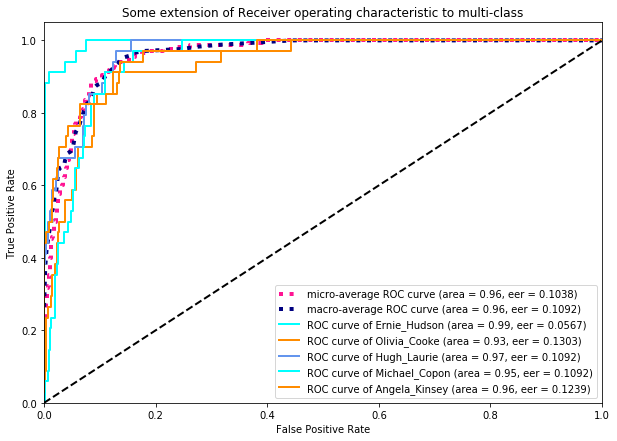

In [70]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
eer = dict()
thres = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thres[i] = roc_curve(label_vector[:, i], score_vector[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thres["micro"] = roc_curve(label_vector.ravel(), score_vector.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
eer["micro"] = fpr["micro"][np.nanargmin(np.abs(fpr["micro"] - (1 - tpr["micro"])))]

for i in range(n_classes):
    eer[i] = fpr[i][np.nanargmin(np.abs(fpr[i] - (1 - tpr[i])))]

from scipy import interp
from itertools import cycle
lw = 2
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
eer["macro"] = fpr["macro"][np.nanargmin(np.abs(fpr["macro"] - (1 - tpr["macro"])))]
# Plot all ROC curves
fig = plt.figure(figsize=(10,7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["micro"], eer["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["macro"], eer["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f}, eer = {2:0.4f})'
             ''.format(spk_labels[i], roc_auc[i], eer[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()